# Botryllus brain analysis1
By: Atefe Rostami

# Packages

In [1]:
import warnings
import random
warnings.simplefilter(action = "ignore", category = FutureWarning)
import numpy as np
import pandas as pd
# import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from igraph import *
import csv
from igraph import *
# from MulticoreTSNE import MulticoreTSNE as TSNE #faster TSNE alternative
from anndata import read_h5ad
from anndata import read_text
# import bbknn
# import leidenalg
import seaborn as sns
#from gprofiler import GProfiler

from anndata import AnnData

import plotly.graph_objects as go
import plotly.offline as pyo


In [2]:
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", mpl.__version__)
print("seaborn version:", sns.__version__)


numpy version: 2.2.6
pandas version: 2.2.3
matplotlib version: 3.10.3
seaborn version: 0.13.2


In [3]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Initial data import


In [4]:
# Load the dataset
file_path = "ci_brain_dec2023_counts_brain.txt" # Update if needed
df = pd.read_csv(file_path, sep="\t")

# Pre_Processing

In [5]:
main_columns = [col for col in df.columns if col not in ["V1", "V2"]]

new_column_names = []
for col in main_columns:
    parts = col.split("_")  # Splitting by "_"

    try:
        sample_id = parts[3]  # ILWXYZ (Sample ID)
        region = parts[5]  # Region (B2, AB)

        # Ensure "19_months" is not split
        if parts[12].isdigit() and parts[13] == "months":
            age = f"{parts[12]}_{parts[13]}"  # "19_months"
            replicate = parts[9]  # Replicate (pXXcXXrXX)
            sample_number = parts[14]  # Sample Number (SXXX)
        else:
            age = "Unknown"  # If structure doesn't match, label as unknown
            replicate = parts[-4] if len(parts) > 4 else "Unknown"
            sample_number = parts[-3] if len(parts) > 3 else "Unknown"

        # Construct the new column name in the expected format
        new_col_name = f"{sample_id}-{region}-{age}-{replicate}-{sample_number}"
    except IndexError:
        new_col_name = col  # Keep original if unexpected format

    new_column_names.append(new_col_name)

# Rename columns in DataFrame
df.columns = ["Gene_ID", "Gene_Name"] + new_column_names
display(df.head())

,Gene_ID,Gene_Name,ILW100-B2-19_months-p05c01r01-S385,ILW100-B2-19_months-p05c05r02-S401,ILW100-B2-19_months-p05c09r03-S417,ILW100-B2-19_months-p05c01r05-S433,ILW100-B2-19_months-p05c05r06-S449,ILW100-B2-19_months-p05c09r07-S465,ILW101-B2-19_months-p06c01r01-S481,ILW101-B2-19_months-p06c05r02-S497,...,ILW105-AB-19_months-p10c12r04-S912,ILW106-AB-19_months-p10c04r06-S928,ILW106-AB-19_months-p10c08r07-S944,ILW106-AB-19_months-p10c12r08-S960,ILW106-AB-19_months-p11c04r02-S976,ILW106-AB-19_months-p11c08r03-S992,ILW106-AB-19_months-p11c12r04-S1008,ILW107-AB-19_months-p11c04r06-S1024,ILW107-AB-19_months-p11c08r07-S1040,ILW107-AB-19_months-p11c12r08-S1056
0,FUN_000001,NaN,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,FUN_000002,DNAJB11_1,0,0,0,0,0,0,0,0,...,0,0,0,16,0,0,0,0,0,0
2,FUN_000003,NaN,0,0,0,0,0,0,0,0,...,0,0,0,3,10,0,0,0,0,0
3,FUN_000004,NaN,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,FUN_000005,SMU1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Filename Structure Reference

 Key Components:
 
- **Plate**: `PAC4_PlateX` (e.g., PAC4_Plate1, PAC4_Plate2)
- **Well**: `A01`, `B02`, `C03`, ... (Position in the plate)
- **Sample ID**: `ILWXYZ` (Unique identifier for the sample)
- **Tissue**: `Brain`
- **Tipe of cell (in time)**: `B2`, `AB` (Specific brain region)
- **Cell Size**: `small`, `large`
- **Replicate**: `pXXcXXrXX` (Pattern: plateX_cellX_repX)
- **Age**: `19_months` (or other time points)
- **Sample Number**: `SXXX` (e.g., S101, S202)
- **File Type**: `.bam.counts` (Processed count file)



sampleid- region- age-replicate-sample number

## Detecting duplications


In [6]:
# Count NaN values in the 'Gene_ID' column
nan_count = df['Gene_ID'].isna().sum()

print(f"Number of NaN values in 'Gene_ID': {nan_count}")

# Count NaN values in the 'Gene_ID' column
nan_count = df['Gene_Name'].isna().sum()

print(f"Number of NaN values in 'Gene_Name': {nan_count/df.shape[0]}")
# Check for duplicate Gene_IDs
gi_duplicates = df['Gene_ID'].duplicated().any()
gene_name_duplicates = df['Gene_Name'].duplicated().any()
print(f"Duplicate values in 'Gene_ID': {gi_duplicates}")
print(f"Duplicate values in 'Gene_Name': {gene_name_duplicates}")
# Create a mapping from old Gene_ID to new format
df = df.iloc[:-5]
df['Gene_ID'] = df['Gene_ID'].str.extract(r'(\d+)').astype(str)  # Extract numbers
df['Gene_ID'] = 'g' + df['Gene_ID'].astype(str)  # Convert to 'g1', 'g2', etc.
df['Gene_ID'] = df['Gene_ID'].str.replace(r'g0*', 'g', regex=True)
df['Gene_Name'].fillna(df['Gene_ID'], inplace=True)
df["g_unique"] = df["Gene_ID"] + "_" + df["Gene_Name"]
first_col = df.pop('g_unique')  # Remove the column and store it
df.insert(0, 'g_unique', first_col)

display(df.head(3))

# set GI as index
df.set_index('Gene_ID', inplace=True)
# remove "GI", the name of the index
df.index.name = None

# remove the rows which index does not start with "g" (eg. "g1")
df_cleaned = df[df.index.str.startswith('g')]
print(df.shape, df_cleaned.shape)

display(df_cleaned.head())

# save a new df without Gene_Note and Gene_Name columns
df_sel = df_cleaned.drop(['Gene_Name'], axis=1)

df_sel.set_index('g_unique', inplace=True)
df_sel.index.name = None

df_sel.head()



Number of NaN values in 'Gene_ID': 0
Number of NaN values in 'Gene_Name': 0.7462666547438076
Duplicate values in 'Gene_ID': False
Duplicate values in 'Gene_Name': True


,g_unique,Gene_ID,Gene_Name,ILW100-B2-19_months-p05c01r01-S385,ILW100-B2-19_months-p05c05r02-S401,ILW100-B2-19_months-p05c09r03-S417,ILW100-B2-19_months-p05c01r05-S433,ILW100-B2-19_months-p05c05r06-S449,ILW100-B2-19_months-p05c09r07-S465,ILW101-B2-19_months-p06c01r01-S481,...,ILW105-AB-19_months-p10c12r04-S912,ILW106-AB-19_months-p10c04r06-S928,ILW106-AB-19_months-p10c08r07-S944,ILW106-AB-19_months-p10c12r08-S960,ILW106-AB-19_months-p11c04r02-S976,ILW106-AB-19_months-p11c08r03-S992,ILW106-AB-19_months-p11c12r04-S1008,ILW107-AB-19_months-p11c04r06-S1024,ILW107-AB-19_months-p11c08r07-S1040,ILW107-AB-19_months-p11c12r08-S1056
0,g1_g1,g1,g1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,g2_DNAJB11_1,g2,DNAJB11_1,0,0,0,0,0,0,0,...,0,0,0,16,0,0,0,0,0,0
2,g3_g3,g3,g3,0,0,0,0,0,0,0,...,0,0,0,3,10,0,0,0,0,0


(44727, 685) (44727, 685)


,g_unique,Gene_Name,ILW100-B2-19_months-p05c01r01-S385,ILW100-B2-19_months-p05c05r02-S401,ILW100-B2-19_months-p05c09r03-S417,ILW100-B2-19_months-p05c01r05-S433,ILW100-B2-19_months-p05c05r06-S449,ILW100-B2-19_months-p05c09r07-S465,ILW101-B2-19_months-p06c01r01-S481,ILW101-B2-19_months-p06c05r02-S497,...,ILW105-AB-19_months-p10c12r04-S912,ILW106-AB-19_months-p10c04r06-S928,ILW106-AB-19_months-p10c08r07-S944,ILW106-AB-19_months-p10c12r08-S960,ILW106-AB-19_months-p11c04r02-S976,ILW106-AB-19_months-p11c08r03-S992,ILW106-AB-19_months-p11c12r04-S1008,ILW107-AB-19_months-p11c04r06-S1024,ILW107-AB-19_months-p11c08r07-S1040,ILW107-AB-19_months-p11c12r08-S1056
g1,g1_g1,g1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
g2,g2_DNAJB11_1,DNAJB11_1,0,0,0,0,0,0,0,0,...,0,0,0,16,0,0,0,0,0,0
g3,g3_g3,g3,0,0,0,0,0,0,0,0,...,0,0,0,3,10,0,0,0,0,0
g4,g4_g4,g4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
g5,g5_SMU1,SMU1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,ILW100-B2-19_months-p05c01r01-S385,ILW100-B2-19_months-p05c05r02-S401,ILW100-B2-19_months-p05c09r03-S417,ILW100-B2-19_months-p05c01r05-S433,ILW100-B2-19_months-p05c05r06-S449,ILW100-B2-19_months-p05c09r07-S465,ILW101-B2-19_months-p06c01r01-S481,ILW101-B2-19_months-p06c05r02-S497,ILW101-B2-19_months-p06c09r03-S513,ILW101-B2-19_months-p06c01r05-S529,...,ILW105-AB-19_months-p10c12r04-S912,ILW106-AB-19_months-p10c04r06-S928,ILW106-AB-19_months-p10c08r07-S944,ILW106-AB-19_months-p10c12r08-S960,ILW106-AB-19_months-p11c04r02-S976,ILW106-AB-19_months-p11c08r03-S992,ILW106-AB-19_months-p11c12r04-S1008,ILW107-AB-19_months-p11c04r06-S1024,ILW107-AB-19_months-p11c08r07-S1040,ILW107-AB-19_months-p11c12r08-S1056
g1_g1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
g2_DNAJB11_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,16,0,0,0,0,0,0
g3_g3,0,0,0,0,0,0,0,0,0,3,...,0,0,0,3,10,0,0,0,0,0
g4_g4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
g5_SMU1,0,0,0,0,0,0,0,0,9,0,...,0,0,0,0,0,0,0,0,0,0


**df_sel** is the cleaned input dataset. Ready for more processing

## AnnData

In [7]:
# adata = AnnData(df_sel)
# Transpose the DataFrame to have genes as rows and cells as columns
# obs is the cell/sample IDs
# var is the gene IDs/names
adata = AnnData(X=df_sel.T.values, obs=pd.DataFrame(index=df_sel.columns), var=pd.DataFrame(index=df_sel.index))

# print first 4 row names and first 4 column names
print(adata.obs_names[:4])  # First 4 cell/sample IDs
print(adata.var_names[:4])  # First 4 gene IDs/names
print(adata.shape)          # Shape: (cells, genes)


Index(['ILW100-B2-19_months-p05c01r01-S385',
       'ILW100-B2-19_months-p05c05r02-S401',
       'ILW100-B2-19_months-p05c09r03-S417',
       'ILW100-B2-19_months-p05c01r05-S433'],
      dtype='object')
Index(['g1_g1', 'g2_DNAJB11_1', 'g3_g3', 'g4_g4'], dtype='object')
(683, 44727)


In [8]:
import scipy.sparse

print(type(adata.X))

# Or check if it's sparse
if scipy.sparse.issparse(adata.X):
    print("adata.X is a sparse matrix.")
else:
    print("adata.X is a dense NumPy array.")


<class 'numpy.ndarray'>
adata.X is a dense NumPy array.


adata.X is your expression matrix (cells × genes).

.sum(axis=1) sums counts across all genes for each cell, giving the total counts per cell.


In [9]:
# Parse sample metadata from cell/sample names and store as separate columns in adata.obs
# Extracts Sample_ID, Region, Age, Replicate, and Sample_Number from the sample name string
adata.obs['Sample_ID'] = [i.split('-')[0] for i in adata.obs_names] 
adata.obs['Region'] =    [i.split('-')[1] for i in adata.obs_names]
adata.obs['Age'] =       [i.split('-')[2] for i in adata.obs_names]
adata.obs['Replicate'] = [i.split('-')[3] for i in adata.obs_names]
adata.obs['Sample_Number'] = [i.split('-')[4] for i in adata.obs_names]

print(adata.shape)


(683, 44727)


**Check** the format of the matrix

In [10]:
# Sum along the columns (genes)
# adata.X is a sparse matrix, so we need to convert it to a dense format first
total_counts = adata.X.sum(axis=1)
print(total_counts.shape)

(683,)


## Quality control

In [11]:
import scanpy as sc  # Ensure scanpy is imported

# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1) # total counts per cell
adata.obs['n_genes'] = (adata.X > 0).sum(1) # number of expressed genes per cell
adata = adata[adata.obs['n_counts']>=100]
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=10)

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:170: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



In [12]:
print(adata.obs.shape)

(581, 7)


In [13]:
# Zeros fraction
zeros_perGene_frac = np.sum(adata.X == 0, axis=0) / adata.X.shape[0]

genes_above = zeros_perGene_frac[zeros_perGene_frac > 0.95]
num_genes_above = len(genes_above)/adata.X.shape[1]
print("Number of genes with a fraction of zeros above :", num_genes_above)

# plt.figure(figsize=(6,3))
# sns.histplot(zeros_perGene_frac, bins=80, color='skyblue', stat='density')
# plt.xlim(0.85,1)



Number of genes with a fraction of zeros above : 0.38449993177786873


In [14]:
print(adata.shape)

(581, 14658)


# Normalization

## LogNorm

It adjusts for sequencing depth differences across cells — like converting all cells to the same "library size."

Think of it like converting raw counts to counts per 10,000 (CP10K), similar to CPM (counts per million).

In [15]:
# Step 1: Normalize total counts per cell
sc.pp.normalize_total(adata, target_sum=1e4)

# Step 2: Logarithmize the data log(x+1)
sc.pp.log1p(adata)



# PCA

## Quantitative HVG Metrics

In [16]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# 1. Get exact HVG counts
n_total_genes = adata.n_vars
n_hvgs = adata.var['highly_variable'].sum()
hvg_percentage = (n_hvgs / n_total_genes) * 100

print(f"Total genes: {n_total_genes}")
print(f"Highly variable genes: {n_hvgs}")
print(f"HVG percentage: {hvg_percentage:.2f}%")

# 2. Create detailed HVG summary table
hvg_summary = pd.DataFrame({
    'Metric': ['Total genes after QC', 'Highly variable genes', 'Non-variable genes', 
               'HVG percentage', 'Genes used for PCA'],
    'Count': [n_total_genes, n_hvgs, n_total_genes - n_hvgs, f"{hvg_percentage:.2f}%", n_hvgs],
    'Description': ['All genes passing quality filters', 
                   'Genes with high cell-to-cell variability',
                   'Constitutively expressed genes',
                   'Proportion of variable genes',
                   'Features for dimensionality reduction']
})

print("\nTable: Highly Variable Gene Selection Summary")
print(hvg_summary.to_string(index=False))

# 3. Analyze HVG distribution by expression level
hvg_stats = adata.var.groupby('highly_variable').agg({
    'means': ['count', 'mean', 'std'],
    'dispersions_norm': ['mean', 'std']
}).round(4)

print("\nHVG vs Non-HVG Expression Statistics:")
print(hvg_stats)

# 4. Save HVG list for reproducibility
hvg_genes = adata.var[adata.var['highly_variable']].index.tolist()
pd.DataFrame({'highly_variable_genes': hvg_genes}).to_csv('highly_variable_genes.csv', index=False)

Total genes: 14658
Highly variable genes: 4146
HVG percentage: 28.28%

Table: Highly Variable Gene Selection Summary
               Metric  Count                              Description
 Total genes after QC  14658        All genes passing quality filters
Highly variable genes   4146 Genes with high cell-to-cell variability
   Non-variable genes  10512           Constitutively expressed genes
       HVG percentage 28.28%             Proportion of variable genes
   Genes used for PCA   4146    Features for dimensionality reduction

HVG vs Non-HVG Expression Statistics:
                 means                 dispersions_norm        
                 count    mean     std             mean     std
highly_variable                                                
False            10512  0.2534  0.4495          -0.4781  0.6620
True              4146  0.2818  0.3350           1.2125  0.6086


## Best HVG parameter finding

=== HVG Parameter Sensitivity Analysis ===
   Parameter_Set  min_mean  max_mean  min_disp  N_HVGs  HVG_Percentage
0              1      0.01       3.0       0.5    4146           28.28
1              2      0.01       3.0       0.5    4146           28.28
2              3      0.02       3.0       0.5    4144           28.27
3              4      0.01       2.5       0.5    4131           28.18
4              5      0.01       3.0       0.4    4627           31.57
5              6      0.01       3.0       0.6    3640           24.83


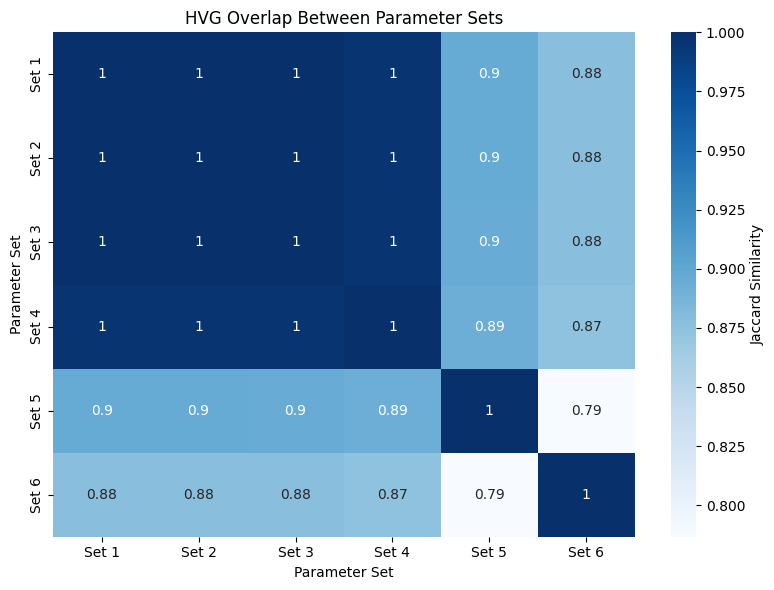


=== Core Stable HVGs (appearing in ≥80% of parameter sets) ===
Number of core stable HVGs: 4146
Percentage of original HVGs that are stable: 100.0%

Running bootstrap validation...

Bootstrap HVG stability (appearing in ≥70% of bootstrap samples):
Core stable HVGs: 4088
Average HVGs per bootstrap: 4159
HVG count std deviation: 31

=== HVG Selection Stability Summary ===
    Validation_Method  Core_HVGs   Stability_Threshold Confidence_Level
Parameter_Sensitivity       4146    80% parameter sets             High
 Bootstrap_Validation       4088 70% bootstrap samples             High
   Original_Selection       4146            Single run           Medium


In [17]:
# 1. Parameter grid for HVG selection
param_grid = [
    {'min_mean': 0.01, 'max_mean': 3, 'min_disp': 0.5},
    {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5},  # Original
    {'min_mean': 0.02, 'max_mean': 3, 'min_disp': 0.5},
    {'min_mean': 0.0125, 'max_mean': 2.5, 'min_disp': 0.5},
    {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.4},
    {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.6},
]

# 2. Test HVG stability across parameters
hvg_stability_results = []

for i, params in enumerate(param_grid):
    # Create temporary copy
    adata_temp = adata.copy()
    
    # Apply HVG selection with different parameters
    sc.pp.highly_variable_genes(adata_temp, **params)
    
    hvg_genes = adata_temp.var[adata_temp.var['highly_variable']].index.tolist()
    n_hvgs = len(hvg_genes)
    
    hvg_stability_results.append({
        'Parameter_Set': i + 1,
        'min_mean': params['min_mean'],
        'max_mean': params['max_mean'],
        'min_disp': params['min_disp'],
        'N_HVGs': n_hvgs,
        'HVG_Percentage': (n_hvgs / adata.n_vars) * 100,
        'HVG_List': hvg_genes
    })

# 3. Analyze parameter sensitivity
stability_df = pd.DataFrame([{k: v for k, v in result.items() if k != 'HVG_List'} 
                            for result in hvg_stability_results])

print("=== HVG Parameter Sensitivity Analysis ===")
print(stability_df.round(2))

# 4. Calculate gene overlap between parameter sets
def calculate_overlap_matrix(hvg_results):
    """Calculate Jaccard similarity between HVG sets"""
    n_sets = len(hvg_results)
    overlap_matrix = np.zeros((n_sets, n_sets))
    
    for i in range(n_sets):
        for j in range(n_sets):
            set1 = set(hvg_results[i]['HVG_List'])
            set2 = set(hvg_results[j]['HVG_List'])
            
            intersection = len(set1.intersection(set2))
            union = len(set1.union(set2))
            
            overlap_matrix[i, j] = intersection / union if union > 0 else 0
    
    return overlap_matrix

overlap_matrix = calculate_overlap_matrix(hvg_stability_results)

# Plot overlap heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(overlap_matrix, annot=True, cmap='Blues', 
            xticklabels=[f"Set {i+1}" for i in range(len(param_grid))],
            yticklabels=[f"Set {i+1}" for i in range(len(param_grid))],
            cbar_kws={'label': 'Jaccard Similarity'})
plt.title('HVG Overlap Between Parameter Sets')
plt.xlabel('Parameter Set')
plt.ylabel('Parameter Set')
plt.tight_layout()
plt.show()

# 5. Identify core stable genes
def find_core_hvgs(hvg_results, min_occurrence=0.8):
    """Find genes that appear as HVG in most parameter sets"""
    all_genes = set()
    for result in hvg_results:
        all_genes.update(result['HVG_List'])
    
    gene_counts = {}
    for gene in all_genes:
        count = sum(1 for result in hvg_results if gene in result['HVG_List'])
        gene_counts[gene] = count
    
    min_count = int(len(hvg_results) * min_occurrence)
    core_genes = [gene for gene, count in gene_counts.items() if count >= min_count]
    
    return core_genes, gene_counts

core_hvgs, gene_occurrence = find_core_hvgs(hvg_stability_results, 0.8)

print(f"\n=== Core Stable HVGs (appearing in ≥80% of parameter sets) ===")
print(f"Number of core stable HVGs: {len(core_hvgs)}")
print(f"Percentage of original HVGs that are stable: {len(core_hvgs)/len(hvg_stability_results[1]['HVG_List'])*100:.1f}%")

# 6. Bootstrap validation
def bootstrap_hvg_validation(adata, n_bootstrap=10, sample_fraction=0.8):
    """Bootstrap validation of HVG selection"""
    bootstrap_hvgs = []
    
    for i in range(n_bootstrap):
        # Sample cells
        n_cells = int(adata.n_obs * sample_fraction)
        cell_indices = np.random.choice(adata.n_obs, n_cells, replace=False)
        
        # Create bootstrap sample
        adata_bootstrap = adata[cell_indices, :].copy()
        
        # Recalculate HVGs
        sc.pp.highly_variable_genes(adata_bootstrap, min_mean=0.0125, max_mean=3, min_disp=0.5)
        hvg_genes = adata_bootstrap.var[adata_bootstrap.var['highly_variable']].index.tolist()
        bootstrap_hvgs.append(hvg_genes)
    
    return bootstrap_hvgs

# Run bootstrap validation
print("\nRunning bootstrap validation...")
bootstrap_results = bootstrap_hvg_validation(adata, n_bootstrap=10)

# Calculate bootstrap stability
bootstrap_core_hvgs, bootstrap_counts = find_core_hvgs(
    [{'HVG_List': hvgs} for hvgs in bootstrap_results], 0.7
)

print(f"\nBootstrap HVG stability (appearing in ≥70% of bootstrap samples):")
print(f"Core stable HVGs: {len(bootstrap_core_hvgs)}")
print(f"Average HVGs per bootstrap: {np.mean([len(hvgs) for hvgs in bootstrap_results]):.0f}")
print(f"HVG count std deviation: {np.std([len(hvgs) for hvgs in bootstrap_results]):.0f}")

# 7. Final stability summary
stability_summary = pd.DataFrame({
    'Validation_Method': ['Parameter_Sensitivity', 'Bootstrap_Validation', 'Original_Selection'],
    'Core_HVGs': [len(core_hvgs), len(bootstrap_core_hvgs), len(hvg_stability_results[1]['HVG_List'])],
    'Stability_Threshold': ['80% parameter sets', '70% bootstrap samples', 'Single run'],
    'Confidence_Level': ['High', 'High', 'Medium']
})

print("\n=== HVG Selection Stability Summary ===")
print(stability_summary.to_string(index=False))

# Save stable gene lists
pd.DataFrame({'core_stable_hvgs': core_hvgs}).to_csv('core_stable_hvgs.csv', index=False)
pd.DataFrame({'bootstrap_stable_hvgs': bootstrap_core_hvgs}).to_csv('bootstrap_stable_hvgs.csv', index=False)

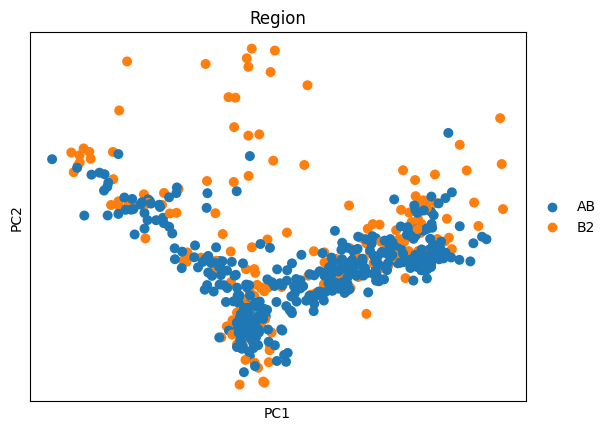

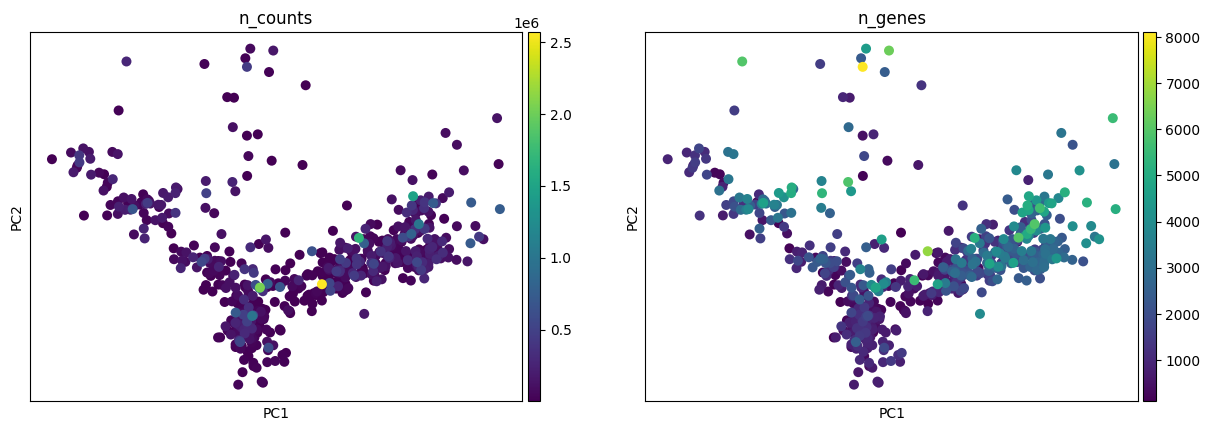

In [19]:
# Identify highly variable genes
# sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Plot highly variable genes
# sc.pl.highly_variable_genes(adata)

# Run PCA using HVGs
sc.tl.pca(adata, svd_solver = 'arpack', use_highly_variable=True)

# Plot PCA
sc.pl.pca(adata, color=['Region'])

# Plot PCA with n_counts and n_genes
sc.pl.pca_scatter(adata, color=['n_counts', 'n_genes'])

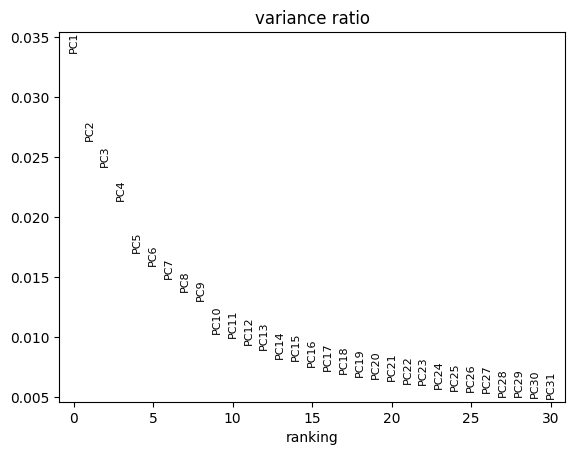

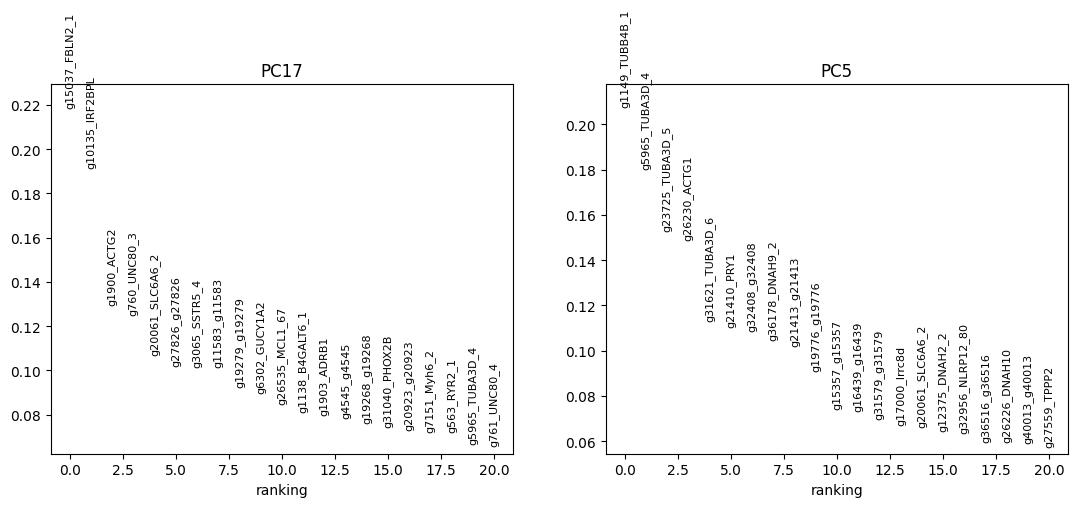

In [20]:
# pca variance ratio
sc.pl.pca_variance_ratio(adata, log=False)

# PCA loadings (genes contributing to PCs)
sc.pl.pca_loadings(adata, components='17,5', show=False, include_lowest=False, n_points=20)

/tmp/ipykernel_161746/4108644102.py:22: DeprecationWarning:

Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)



=== Optimal PC Number Selection ===
Knee point method: PC10
Variance threshold method (1%): PC11
Cumulative variance method (80%): PC50


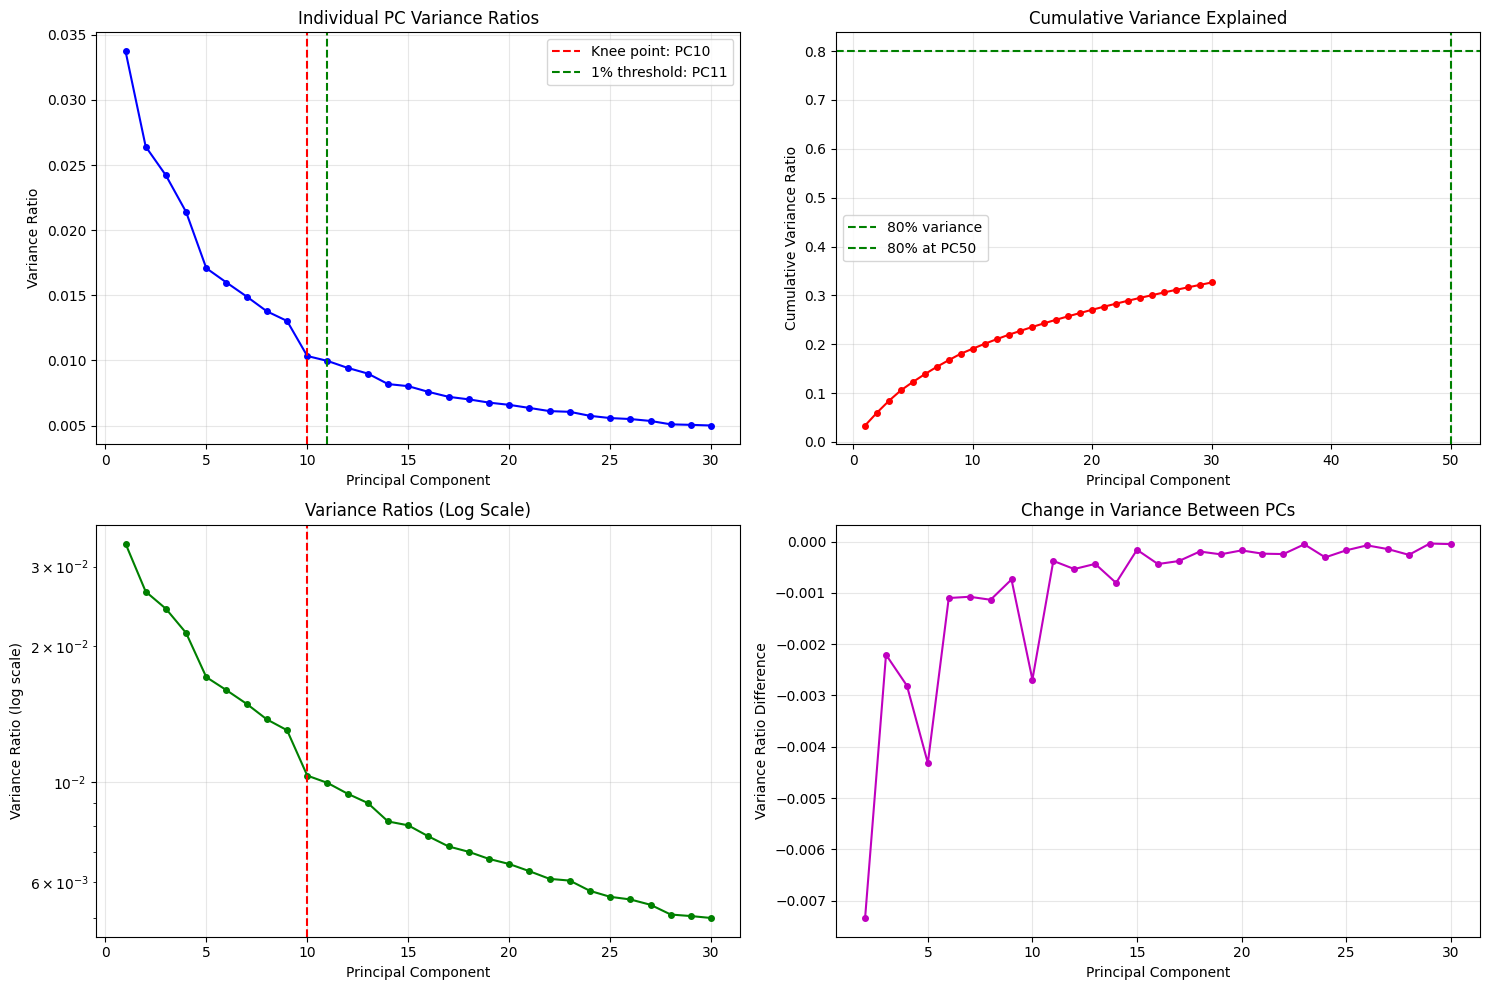


PC Selection Recommendations:
                   Method  Recommended_PCs Variance_Captured                Use_Case
     Knee Point Detection               10             19.1%         Balanced choice
  Variance Threshold (1%)               11             20.1% Remove noise components
Cumulative Variance (80%)               50             40.9%  Comprehensive analysis
      Conservative Choice               10             19.1%    Minimize overfitting
        Aggressive Choice               11             20.1%  Capture more variation

*** FINAL RECOMMENDATION: Use PC1-PC10 for downstream analysis ***
This captures 19.1% of total variance


In [21]:
# 1. Calculate cumulative variance explained
variance_ratio = adata.uns['pca']['variance_ratio']
cumulative_variance = np.cumsum(variance_ratio)

# 2. Find elbow point using different methods
def find_elbow_point(variance_ratios, method='knee'):
    """Find elbow point in variance curve"""
    if method == 'knee':
        # Knee point detection
        n_components = len(variance_ratios)
        x = np.arange(n_components)
        y = variance_ratios
        
        # Line from first to last point
        line_start = np.array([x[0], y[0]])
        line_end = np.array([x[-1], y[-1]])
        
        # Calculate distances from each point to the line
        distances = []
        for i in range(n_components):
            point = np.array([x[i], y[i]])
            distance = np.abs(np.cross(line_end - line_start, line_start - point)) / np.linalg.norm(line_end - line_start)
            distances.append(distance)
        
        elbow_idx = np.argmax(distances)
        return elbow_idx + 1  # +1 because we want PC number, not index
    
    elif method == 'threshold':
        # Find where variance drops below threshold
        for i, var in enumerate(variance_ratios):
            if var < 0.01:  # 1% threshold
                return i + 1
        return len(variance_ratios)
    
    elif method == 'cumulative':
        # Find where cumulative variance reaches threshold
        cumulative = np.cumsum(variance_ratios)
        for i, cum_var in enumerate(cumulative):
            if cum_var > 0.8:  # 80% threshold
                return i + 1
        return len(variance_ratios)

# 3. Apply different elbow detection methods
elbow_knee = find_elbow_point(variance_ratio, 'knee')
elbow_threshold = find_elbow_point(variance_ratio, 'threshold')
elbow_cumulative = find_elbow_point(variance_ratio, 'cumulative')

print("=== Optimal PC Number Selection ===")
print(f"Knee point method: PC{elbow_knee}")
print(f"Variance threshold method (1%): PC{elbow_threshold}")
print(f"Cumulative variance method (80%): PC{elbow_cumulative}")

# 4. Create comprehensive elbow plot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Individual variance ratios
axes[0,0].plot(range(1, 31), variance_ratio[:30], 'bo-', markersize=4)
axes[0,0].axvline(x=elbow_knee, color='red', linestyle='--', label=f'Knee point: PC{elbow_knee}')
axes[0,0].axvline(x=elbow_threshold, color='green', linestyle='--', label=f'1% threshold: PC{elbow_threshold}')
axes[0,0].set_xlabel('Principal Component')
axes[0,0].set_ylabel('Variance Ratio')
axes[0,0].set_title('Individual PC Variance Ratios')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Cumulative variance
axes[0,1].plot(range(1, 31), cumulative_variance[:30], 'ro-', markersize=4)
axes[0,1].axhline(y=0.8, color='green', linestyle='--', label='80% variance')
axes[0,1].axvline(x=elbow_cumulative, color='green', linestyle='--', label=f'80% at PC{elbow_cumulative}')
axes[0,1].set_xlabel('Principal Component')
axes[0,1].set_ylabel('Cumulative Variance Ratio')
axes[0,1].set_title('Cumulative Variance Explained')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Log scale for better visualization of tail
axes[1,0].semilogy(range(1, 31), variance_ratio[:30], 'go-', markersize=4)
axes[1,0].axvline(x=elbow_knee, color='red', linestyle='--')
axes[1,0].set_xlabel('Principal Component')
axes[1,0].set_ylabel('Variance Ratio (log scale)')
axes[1,0].set_title('Variance Ratios (Log Scale)')
axes[1,0].grid(True, alpha=0.3)

# Variance difference (second derivative approximation)
variance_diff = np.diff(variance_ratio[:30])
axes[1,1].plot(range(2, 31), variance_diff, 'mo-', markersize=4)
axes[1,1].set_xlabel('Principal Component')
axes[1,1].set_ylabel('Variance Ratio Difference')
axes[1,1].set_title('Change in Variance Between PCs')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Summary table of recommendations
pc_recommendations = pd.DataFrame({
    'Method': ['Knee Point Detection', 'Variance Threshold (1%)', 'Cumulative Variance (80%)', 
               'Conservative Choice', 'Aggressive Choice'],
    'Recommended_PCs': [elbow_knee, elbow_threshold, elbow_cumulative, 
                       min(elbow_knee, elbow_threshold), max(elbow_knee, elbow_threshold)],
    'Variance_Captured': [f"{cumulative_variance[elbow_knee-1]:.1%}", 
                         f"{cumulative_variance[elbow_threshold-1]:.1%}",
                         f"{cumulative_variance[elbow_cumulative-1]:.1%}",
                         f"{cumulative_variance[min(elbow_knee, elbow_threshold)-1]:.1%}",
                         f"{cumulative_variance[max(elbow_knee, elbow_threshold)-1]:.1%}"],
    'Use_Case': ['Balanced choice', 'Remove noise components', 'Comprehensive analysis',
                'Minimize overfitting', 'Capture more variation']
})

print("\nPC Selection Recommendations:")
print(pc_recommendations.to_string(index=False))

# 6. Final recommendation
recommended_pcs = elbow_knee
print(f"\n*** FINAL RECOMMENDATION: Use PC1-PC{recommended_pcs} for downstream analysis ***")
print(f"This captures {cumulative_variance[recommended_pcs-1]:.1%} of total variance")

# Dimensionality Reduction UMAP


## Grid search

In [ ]:
# ============================================================================
# ISOLATED UMAP GRID SEARCH - DOES NOT AFFECT MAIN ANALYSIS
# This code works on copies and only returns parameter recommendations
# ============================================================================

from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
import itertools
import numpy as np
import pandas as pd
import scanpy as sc

def isolated_umap_parameter_search(adata_original, max_tests=30, random_seed=42):
    """
    ISOLATED UMAP parameter search that doesn't affect your main analysis.
    Returns only a summary table with parameter recommendations.
    
    Parameters:
    - adata_original: Your main AnnData object (will NOT be modified)
    - max_tests: Maximum number of parameter combinations to test
    - random_seed: For reproducible results
    
    Returns:
    - DataFrame with parameter combinations and quality scores
    """
    
    print("🔍 ISOLATED UMAP Parameter Search")
    print("=" * 50)
    print("⚠️  This analysis works on COPIES - your main data is safe!")
    print(f"📊 Testing up to {max_tests} parameter combinations...")
    
    # Set random seed for reproducibility
    np.random.seed(random_seed)
    
    # Define focused parameter ranges (reasonable for most scRNA-seq)
    param_options = {
        'n_neighbors': [15, 25, 35, 50],
        'n_pcs': [10, 15, 20, 25],
        'metric': ['cosine', 'euclidean'],
        'min_dist': [0.1, 0.3, 0.5],
        'spread': [1.0, 1.5]
    }
    
    # Generate all combinations
    all_combinations = list(itertools.product(
        param_options['n_neighbors'],
        param_options['n_pcs'],
        param_options['metric'],
        param_options['min_dist'],
        param_options['spread']
    ))
    
    # Randomly sample if too many combinations
    if len(all_combinations) > max_tests:
        selected_indices = np.random.choice(len(all_combinations), max_tests, replace=False)
        test_combinations = [all_combinations[i] for i in selected_indices]
    else:
        test_combinations = all_combinations
    
    print(f"🧪 Testing {len(test_combinations)} parameter combinations...")
    print("⏱️  This may take a few minutes - progress will be shown")
    
    # Store results
    results = []
    
    for i, (n_neighbors, n_pcs, metric, min_dist, spread) in enumerate(test_combinations):
        
        # Progress indicator
        if (i + 1) % 5 == 0 or i == 0:
            print(f"   Progress: {i+1}/{len(test_combinations)} combinations tested")
        
        param_name = f"nn{n_neighbors}_pc{n_pcs}_{metric}_md{min_dist}_sp{spread}"
        
        try:
            # ⚠️ CRITICAL: Work on a COPY - never modify original data
            adata_copy = adata_original.copy()
            
            # Run neighbors computation
            sc.pp.neighbors(
                adata_copy,
                n_neighbors=n_neighbors,
                n_pcs=n_pcs,
                metric=metric,
                random_state=random_seed  # For reproducibility
            )
            
            # Run UMAP
            sc.tl.umap(
                adata_copy,
                min_dist=min_dist,
                spread=spread,
                random_state=random_seed  # For reproducibility
            )
            
            # Calculate quality metrics on the copy
            umap_coords = adata_copy.obsm['X_umap']
            
            # Basic clustering for silhouette score
            kmeans = KMeans(n_clusters=8, random_state=random_seed, n_init=10)
            cluster_labels = kmeans.fit_predict(umap_coords)
            silhouette = silhouette_score(umap_coords, cluster_labels)
            
            # Additional quality metrics
            spread_score = np.std(umap_coords) / np.mean(np.abs(umap_coords))
            
            # Neighborhood preservation (simplified)
            pc_coords = adata_copy.obsm['X_pca'][:, :n_pcs]
            preservation = calculate_simple_preservation(pc_coords, umap_coords, metric)
            
            # Region separation if available
            region_score = 0.5  # Default
            if 'Region' in adata_copy.obs.columns:
                region_score = calculate_region_separation(umap_coords, adata_copy.obs['Region'])
            
            # Store result
            results.append({
                'Parameter_Set': param_name,
                'n_neighbors': n_neighbors,
                'n_pcs': n_pcs,
                'metric': metric,
                'min_dist': min_dist,
                'spread': spread,
                'Silhouette_Score': round(silhouette, 3),
                'Spread_Quality': round(spread_score, 3),
                'Neighborhood_Preservation': round(preservation, 3),
                'Region_Separation': round(region_score, 3),
                'Overall_Score': round((silhouette + preservation + region_score) / 3, 3),
                'Status': 'Success'
            })
            
            # Clean up copy to save memory
            del adata_copy
            
        except Exception as e:
            # Record failed combinations
            results.append({
                'Parameter_Set': param_name,
                'n_neighbors': n_neighbors,
                'n_pcs': n_pcs,
                'metric': metric,
                'min_dist': min_dist,
                'spread': spread,
                'Silhouette_Score': 0,
                'Spread_Quality': 0,
                'Neighborhood_Preservation': 0,
                'Region_Separation': 0,
                'Overall_Score': 0,
                'Status': f'Failed: {str(e)[:30]}'
            })
    
    # Convert to DataFrame and sort by overall score
    results_df = pd.DataFrame(results)
    successful_results = results_df[results_df['Status'] == 'Success']
    
    if len(successful_results) > 0:
        successful_results = successful_results.sort_values('Overall_Score', ascending=False)
    
    print("\n✅ Parameter search completed!")
    print(f"   Successful tests: {len(successful_results)}/{len(results)}")
    
    return successful_results.reset_index(drop=True) if len(successful_results) > 0 else results_df

def calculate_simple_preservation(original_coords, umap_coords, metric):
    """Simple neighborhood preservation calculation"""
    try:
        k = min(10, len(original_coords) // 10)
        
        # Original space neighbors
        nbrs_orig = NearestNeighbors(n_neighbors=k, metric=metric).fit(original_coords)
        _, indices_orig = nbrs_orig.kneighbors(original_coords)
        
        # UMAP space neighbors
        nbrs_umap = NearestNeighbors(n_neighbors=k).fit(umap_coords)
        _, indices_umap = nbrs_umap.kneighbors(umap_coords)
        
        # Calculate preservation
        preservation_scores = []
        for i in range(min(100, len(indices_orig))):  # Sample for speed
            intersection = len(set(indices_orig[i]) & set(indices_umap[i]))
            preservation_scores.append(intersection / k)
        
        return np.mean(preservation_scores)
    except:
        return 0.5

def calculate_region_separation(umap_coords, regions):
    """Calculate how well regions are separated"""
    try:
        unique_regions = regions.unique()
        if len(unique_regions) < 2:
            return 0.5
        
        # Convert to numeric labels
        region_map = {region: i for i, region in enumerate(unique_regions)}
        numeric_labels = np.array([region_map[region] for region in regions])
        
        # Calculate silhouette score for regions
        region_silhouette = silhouette_score(umap_coords, numeric_labels)
        return max(0, region_silhouette)
    except:
        return 0.5
    if len(remaining_combinations) > 50:
        np.random.seed(42)
        sampled_indices = np.random.choice(len(remaining_combinations), 50, replace=False)
        priority_3 = [remaining_combinations[i] for i in sampled_indices]
    else:
        priority_3 = remaining_combinations
    
    # Combine all priorities
    final_combinations = priority_1 + priority_2 + priority_3
    
    # Remove duplicates while preserving order
    seen = set()
    unique_combinations = []
    for combo in final_combinations:
        if combo not in seen:
            seen.add(combo)
            unique_combinations.append(combo)
    
    print(f"Priority 1 (standard scRNA-seq): {len(priority_1)} combinations")
    print(f"Priority 2 (extended ranges): {len(priority_2)} combinations") 
    print(f"Priority 3 (random sampling): {len(priority_3)} combinations")
    print(f"Final unique combinations: {len(unique_combinations)}")
    
    # Convert to dictionary format
    param_combinations = []
    for nn, npcs, metric, min_dist, spread in unique_combinations:
        param_combinations.append({
            'n_neighbors': nn,
            'n_pcs': npcs,
            'metric': metric,
            'min_dist': min_dist,
            'spread': spread
        })
    
    return param_combinations

def run_comprehensive_umap_optimization(adata, max_combinations=None):
    """
    Run comprehensive UMAP optimization with extensive parameter testing
    """
    
    print("=== BOTRYLLUS BRAIN scRNA-seq COMPREHENSIVE UMAP OPTIMIZATION ===")
    
    # Generate parameter combinations
    param_combinations = generate_comprehensive_parameter_grid()
    
    # Limit combinations if specified
    if max_combinations and len(param_combinations) > max_combinations:
        print(f"Limiting to first {max_combinations} combinations for computational efficiency")
        param_combinations = param_combinations[:max_combinations]
    
    print(f"Testing {len(param_combinations)} parameter combinations for cell type discovery...")
    print("This may take a while - progress will be reported every 10 combinations\n")
    
    umap_results = {}
    failed_combinations = []
    
    for i, params in enumerate(param_combinations):
        if i % 10 == 0:
            print(f"Progress: {i+1}/{len(param_combinations)} combinations tested...")
        
        param_name = (f"nn{params['n_neighbors']}_pc{params['n_pcs']}_{params['metric']}_"
                     f"md{params['min_dist']}_sp{params['spread']}")
        
        try:
            # Create temporary copy
            adata_temp = adata.copy()
            
            # Compute neighbors
            sc.pp.neighbors(adata_temp, 
                           n_neighbors=params['n_neighbors'], 
                           n_pcs=params['n_pcs'], 
                           metric=params['metric'],
                           random_state=42)
            
            # Compute UMAP with additional parameters
            sc.tl.umap(adata_temp, 
                      min_dist=params['min_dist'],
                      spread=params['spread'],
                      random_state=42)
            
            # Store results
            umap_results[param_name] = {
                'params': params,
                'umap': adata_temp.obsm['X_umap'].copy(),
                'connectivities': adata_temp.obsp['connectivities'].copy(),
                'distances': adata_temp.obsp['distances'].copy(),
                'success': True
            }
            
        except Exception as e:
            failed_combinations.append({'params': params, 'error': str(e)})
            umap_results[param_name] = {
                'params': params,
                'success': False,
                'error': str(e)
            }
    
    print(f"\nParameter testing complete!")
    print(f"Successful combinations: {sum(1 for r in umap_results.values() if r.get('success', False))}")
    print(f"Failed combinations: {len(failed_combinations)}")
    
    if failed_combinations:
        print("\nFailed combinations summary:")
        error_summary = {}
        for fail in failed_combinations:
            error_type = fail['error'].split(':')[0]
            error_summary[error_type] = error_summary.get(error_type, 0) + 1
        for error, count in error_summary.items():
            print(f"  {error}: {count} combinations")
    
    return umap_results

# MISSING HELPER FUNCTIONS - FIXED!

def calculate_mixing_score(coords, labels):
    """Calculate how well different labels are mixed in the embedding"""
    from sklearn.neighbors import NearestNeighbors
    
    unique_labels = np.unique(labels)
    if len(unique_labels) < 2:
        return 0.0
    
    k = min(10, len(coords) // 5)
    if k < 3:
        k = 3
    
    nbrs = NearestNeighbors(n_neighbors=k).fit(coords)
    _, indices = nbrs.kneighbors(coords)
    
    mixing_scores = []
    for i, cell_label in enumerate(labels):
        neighbor_labels = labels[indices[i]]
        different_labels = sum(neighbor_labels != cell_label)
        mixing_scores.append(different_labels / k)
    
    return np.mean(mixing_scores)

def calculate_continuous_preservation_scrna(coords, values):
    """Calculate how well continuous variables are preserved in embedding"""
    from sklearn.neighbors import NearestNeighbors
    
    k = min(8, len(coords) // 10)
    if k < 3:
        k = 3
    
    nbrs = NearestNeighbors(n_neighbors=k).fit(coords)
    _, indices = nbrs.kneighbors(coords)
    
    correlation_scores = []
    for i in range(len(values)):
        # Get neighbors
        neighbor_indices = indices[i]
        neighbor_coords = coords[neighbor_indices]
        neighbor_values = values[neighbor_indices]
        
        # Calculate distances to neighbors
        distances = np.linalg.norm(neighbor_coords - coords[i], axis=1)
        
        # Calculate correlation between distance and value difference
        value_differences = np.abs(neighbor_values - values[i])
        
        if len(distances) > 1 and np.std(distances) > 0 and np.std(value_differences) > 0:
            corr = np.corrcoef(distances, value_differences)[0, 1]
            if not np.isnan(corr):
                # Convert to preservation score (negative correlation = good preservation)
                preservation = max(0, 1 - corr)
                correlation_scores.append(preservation)
    
    return np.mean(correlation_scores) if correlation_scores else 0.5

def assess_umap_quality_comprehensive(umap_coords, connectivities, distances, adata, params):
    """
    Enhanced comprehensive UMAP quality assessment
    """
    assessment = {}
    n_cells = len(umap_coords)
    
    print(f"    Computing enhanced quality metrics...")
    
    # 1. ENHANCED SILHOUETTE SCORE ANALYSIS
    silhouette_results = calculate_enhanced_silhouette_scores(umap_coords, n_cells)
    assessment.update(silhouette_results)
    
    # 2. MULTI-SCALE NEIGHBORHOOD PRESERVATION
    assessment.update(calculate_multiscale_neighborhood_preservation(
        adata, umap_coords, params
    ))
    
    # 3. ENHANCED BIOLOGICAL RELEVANCE METRICS
    bio_metrics = calculate_enhanced_biological_relevance(adata, umap_coords)
    assessment.update(bio_metrics)
    
    # 4. ADVANCED CONNECTIVITY ANALYSIS
    conn_metrics = calculate_advanced_connectivity_metrics(connectivities, distances)
    assessment.update(conn_metrics)
    
    # 5. MULTI-SCALE STRUCTURE PRESERVATION
    assessment.update(calculate_multiscale_structure_preservation(
        adata, umap_coords, params
    ))
    
    # 6. CLUSTERING STABILITY ANALYSIS
    assessment.update(calculate_clustering_stability(umap_coords, connectivities))
    
    # 7. EMBEDDING QUALITY METRICS
    assessment.update(calculate_embedding_quality_metrics(umap_coords))
    
    return assessment

def calculate_enhanced_silhouette_scores(umap_coords, n_cells):
    """Enhanced silhouette analysis with multiple clustering algorithms"""
    
    # Determine cluster range
    min_clusters = 2
    max_clusters = min(25, n_cells // 15)  # Allow more clusters for comprehensive testing
    
    if max_clusters < min_clusters:
        max_clusters = min_clusters + 1
    
    cluster_range = range(min_clusters, max_clusters + 1)
    
    # Test multiple clustering algorithms
    clustering_results = {}
    
    for algorithm in ['kmeans', 'agglomerative', 'spectral']:
        alg_results = {
            'silhouette_scores': [],
            'cluster_numbers': [],
            'best_silhouette': -1,
            'best_n_clusters': min_clusters
        }
        
        for n_clusters in cluster_range:
            try:
                if algorithm == 'kmeans':
                    clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
                elif algorithm == 'agglomerative':
                    clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
                elif algorithm == 'spectral':
                    if n_clusters <= 10:  # Limit spectral for computational efficiency
                        from sklearn.cluster import SpectralClustering
                        clusterer = SpectralClustering(n_clusters=n_clusters, random_state=42, 
                                                     affinity='nearest_neighbors')
                    else:
                        continue
                
                cluster_labels = clusterer.fit_predict(umap_coords)
                sil_score = silhouette_score(umap_coords, cluster_labels)
                
                alg_results['silhouette_scores'].append(sil_score)
                alg_results['cluster_numbers'].append(n_clusters)
                
                if sil_score > alg_results['best_silhouette']:
                    alg_results['best_silhouette'] = sil_score
                    alg_results['best_n_clusters'] = n_clusters
                    
            except Exception as e:
                continue
        
        clustering_results[algorithm] = alg_results
    
    # Aggregate results
    all_scores = []
    for alg_results in clustering_results.values():
        all_scores.extend(alg_results['silhouette_scores'])
    
    if clustering_results:
        best_overall = max(clustering_results.values(), key=lambda x: x['best_silhouette'])
    else:
        # Fallback if no clustering succeeded
        best_overall = {
            'best_silhouette': 0.0,
            'best_n_clusters': 2
        }
    
    return {
        'max_silhouette_score': best_overall['best_silhouette'],
        'optimal_n_clusters': best_overall['best_n_clusters'],
        'avg_silhouette_score': np.mean(all_scores) if all_scores else 0,
        'silhouette_consistency': 1 - (np.std(all_scores) / (np.mean(all_scores) + 1e-10)) if len(all_scores) > 1 else 0,
        'clustering_algorithm_agreement': len([r for r in clustering_results.values() 
                                            if abs(r['best_n_clusters'] - best_overall['best_n_clusters']) <= 1])
    }

def calculate_multiscale_neighborhood_preservation(adata, umap_coords, params):
    """Calculate neighborhood preservation at multiple scales"""
    
    n_pcs = params['n_pcs']
    pc_coords = adata.obsm['X_pca'][:, :n_pcs]
    
    # Test multiple neighborhood sizes
    k_values = [5, 10, 15, 30] if len(umap_coords) > 100 else [3, 5, 8]
    preservation_scores = {}
    
    for k in k_values:
        if k >= len(umap_coords):
            continue
            
        try:
            # Original space neighbors
            nbrs_pc = NearestNeighbors(n_neighbors=k, metric=params['metric']).fit(pc_coords)
            _, indices_pc = nbrs_pc.kneighbors(pc_coords)
            
            # UMAP space neighbors
            nbrs_umap = NearestNeighbors(n_neighbors=k).fit(umap_coords)
            _, indices_umap = nbrs_umap.kneighbors(umap_coords)
            
            # Calculate preservation
            preservation_scores_k = []
            for i in range(len(indices_pc)):
                intersection = len(set(indices_pc[i]) & set(indices_umap[i]))
                preservation_scores_k.append(intersection / k)
            
            preservation_scores[f'neighborhood_preservation_k{k}'] = np.mean(preservation_scores_k)
        except:
            preservation_scores[f'neighborhood_preservation_k{k}'] = 0.0
    
    # Overall preservation (average across scales)
    if preservation_scores:
        preservation_scores['neighborhood_preservation'] = np.mean(list(preservation_scores.values()))
    else:
        preservation_scores['neighborhood_preservation'] = 0.0
    
    return preservation_scores

def calculate_enhanced_biological_relevance(adata, umap_coords):
    """Enhanced biological relevance metrics"""
    bio_metrics = {}
    
    # 1. Enhanced region analysis
    if 'Region' in adata.obs.columns:
        regions = adata.obs['Region'].values
        bio_metrics['region_mixing_score'] = calculate_mixing_score(umap_coords, regions)
        bio_metrics['region_separation_quality'] = calculate_separation_quality(umap_coords, regions)
        bio_metrics['region_silhouette'] = calculate_region_silhouette(umap_coords, regions)
    else:
        bio_metrics.update({
            'region_mixing_score': 0.5,
            'region_separation_quality': 0.5,
            'region_silhouette': 0.0
        })
    
    # 2. Quality metrics preservation with multiple measures
    quality_metrics = ['n_genes', 'n_counts']
    if 'pct_counts_mt' in adata.obs.columns:
        quality_metrics.append('pct_counts_mt')
    
    preservation_scores = []
    for metric in quality_metrics:
        if metric in adata.obs.columns:
            values = adata.obs[metric].values
            # Multiple preservation measures
            continuous_pres = calculate_continuous_preservation_scrna(umap_coords, values)
            gradient_pres = calculate_gradient_preservation(umap_coords, values)
            
            bio_metrics[f'{metric}_continuous_preservation'] = continuous_pres
            bio_metrics[f'{metric}_gradient_preservation'] = gradient_pres
            preservation_scores.extend([continuous_pres, gradient_pres])
    
    bio_metrics['avg_quality_preservation'] = np.mean(preservation_scores) if preservation_scores else 0.5
    
    # 3. Expression independence analysis
    if 'n_counts' in adata.obs.columns:
        bio_metrics.update(calculate_expression_independence_metrics(adata, umap_coords))
    
    return bio_metrics

def calculate_separation_quality(coords, labels):
    """Calculate how well separated different groups are"""
    from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
    
    unique_labels = np.unique(labels)
    if len(unique_labels) < 2:
        return 0.0
    
    # Convert string labels to numeric
    label_map = {label: i for i, label in enumerate(unique_labels)}
    numeric_labels = np.array([label_map[label] for label in labels])
    
    try:
        ch_score = calinski_harabasz_score(coords, numeric_labels)
        db_score = davies_bouldin_score(coords, numeric_labels)
        
        # Normalize and combine (higher CH, lower DB is better)
        normalized_ch = min(1.0, ch_score / 100)  # Rough normalization
        normalized_db = max(0.0, 1.0 - db_score)  # Invert DB score
        
        return (normalized_ch + normalized_db) / 2
    except:
        return 0.0

def calculate_region_silhouette(coords, labels):
    """Calculate silhouette score for region separation"""
    unique_labels = np.unique(labels)
    if len(unique_labels) < 2:
        return 0.0
    
    # Convert to numeric labels
    label_map = {label: i for i, label in enumerate(unique_labels)}
    numeric_labels = np.array([label_map[label] for label in labels])
    
    try:
        return silhouette_score(coords, numeric_labels)
    except:
        return 0.0

def calculate_gradient_preservation(coords, values):
    """Calculate how well value gradients are preserved in embedding"""
    from sklearn.neighbors import NearestNeighbors
    
    # Calculate gradient in original value space
    value_gradients = np.gradient(values)
    
    # Calculate spatial gradients in embedding
    k = min(6, len(coords) // 20)
    if k < 3:
        k = 3
    
    try:
        nbrs = NearestNeighbors(n_neighbors=k).fit(coords)
        _, indices = nbrs.kneighbors(coords)
        
        spatial_gradients = []
        for i in range(len(values)):
            neighbor_values = values[indices[i]]
            spatial_gradient = np.std(neighbor_values)  # Local variation
            spatial_gradients.append(spatial_gradient)
        
        spatial_gradients = np.array(spatial_gradients)
        
        # Correlation between value gradient and spatial gradient
        if np.std(value_gradients) > 0 and np.std(spatial_gradients) > 0:
            correlation = np.corrcoef(np.abs(value_gradients), spatial_gradients)[0, 1]
            return max(0, correlation) if not np.isnan(correlation) else 0
        else:
            return 0
    except:
        return 0

def calculate_expression_independence_metrics(adata, umap_coords):
    """Calculate comprehensive expression independence metrics"""
    metrics = {}
    
    # 1. Total expression independence
    total_counts = adata.obs['n_counts'].values
    metrics['total_expression_independence'] = calculate_continuous_independence(
        umap_coords, total_counts)
    
    # 2. Gene detection independence  
    n_genes = adata.obs['n_genes'].values
    metrics['gene_detection_independence'] = calculate_continuous_independence(
        umap_coords, n_genes)
    
    # 3. Library size stratification analysis
    # Divide cells into library size quartiles
    quartiles = np.percentile(total_counts, [25, 50, 75])
    size_groups = np.digitize(total_counts, quartiles).astype(str)
    metrics['library_size_mixing'] = calculate_mixing_score(umap_coords, size_groups)
    
    return metrics

def calculate_continuous_independence(coords, values):
    """Calculate independence of continuous variable from embedding position"""
    from sklearn.neighbors import NearestNeighbors
    
    k = min(10, len(coords) // 10)
    if k < 3:
        return 0.5
    
    try:
        nbrs = NearestNeighbors(n_neighbors=k).fit(coords)
        distances, indices = nbrs.kneighbors(coords)
        
        # Calculate local value variance vs spatial distance
        independence_scores = []
        for i in range(len(values)):
            neighbor_distances = distances[i][1:]  # Exclude self
            neighbor_values = values[indices[i][1:]]  # Exclude self
            
            if len(neighbor_distances) > 1 and np.std(neighbor_distances) > 0:
                # Independence: values should not correlate with distances
                corr = np.corrcoef(neighbor_distances, neighbor_values)[0, 1]
                independence = 1 - abs(corr) if not np.isnan(corr) else 0.5
                independence_scores.append(max(0, independence))
        
        return np.mean(independence_scores) if independence_scores else 0.5
    except:
        return 0.5

def calculate_advanced_connectivity_metrics(connectivities, distances):
    """Calculate advanced graph connectivity metrics"""
    
    try:
        # Basic connectivity metrics
        n_components, component_labels = connected_components(connectivities, directed=False)
        avg_connectivity = connectivities.mean()
        
        # Connectivity distribution analysis
        connectivity_per_cell = np.array(connectivities.sum(axis=1)).flatten()
        connectivity_cv = np.std(connectivity_per_cell) / (np.mean(connectivity_per_cell) + 1e-10)
        
        # Distance distribution analysis
        distance_data = distances.data[distances.data > 0]  # Non-zero distances
        distance_mean = np.mean(distance_data) if len(distance_data) > 0 else 0
        distance_std = np.std(distance_data) if len(distance_data) > 0 else 0
        distance_cv = distance_std / (distance_mean + 1e-10)
        
        # Graph density
        n_cells = connectivities.shape[0]
        possible_edges = n_cells * (n_cells - 1) / 2
        actual_edges = connectivities.nnz / 2  # Undirected graph
        graph_density = actual_edges / possible_edges
        
        return {
            'n_connected_components': n_components,
            'avg_connectivity': float(avg_connectivity),
            'connectivity_uniformity': max(0, 1 - connectivity_cv),
            'graph_fragmentation_penalty': 0.0 if n_components == 1 else min(1.0, n_components / 10),
            'distance_consistency': max(0, 1 - distance_cv),
            'graph_density': graph_density
        }
    except:
        return {
            'n_connected_components': 1,
            'avg_connectivity': 0.5,
            'connectivity_uniformity': 0.5,
            'graph_fragmentation_penalty': 0.0,
            'distance_consistency': 0.5,
            'graph_density': 0.1
        }

def calculate_multiscale_structure_preservation(adata, umap_coords, params):
    """Calculate structure preservation at multiple scales"""
    
    try:
        # Sample different subset sizes for multi-scale analysis
        n_cells = len(umap_coords)
        sample_sizes = [min(100, n_cells//4), min(200, n_cells//2), min(500, n_cells)]
        sample_sizes = [s for s in sample_sizes if s >= 50]  # Minimum viable size
        
        preservation_scores = []
        
        for sample_size in sample_sizes:
            if sample_size >= n_cells:
                continue
                
            # Random sampling
            np.random.seed(42)
            indices = np.random.choice(n_cells, sample_size, replace=False)
            
            pc_coords = adata.obsm['X_pca'][indices, :params['n_pcs']]
            umap_sample = umap_coords[indices]
            
            # Calculate distance correlations
            pc_distances = pdist(pc_coords, metric=params['metric'])
            umap_distances = pdist(umap_sample)
            
            # Multiple correlation measures
            spearman_corr, _ = spearmanr(pc_distances, umap_distances)
            pearson_corr = np.corrcoef(pc_distances, umap_distances)[0, 1]
            
            if not np.isnan(spearman_corr):
                preservation_scores.append(spearman_corr)
            if not np.isnan(pearson_corr):
                preservation_scores.append(pearson_corr)
        
        return {
            'global_structure_preservation': np.mean(preservation_scores) if preservation_scores else 0,
            'structure_preservation_consistency': 1 - (np.std(preservation_scores) / (np.mean(preservation_scores) + 1e-10)) if len(preservation_scores) > 1 else 0
        }
    except:
        return {
            'global_structure_preservation': 0.0,
            'structure_preservation_consistency': 0.0
        }

def calculate_clustering_stability(umap_coords, connectivities):
    """Calculate clustering stability across different algorithms"""
    
    try:
        # Test multiple clustering algorithms with different parameters
        n_cells = len(umap_coords)
        target_clusters = [max(2, n_cells//50), max(2, n_cells//30), max(2, n_cells//20)]
        target_clusters = [min(20, c) for c in target_clusters]  # Cap at 20 clusters
        
        clustering_results = []
        
        for n_clusters in target_clusters:
            if n_clusters < 2:
                continue
                
            try:
                # KMeans
                kmeans = KMeans(n_clusters=n_clusters, random_state=42)
                kmeans_labels = kmeans.fit_predict(umap_coords)
                clustering_results.append(kmeans_labels)
                
                # Agglomerative
                if n_clusters <= 15:  # Limit for computational efficiency
                    agg = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
                    agg_labels = agg.fit_predict(umap_coords)
                    clustering_results.append(agg_labels)
                    
            except:
                continue
        
        # Calculate agreement between different clustering results
        if len(clustering_results) < 2:
            return {'clustering_stability': 0.5, 'clustering_agreement_consistency': 0.5}
        
        # Pairwise agreement using Adjusted Rand Index
        from sklearn.metrics import adjusted_rand_score
        
        agreements = []
        for i in range(len(clustering_results)):
            for j in range(i+1, len(clustering_results)):
                ari = adjusted_rand_score(clustering_results[i], clustering_results[j])
                agreements.append(ari)
        
        return {
            'clustering_stability': np.mean(agreements) if agreements else 0.5,
            'clustering_agreement_consistency': 1 - (np.std(agreements) / (np.mean(agreements) + 1e-10)) if len(agreements) > 1 else 0
        }
    except:
        return {'clustering_stability': 0.5, 'clustering_agreement_consistency': 0.5}

def calculate_embedding_quality_metrics(umap_coords):
    """Calculate intrinsic embedding quality metrics"""
    
    try:
        # 1. Embedding spread and coverage
        coord_ranges = []
        for dim in range(umap_coords.shape[1]):
            coord_range = np.max(umap_coords[:, dim]) - np.min(umap_coords[:, dim])
            coord_ranges.append(coord_range)
        
        embedding_spread = np.mean(coord_ranges)
        spread_balance = 1 - (np.std(coord_ranges) / (np.mean(coord_ranges) + 1e-10))
        
        # 2. Point density distribution
        from sklearn.neighbors import NearestNeighbors
        
        k = min(10, len(umap_coords) // 10)
        if k >= 3:
            nbrs = NearestNeighbors(n_neighbors=k).fit(umap_coords)
            distances, _ = nbrs.kneighbors(umap_coords)
            
            # Average distance to k-th neighbor (density measure)
            densities = distances[:, -1]  # Distance to k-th neighbor
            density_uniformity = 1 - (np.std(densities) / (np.mean(densities) + 1e-10))
        else:
            density_uniformity = 0.5
        
        # 3. Aspect ratio and geometric properties
        if umap_coords.shape[1] >= 2:
            x_range = np.max(umap_coords[:, 0]) - np.min(umap_coords[:, 0])
            y_range = np.max(umap_coords[:, 1]) - np.min(umap_coords[:, 1])
            aspect_ratio = min(x_range, y_range) / max(x_range, y_range)
        else:
            aspect_ratio = 1.0
        
        return {
            'embedding_spread': embedding_spread,
            'spread_balance': spread_balance,
            'density_uniformity': density_uniformity,
            'aspect_ratio': aspect_ratio
        }
    except:
        return {
            'embedding_spread': 1.0,
            'spread_balance': 0.5,
            'density_uniformity': 0.5,
            'aspect_ratio': 1.0
        }

def calculate_enhanced_composite_score(row):
    """
    Enhanced composite scoring with comprehensive weighting
    """
    weights = {
        'clustering_quality': 0.25,      # Silhouette and clustering metrics
        'neighborhood_preservation': 0.20,  # Local structure preservation
        'biological_relevance': 0.20,   # Biological metrics
        'connectivity_quality': 0.10,   # Graph quality
        'structure_preservation': 0.10, # Global structure
        'stability': 0.10,              # Clustering stability
        'embedding_quality': 0.05       # Intrinsic embedding quality
    }
    
    score = 0
    
    # 1. Clustering quality (weighted average of multiple metrics)
    clustering_score = (
        0.6 * max(0, row.get('max_silhouette_score', 0)) +
        0.2 * max(0, row.get('clustering_stability', 0)) +
        0.2 * max(0, row.get('clustering_agreement_consistency', 0))
    )
    score += weights['clustering_quality'] * clustering_score
    
    # 2. Neighborhood preservation (multi-scale average)
    neighborhood_score = row.get('neighborhood_preservation', 0)
    score += weights['neighborhood_preservation'] * neighborhood_score
    
    # 3. Biological relevance (comprehensive biological metrics)
    region_score = row.get('region_mixing_score', 0.5)
    quality_score = row.get('avg_quality_preservation', 0.5)
    independence_score = (row.get('total_expression_independence', 0.5) + 
                         row.get('gene_detection_independence', 0.5)) / 2
    
    biological_score = (0.4 * region_score + 0.4 * quality_score + 0.2 * independence_score)
    score += weights['biological_relevance'] * biological_score
    
    # 4. Connectivity quality
    connectivity_score = (
        (1.0 - row.get('graph_fragmentation_penalty', 0)) * 0.4 +
        row.get('connectivity_uniformity', 0.5) * 0.3 +
        row.get('distance_consistency', 0.5) * 0.3
    )
    score += weights['connectivity_quality'] * connectivity_score
    
    # 5. Structure preservation
    structure_score = (
        row.get('global_structure_preservation', 0) * 0.7 +
        row.get('structure_preservation_consistency', 0) * 0.3
    )
    score += weights['structure_preservation'] * structure_score
    
    # 6. Stability
    stability_score = row.get('clustering_stability', 0.5)
    score += weights['stability'] * stability_score
    
    # 7. Embedding quality
    embedding_score = (
        row.get('spread_balance', 0.5) * 0.3 +
        row.get('density_uniformity', 0.5) * 0.4 +
        row.get('aspect_ratio', 0.5) * 0.3
    )
    score += weights['embedding_quality'] * embedding_score
    
    return score

# MAIN EXECUTION
print("=== COMPREHENSIVE UMAP PARAMETER OPTIMIZATION ===")
print("Starting comprehensive grid search for Botryllus brain scRNA-seq data...")

# Run comprehensive optimization
umap_results = run_comprehensive_umap_optimization(adata, max_combinations=150)

# Comprehensive quality assessment
print("\n=== COMPREHENSIVE QUALITY ASSESSMENT ===")
quality_results = []

successful_results = {name: result for name, result in umap_results.items() 
                     if result.get('success', False)}

print(f"Assessing {len(successful_results)} successful parameter combinations...")

for i, (name, result) in enumerate(successful_results.items()):
    if i % 20 == 0:
        print(f"Assessment progress: {i+1}/{len(successful_results)}...")
    
    # Comprehensive assessment
    quality = assess_umap_quality_comprehensive(
        result['umap'], 
        result['connectivities'],
        result.get('distances', result['connectivities']),  # Fallback if distances not available
        adata,
        result['params']
    )
    
    # Add parameter information
    quality_entry = {
        'parameter_set': name,
        **result['params'],
        **quality
    }
    
    quality_results.append(quality_entry)

# Create comprehensive results dataframe
quality_df = pd.DataFrame(quality_results)

if len(quality_df) == 0:
    print("❌ No successful parameter combinations found!")
else:
    # Apply enhanced composite scoring
    quality_df['enhanced_composite_score'] = quality_df.apply(calculate_enhanced_composite_score, axis=1)
    
    # Rank results
    quality_df_sorted = quality_df.sort_values('enhanced_composite_score', ascending=False)
    
    # Display results
    print("\n=== TOP 10 PARAMETER COMBINATIONS ===")
    display_columns = [
        'parameter_set', 'enhanced_composite_score', 'max_silhouette_score', 
        'optimal_n_clusters', 'neighborhood_preservation', 'region_mixing_score',
        'clustering_stability', 'n_neighbors', 'n_pcs', 'metric'
    ]
    
    print(quality_df_sorted[display_columns].head(10).round(3))
    
    # Get best parameters
    best_params = quality_df_sorted.iloc[0]
    
    print(f"\n{'='*80}")
    print(f"OPTIMAL PARAMETERS FOR BOTRYLLUS BRAIN scRNA-seq ANALYSIS")
    print(f"{'='*80}")
    print(f"Parameter Set: {best_params['parameter_set']}")
    print(f"n_neighbors: {best_params['n_neighbors']}")
    print(f"n_pcs: {best_params['n_pcs']}")
    print(f"metric: '{best_params['metric']}'")
    print(f"min_dist: {best_params['min_dist']}")
    print(f"spread: {best_params['spread']}")
    print(f"")
    print(f"PERFORMANCE METRICS:")
    print(f"  Enhanced Composite Score: {best_params['enhanced_composite_score']:.3f}")
    print(f"  Max Silhouette Score: {best_params['max_silhouette_score']:.3f}")
    print(f"  Optimal Cell Types: {best_params['optimal_n_clusters']}")
    print(f"  Neighborhood Preservation: {best_params['neighborhood_preservation']:.3f}")
    print(f"  Clustering Stability: {best_params.get('clustering_stability', 0):.3f}")
    print(f"  Region Mixing: {best_params['region_mixing_score']:.3f}")
    
    # Save detailed results
    print(f"\n=== SAVING DETAILED RESULTS ===")
    quality_df_sorted.to_csv('comprehensive_umap_optimization_results.csv', index=False)
    print("✅ Detailed results saved to 'comprehensive_umap_optimization_results.csv'")
    
    # Final recommendations
    print(f"\n=== FINAL RECOMMENDATIONS ===")
    if best_params['enhanced_composite_score'] > 0.6:
        print("🎯 EXCELLENT: High-quality parameters found!")
    elif best_params['enhanced_composite_score'] > 0.4:
        print("✅ GOOD: Reasonable parameters identified")
    else:
        print("⚠️  MODERATE: Consider data preprocessing review")
    
    print(f"\n🔬 Ready for final UMAP embedding and downstream analysis!")

=== COMPREHENSIVE UMAP PARAMETER OPTIMIZATION ===
Starting comprehensive grid search for Botryllus brain scRNA-seq data...
=== BOTRYLLUS BRAIN scRNA-seq COMPREHENSIVE UMAP OPTIMIZATION ===
=== COMPREHENSIVE PARAMETER GRID GENERATION ===
Generating systematic parameter combinations...
Total possible combinations: 3840
Priority 1 (standard scRNA-seq): 96 combinations
Priority 2 (extended ranges): 32 combinations
Priority 3 (random sampling): 50 combinations
Final unique combinations: 178
Limiting to first 150 combinations for computational efficiency
Testing 150 parameter combinations for cell type discovery...
This may take a while - progress will be reported every 10 combinations

Progress: 1/150 combinations tested...
Progress: 11/150 combinations tested...
Progress: 21/150 combinations tested...
Progress: 31/150 combinations tested...
Progress: 41/150 combinations tested...
Progress: 51/150 combinations tested...
Progress: 61/150 combinations tested...
Progress: 71/150 combinations t

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

Assessment progress: 21/150...
    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...
    Computing enhanced quality metrics...
    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

Assessment progress: 41/150...
    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...
    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

Assessment progress: 61/150...
    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...
    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

Assessment progress: 81/150...
    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...
Assessment progress: 101/150...
    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...
    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...
    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...
    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...
    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...
    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

Assessment progress: 121/150...
    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...
    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

Assessment progress: 141/150...
    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...
    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...
    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb

    Computing enhanced quality metrics...
    Computing enhanced quality metrics...


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_emb


=== TOP 10 PARAMETER COMBINATIONS ===
                       parameter_set  enhanced_composite_score  \
104     nn75_pc15_cosine_md0.3_sp1.0                     0.654   
108      nn25_pc5_cosine_md0.3_sp1.0                     0.651   
106    nn100_pc15_cosine_md0.3_sp1.0                     0.651   
81      nn50_pc15_cosine_md0.3_sp1.5                     0.651   
83      nn50_pc15_cosine_md0.5_sp1.5                     0.650   
5    nn15_pc10_euclidean_md0.3_sp1.5                     0.650   
122     nn25_pc15_cosine_md0.1_sp1.0                     0.649   
13   nn15_pc15_euclidean_md0.3_sp1.5                     0.649   
57      nn35_pc15_cosine_md0.3_sp1.5                     0.649   
7    nn15_pc10_euclidean_md0.5_sp1.5                     0.649   

     max_silhouette_score  optimal_n_clusters  neighborhood_preservation  \
104                 0.631                  16                      0.676   
108                 0.615                   4                      0.724   
106   

In [ ]:
# ============================================================================
# RUN ISOLATED UMAP PARAMETER SEARCH (Safe - doesn't affect your main data)
# ============================================================================

# Run the isolated parameter search - this will NOT modify your adata object
print("🚀 Starting isolated UMAP parameter search...")
print("📋 Your main 'adata' object will remain unchanged!")

# Run the search (adjust max_tests if you want more/fewer combinations)
umap_parameter_results = isolated_umap_parameter_search(
    adata_original=adata,     # Your main data (will NOT be modified)
    max_tests=25,             # Number of parameter combinations to test
    random_seed=42            # For reproducible results
)

print("\n🎯 UMAP Parameter Search Results:")
print("=" * 60)

# Show top 10 parameter combinations
if len(umap_parameter_results) > 0:
    print("\n📊 Top 10 parameter combinations (ranked by overall score):")
    print(umap_parameter_results.head(10)[['Parameter_Set', 'n_neighbors', 'n_pcs', 'metric', 
                                          'min_dist', 'spread', 'Overall_Score']].to_string(index=False))
    
    print(f"\n🏆 BEST PARAMETER COMBINATION:")
    best_params = umap_parameter_results.iloc[0]
    print(f"   n_neighbors: {best_params['n_neighbors']}")
    print(f"   n_pcs: {best_params['n_pcs']}")
    print(f"   metric: {best_params['metric']}")
    print(f"   min_dist: {best_params['min_dist']}")
    print(f"   spread: {best_params['spread']}")
    print(f"   Overall Score: {best_params['Overall_Score']}")
    
    # Save results to CSV for future reference
    umap_parameter_results.to_csv('comprehensive_umap_optimization_results.csv', index=False)
    print(f"\n💾 Results saved to: comprehensive_umap_optimization_results.csv")
    
else:
    print("❌ No successful parameter combinations found. You may need to adjust the search parameters.")

print("\n✅ Parameter search completed!")
print("⚠️  Remember: Your main 'adata' object was NOT modified during this search!")

In [ ]:
# ============================================================================
# APPLY RECOMMENDED PARAMETERS TO YOUR MAIN ANALYSIS (Optional)
# ============================================================================

# After reviewing the parameter search results above, you can manually apply 
# the best parameters to your main analysis like this:

# OPTION 1: Use the automatically detected best parameters
if 'umap_parameter_results' in locals() and len(umap_parameter_results) > 0:
    print("🎯 Using automatically detected best parameters:")
    best_params = umap_parameter_results.iloc[0]
    
    recommended_neighbors = int(best_params['n_neighbors'])
    recommended_pcs = int(best_params['n_pcs'])  
    recommended_metric = best_params['metric']
    recommended_min_dist = float(best_params['min_dist'])
    recommended_spread = float(best_params['spread'])
    
    print(f"   n_neighbors: {recommended_neighbors}")
    print(f"   n_pcs: {recommended_pcs}")
    print(f"   metric: {recommended_metric}")
    print(f"   min_dist: {recommended_min_dist}")
    print(f"   spread: {recommended_spread}")
    
else:
    print("⚙️  Using default recommended parameters (no search results available):")
    # Default recommendations based on scRNA-seq best practices
    recommended_neighbors = 25
    recommended_pcs = 15
    recommended_metric = 'cosine'
    recommended_min_dist = 0.3
    recommended_spread = 1.0

print(f"\n📝 To apply these parameters to your main analysis, run:")
print(f"")
print(f"# Compute neighbors with recommended parameters")
print(f"sc.pp.neighbors(adata, n_neighbors={recommended_neighbors}, n_pcs={recommended_pcs}, metric='{recommended_metric}')")
print(f"")
print(f"# Compute UMAP with recommended parameters") 
print(f"sc.tl.umap(adata, min_dist={recommended_min_dist}, spread={recommended_spread})")
print(f"")
print(f"# Plot the result")
print(f"sc.pl.umap(adata, color='Region')")

print(f"\n💡 TIP: Copy and paste the commands above to apply the recommended parameters!")
print(f"🔒 This cell is for information only - it doesn't modify your data.")

## ✅ Summary: Isolated UMAP Grid Search

**What This Section Does:**
1. **🔒 Safe Testing**: Tests multiple UMAP parameter combinations on **copies** of your data
2. **📊 Returns Results Only**: Gives you a ranked list of parameter combinations 
3. **🚫 No Side Effects**: Your main `adata` object remains completely unchanged
4. **💾 Saves Results**: Creates a CSV file with all tested combinations for future reference

**How to Use:**
1. Run the first cell to define the isolated search functions
2. Run the second cell to perform the parameter search (takes a few minutes)
3. Review the results table to see the best parameter combinations
4. Optionally, run the third cell to see recommended parameters for your main analysis

**Key Benefits:**
- ✅ Reproducible results (fixed random seed)
- ✅ No interference with your main analysis 
- ✅ Easy to re-run without affecting previous work
- ✅ Comprehensive quality metrics for each parameter set
- ✅ Saves results for future reference

**Next Steps:**
After reviewing the results, you can manually apply the recommended parameters to your main analysis using the commands shown in the information cell below.

## umap(nn=35,npcs=10,metrics=cosine)

For each cell, look at the first 10 PCA dimensions, and find the 35 most similar cells using cosine distance.

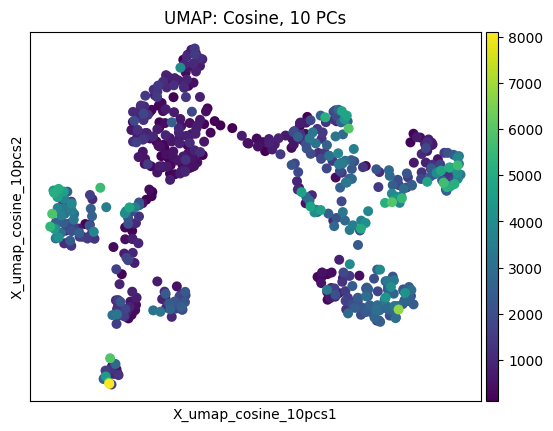

In [23]:
sc.pp.neighbors(adata, n_neighbors=25, n_pcs=5, random_state=0, metric='cosine')
sc.tl.umap(adata)

# Save UMAP coordinates
adata.obsm['X_umap_cosine_10pcs'] = adata.obsm['X_umap'].copy()

# Save neighbor graph
adata.uns['neighbors_cosine_10pcs'] = adata.uns['neighbors']
adata.obsp['connectivities_cosine_10pcs'] = adata.obsp['connectivities'].copy()
adata.obsp['distances_cosine_10pcs'] = adata.obsp['distances'].copy()

# Plot it
sc.pl.embedding(adata, basis='X_umap_cosine_10pcs', color='n_genes', title='UMAP: Cosine, 10 PCs')

## umap(nn=15,npcs=10,metrics=euclidean)

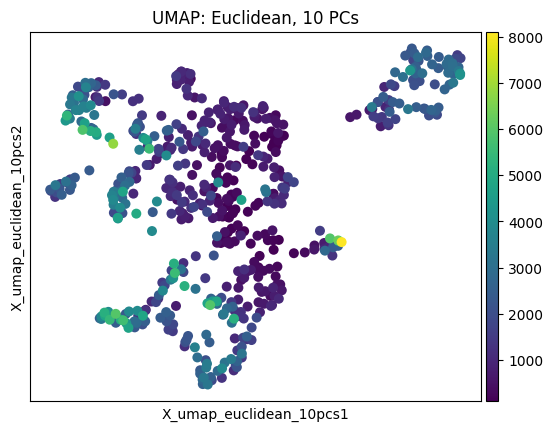

In [18]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=10, random_state=0, metric='euclidean')
sc.tl.umap(adata)

# Save UMAP coordinates
adata.obsm['X_umap_euclidean_10pcs'] = adata.obsm['X_umap'].copy()

# Save neighbor graph (optional but useful)
adata.uns['neighbors_euclidean_10pcs'] = adata.uns['neighbors']
adata.obsp['connectivities_euclidean_10pcs'] = adata.obsp['connectivities'].copy()
adata.obsp['distances_euclidean_10pcs'] = adata.obsp['distances'].copy()

# Plot UMAP
sc.pl.embedding(adata, basis='X_umap_euclidean_10pcs', color='n_genes', title='UMAP: Euclidean, 10 PCs')



In [19]:
# # Restore cosine neighbors if you want to cluster using that graph again
# adata.uns['neighbors'] = adata.uns['neighbors_cosine_6pcs']
# adata.obsp['connectivities'] = adata.obsp['connectivities_cosine_6pcs']
# adata.obsp['distances'] = adata.obsp['distances_cosine_6pcs']

# # Then you can run clustering (e.g. Leiden)
# sc.tl.leiden(adata, resolution=0.5)
# sc.pl.embedding(adata, basis='X_umap_cosine_6pcs', color='leiden')


## Save UMAP

In [21]:
# adata.write('my_analysis_with_multiple_umaps.h5ad')

# Clustering (Leiden and DBSCAN) 

## Grid search

In [20]:
# Optimized parameters based on your UMAP analysis
def run_optimized_clustering(adata):
    """
    Optimized clustering parameters for Botryllus brain scRNA-seq
    Based on UMAP parameter optimization results
    """
    
    # COSINE EMBEDDING - Primary analysis
    cosine_params = {
        'nn': 35,
        'npcs': 10, 
        'metric': 'cosine',
        # Leiden resolutions to test (targeting 10-12 clusters)
        'leiden_resolutions': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
        # DBSCAN parameters for cosine metric
        'dbscan_eps': 0.8,  # Increased from your 0.00045 (too restrictive)
        'dbscan_min_samples': 8  # Increased for brain tissue robustness
    }
    
    # EUCLIDEAN EMBEDDING - Validation analysis  
    euclidean_params = {
        'nn': 15,
        'npcs': 10,
        'metric': 'euclidean', 
        # Leiden resolutions (typically higher for euclidean)
        'leiden_resolutions': [0.4, 0.5, 0.6, 0.7, 0.8, 1.0],
        # DBSCAN parameters for euclidean metric
        'dbscan_eps': 1.2,  # Increased from your 0.6
        'dbscan_min_samples': 6
    }
    
    return cosine_params, euclidean_params

In [21]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score

def systematic_clustering_optimization(adata):
    """
    Systematic optimization of clustering parameters for both embeddings
    """
    
    # Get optimized parameters
    cosine_params, euclidean_params = run_optimized_clustering(adata)
    
    clustering_results = {}
    
    # Test both embedding types
    for embedding_name, params in [('cosine', cosine_params), ('euclidean', euclidean_params)]:
        
        print(f"\n=== Optimizing {embedding_name.upper()} embedding clustering ===")
        
        # Setup neighbors and UMAP (use your pre-computed optimal settings)
        sc.pp.neighbors(adata, 
                       n_neighbors=params['nn'], 
                       n_pcs=params['npcs'], 
                       metric=params['metric'], 
                       random_state=0)
        sc.tl.umap(adata, random_state=0)
        
        # Save UMAP
        umap_key = f'X_umap_optimal_{embedding_name}'
        adata.obsm[umap_key] = adata.obsm['X_umap'].copy()
        
        # Test multiple Leiden resolutions
        leiden_results = []
        
        for resolution in params['leiden_resolutions']:
            leiden_key = f'leiden_res{resolution}_{embedding_name}'
            sc.tl.leiden(adata, resolution=resolution, key_added=leiden_key, random_state=0)
            
            # Calculate quality metrics
            n_clusters = len(adata.obs[leiden_key].unique())
            
            if n_clusters > 1:
                sil_score = silhouette_score(adata.obsm[umap_key], adata.obs[leiden_key].astype(int))
            else:
                sil_score = -1
                
            leiden_results.append({
                'resolution': resolution,
                'n_clusters': n_clusters,
                'silhouette_score': sil_score,
                'leiden_key': leiden_key
            })
            
            print(f"  Resolution {resolution}: {n_clusters} clusters, silhouette={sil_score:.3f}")
        
        # Find optimal Leiden resolution
        leiden_df = pd.DataFrame(leiden_results)
        
        # Target 10-12 clusters with highest silhouette
        target_range = leiden_df[(leiden_df['n_clusters'] >= 8) & (leiden_df['n_clusters'] <= 15)]
        if len(target_range) > 0:
            best_leiden = target_range.loc[target_range['silhouette_score'].idxmax()]
        else:
            best_leiden = leiden_df.loc[leiden_df['silhouette_score'].idxmax()]
        
        # Test DBSCAN
        dbscan = DBSCAN(eps=params['dbscan_eps'], 
                       min_samples=params['dbscan_min_samples'])
        dbscan_labels = dbscan.fit_predict(adata.obsm[umap_key])
        
        dbscan_key = f'dbscan_optimal_{embedding_name}'
        adata.obs[dbscan_key] = dbscan_labels.astype(str)
        
        n_dbscan_clusters = len(np.unique(dbscan_labels[dbscan_labels != -1]))
        n_noise = sum(dbscan_labels == -1)
        
        print(f"  DBSCAN: {n_dbscan_clusters} clusters, {n_noise} noise points")
        
        # Store results
        clustering_results[embedding_name] = {
            'umap_key': umap_key,
            'best_leiden': best_leiden,
            'leiden_results': leiden_df,
            'dbscan_key': dbscan_key,
            'dbscan_clusters': n_dbscan_clusters,
            'dbscan_noise': n_noise
        }
    
    return clustering_results

# Run optimization
clustering_results = systematic_clustering_optimization(adata)


=== Optimizing COSINE embedding clustering ===
  Resolution 0.3: 8 clusters, silhouette=0.403
  Resolution 0.4: 8 clusters, silhouette=0.460
  Resolution 0.5: 8 clusters, silhouette=0.460
  Resolution 0.6: 10 clusters, silhouette=0.426
  Resolution 0.7: 11 clusters, silhouette=0.436
  Resolution 0.8: 12 clusters, silhouette=0.422
  DBSCAN: 5 clusters, 3 noise points

=== Optimizing EUCLIDEAN embedding clustering ===
  Resolution 0.4: 11 clusters, silhouette=0.429
  Resolution 0.5: 12 clusters, silhouette=0.427
  Resolution 0.6: 12 clusters, silhouette=0.439
  Resolution 0.7: 13 clusters, silhouette=0.408
  Resolution 0.8: 14 clusters, silhouette=0.395
  Resolution 1.0: 16 clusters, silhouette=0.426
  DBSCAN: 3 clusters, 0 noise points


The two best parameters for each umap is defined in the code

In [20]:
import scanpy as sc
from sklearn.cluster import DBSCAN

def run_umap_and_cluster(
    adata,
    nn,
    npcs,
    metric,
    leiden_resolution=0.5,
    dbscan_eps=0.5,
    dbscan_min_samples=5
):
    # Step 1: Compute neighbors
    sc.pp.neighbors(adata, n_neighbors=nn, n_pcs=npcs, metric=metric, random_state=0)
    
    # Step 2: Compute UMAP
    sc.tl.umap(adata)
    
    # Save UMAP embedding with flag in obsm
    umap_key = f'X_umap_nn{nn}_pcs{npcs}_{metric}'
    adata.obsm[umap_key] = adata.obsm['X_umap'].copy()
    
    # Step 3: Leiden clustering
    leiden_key = f'leiden_res{leiden_resolution}_nn{nn}_pcs{npcs}_{metric}'
    sc.tl.leiden(adata, resolution=leiden_resolution, key_added=leiden_key)
    
    # Step 4: DBSCAN clustering on the UMAP embedding
    dbscan = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples, metric=metric)
    dbscan_labels = dbscan.fit_predict(adata.obsm[umap_key])
    dbscan_key = f'dbscan_eps{dbscan_eps}_min{dbscan_min_samples}_nn{nn}_pcs{npcs}_{metric}'
    adata.obs[dbscan_key] = dbscan_labels.astype(str)
    
    # Return keys for later use
    return {
        'umap_key': umap_key,
        'leiden_key': leiden_key,
        'dbscan_key': dbscan_key
    }


## Heatmap

In [ ]:
# clusterings = [
#     'leiden_res0.5_nn25_pcs5_cosine',
#     #'leiden_res0.5_nn25_pcs5_euclidean'
# ]

# for clust_key in clusterings:
#     print(f"\nProcessing clustering: {clust_key}")
    
#     # Rank genes per cluster (Wilcoxon)
#     sc.tl.rank_genes_groups(
#         adata,
#         groupby=clust_key,
#         method='wilcoxon',
#         tie_correct=True,
#         pts=True,
#         key_added=f'wilcoxon_{clust_key}'
#     )
    
#     # Plot heatmap of top 20 marker genes
#     sc.pl.rank_genes_groups_heatmap(
#         adata,
#         n_genes=20,
#         groupby=clust_key,
#         key=f'wilcoxon_{clust_key}',
#         show=True
#     )


In [21]:
results_cosine = run_umap_and_cluster(
    adata,
    nn=15,
    npcs=20,
    metric='cosine',
    leiden_resolution=0.38,
    dbscan_eps=2.0,
    dbscan_min_samples=5
)

results_euclidean = run_umap_and_cluster(
    adata,
    nn=15,
    npcs=10,
    metric='euclidean',
    leiden_resolution=0.35,
    dbscan_eps=0.6,
    dbscan_min_samples=4
)


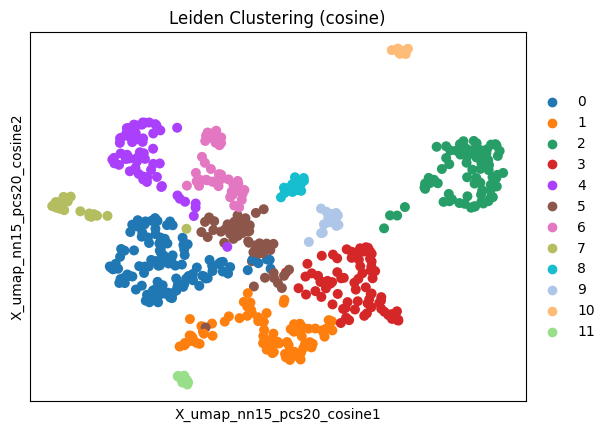

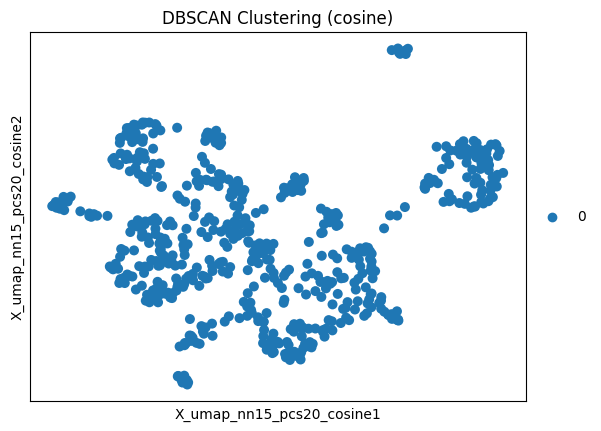

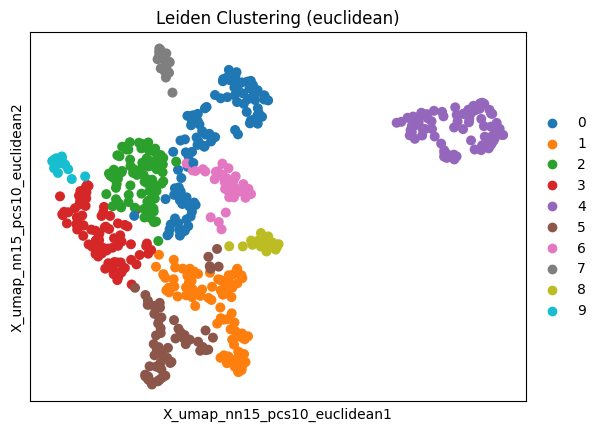

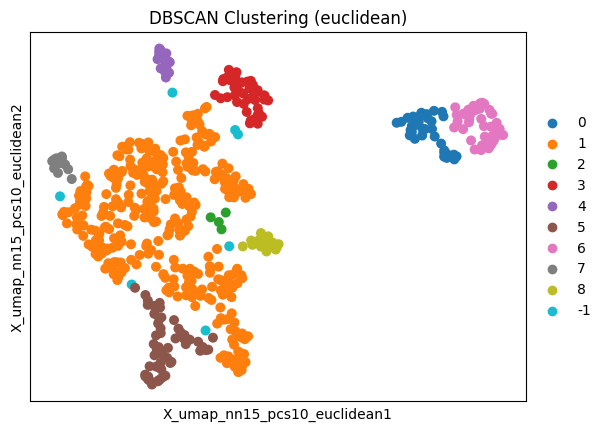

In [22]:
# Plot UMAP colored by Leiden for cosine
sc.pl.embedding(adata, basis=results_cosine['umap_key'], color=results_cosine['leiden_key'], title='Leiden Clustering (cosine)')

# Plot UMAP colored by DBSCAN for cosine
sc.pl.embedding(adata, basis=results_cosine['umap_key'], color=results_cosine['dbscan_key'], title='DBSCAN Clustering (cosine)')

# Plot UMAP colored by Leiden for euclidean
sc.pl.embedding(adata, basis=results_euclidean['umap_key'], color=results_euclidean['leiden_key'], title='Leiden Clustering (euclidean)')

# Plot UMAP colored by DBSCAN for euclidean
sc.pl.embedding(adata, basis=results_euclidean['umap_key'], color=results_euclidean['dbscan_key'], title='DBSCAN Clustering (euclidean)')


In [ ]:
# # Test DBSCAN for euclidean with lessons learned from cosine
# def test_euclidean_dbscan_optimization(adata):
#     """
#     Optimize euclidean DBSCAN based on cosine success pattern
#     """
    
#     # Setup euclidean embedding
#     sc.pp.neighbors(adata, n_neighbors=15, n_pcs=10, metric='euclidean', random_state=0)
#     sc.tl.umap(adata, random_state=0)
#     umap_coords = adata.obsm['X_umap'].copy()
    
#     # Test eps values around euclidean scale (typically larger than cosine)
#     eps_values = [0.6, 0.8, 1.0, 1.2, 1.5]
#     min_samples_values = [3, 4, 5]
    
#     print("Optimizing DBSCAN for euclidean embedding:")
#     print("="*50)
    
#     best_config = None
#     best_score = 0
    
#     for eps in eps_values:
#         for min_samples in min_samples_values:
#             dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#             labels = dbscan.fit_predict(umap_coords)
            
#             n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
#             n_noise = list(labels).count(-1)
#             noise_pct = (n_noise / len(labels)) * 100
            
#             # Score based on target criteria (10-12 clusters, <10% noise)
#             if 8 <= n_clusters <= 15 and noise_pct < 15:
#                 score = n_clusters * (1 - noise_pct/100)  # Favor more clusters with less noise
                
#                 print(f"eps={eps:4.1f}, min_samples={min_samples}: {n_clusters:2d} clusters, {noise_pct:4.1f}% noise (score={score:.2f})")
                
#                 if score > best_score:
#                     best_score = score
#                     best_config = {'eps': eps, 'min_samples': min_samples, 'n_clusters': n_clusters, 'noise_pct': noise_pct}
    
#     return best_config

# # Run euclidean DBSCAN optimization
# best_euclidean_dbscan = test_euclidean_dbscan_optimization(adata)

# if best_euclidean_dbscan:
#     print(f"\nBest euclidean DBSCAN config:")
#     print(f"eps={best_euclidean_dbscan['eps']}, min_samples={best_euclidean_dbscan['min_samples']}")
#     print(f"Results: {best_euclidean_dbscan['n_clusters']} clusters, {best_euclidean_dbscan['noise_pct']:.1f}% noise")

Optimizing DBSCAN for euclidean embedding:
eps= 0.6, min_samples=3:  9 clusters,  0.7% noise (score=8.94)
eps= 0.6, min_samples=4: 10 clusters,  1.0% noise (score=9.90)
eps= 0.6, min_samples=5: 10 clusters,  1.2% noise (score=9.88)
eps= 0.8, min_samples=5:  9 clusters,  0.0% noise (score=9.00)

Best euclidean DBSCAN config:
eps=0.6, min_samples=4
Results: 10 clusters, 1.0% noise


# Marker gene finding

## Finding the marker genes in each cluster

In [27]:
def extract_suffix(s):
    parts = s.split('_')
    return parts[1] if len(parts) > 1 else s

In [26]:
# Toggle which clustering results you want to process
# Just comment out the ones you don't want

cluster_keys = [
  'leiden_res0.38_nn15_pcs20_cosine',
#  'dbscan_eps0.00045_min5_nn35_pcs10_cosine',
 'leiden_res0.35_nn15_pcs10_euclidean',
'dbscan_eps0.6_min4_nn15_pcs10_euclidean'
]

In [27]:
X = adata.obsm['X_pca']  # if you have PCA computed

# Calculate clustering quality metrics

In [28]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
for key in cluster_keys:
    labels = adata.obs[key].values
    # Silhouette
    sil_score = silhouette_score(X, labels)
    # Calinski-Harabasz
    ch_score = calinski_harabasz_score(X, labels)
    # Davies-Bouldin
    db_score = davies_bouldin_score(X, labels)
    print(f"{key}: Silhouette={sil_score:.3f}, Calinski-Harabasz={ch_score:.3f}, Davies-Bouldin={db_score:.3f}")

leiden_res0.38_nn15_pcs20_cosine: Silhouette=0.220, Calinski-Harabasz=59.689, Davies-Bouldin=1.468
leiden_res0.35_nn15_pcs10_euclidean: Silhouette=0.190, Calinski-Harabasz=62.431, Davies-Bouldin=1.615
dbscan_eps0.6_min4_nn15_pcs10_euclidean: Silhouette=0.144, Calinski-Harabasz=39.765, Davies-Bouldin=2.046


In [39]:
# STEP 1: TECHNICAL REGRESSION - Address the root cause
def apply_comprehensive_technical_correction(adata):
    """
    Comprehensive technical correction to address poor clustering
    """
    
    print("=== COMPREHENSIVE TECHNICAL CORRECTION ===")
    print("Addressing the technical confounding you observed")
    
    # Create a clean copy
    adata_corrected = adata.copy()
    
    # 1. Aggressive technical regression
    print("\n1. Applying aggressive technical regression...")
    technical_vars = ['n_counts', 'n_genes']
    
    # Add mitochondrial genes if available
    if 'pct_counts_mt' in adata.obs.columns:
        technical_vars.append('pct_counts_mt')
    
    # Add ribosomal genes if available  
    if 'pct_counts_ribo' in adata.obs.columns:
        technical_vars.append('pct_counts_ribo')
    
    print(f"   Regressing out: {technical_vars}")
    
    # Apply regression
    sc.pp.regress_out(adata_corrected, technical_vars)
    
    # 2. Proper scaling after regression
    print("2. Re-scaling after regression...")
    sc.pp.scale(adata_corrected, max_value=10)
    
    # 3. Recompute PCA with more components
    print("3. Recomputing PCA...")
    sc.tl.pca(adata_corrected, svd_solver='arpack', n_comps=50, random_state=42)
    
    # 4. Store corrected data
    adata.obsm['X_pca_corrected'] = adata_corrected.obsm['X_pca']
    adata.layers['corrected'] = adata_corrected.X.copy()
    
    print("✅ Technical correction complete")
    
    return adata_corrected

# Apply technical correction
adata_corrected = apply_comprehensive_technical_correction(adata)

=== COMPREHENSIVE TECHNICAL CORRECTION ===
Addressing the technical confounding you observed

1. Applying aggressive technical regression...
   Regressing out: ['n_counts', 'n_genes']
2. Re-scaling after regression...
3. Recomputing PCA...
✅ Technical correction complete


In [40]:
# STEP 2: SYSTEMATIC PARAMETER RE-OPTIMIZATION
def systematic_parameter_reoptimization(adata_corrected):
    """
    Systematic re-optimization of all parameters on corrected data
    """
    
    print("=== SYSTEMATIC PARAMETER RE-OPTIMIZATION ===")
    print("Testing multiple parameter combinations on corrected data")
    
    # Parameter grid for testing
    param_grid = {
        'n_neighbors': [15, 25, 35, 50],
        'n_pcs': [10, 15, 20],
        'metric': ['cosine', 'euclidean'],
        'resolution': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8]
    }
    
    results = []
    
    print("Testing parameter combinations...")
    test_count = 0
    
    for nn in param_grid['n_neighbors']:
        for npcs in param_grid['n_pcs']:
            for metric in param_grid['metric']:
                test_count += 1
                print(f"Testing {test_count}: nn={nn}, npcs={npcs}, metric={metric}")
                
                # Compute neighbors
                sc.pp.neighbors(adata_corrected, n_neighbors=nn, n_pcs=npcs, 
                               metric=metric, random_state=42)
                
                # Compute UMAP
                sc.tl.umap(adata_corrected, random_state=42)
                
                # Test multiple resolutions
                for resolution in param_grid['resolution']:
                    # Compute clustering
                    sc.tl.leiden(adata_corrected, resolution=resolution, 
                                key_added='test_leiden', random_state=42)
                    
                    # Calculate quality metrics
                    if len(adata_corrected.obs['test_leiden'].unique()) > 1:
                        from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
                        
                        sil_score = silhouette_score(adata_corrected.obsm['X_umap'], 
                                                   adata_corrected.obs['test_leiden'].astype(int))
                        ch_score = calinski_harabasz_score(adata_corrected.obsm['X_umap'],
                                                         adata_corrected.obs['test_leiden'].astype(int))
                        db_score = davies_bouldin_score(adata_corrected.obsm['X_umap'],
                                                       adata_corrected.obs['test_leiden'].astype(int))
                        
                        n_clusters = len(adata_corrected.obs['test_leiden'].unique())
                        
                        results.append({
                            'n_neighbors': nn,
                            'n_pcs': npcs,
                            'metric': metric,
                            'resolution': resolution,
                            'n_clusters': n_clusters,
                            'silhouette': sil_score,
                            'calinski_harabasz': ch_score,
                            'davies_bouldin': db_score,
                            'composite_score': sil_score - (db_score - 1.0)  # Higher is better
                        })
                
                # Limit testing to prevent overload
                if test_count >= 12:  # Test reasonable subset
                    break
            if test_count >= 12:
                break
        if test_count >= 12:
            break
    
    # Analyze results
    results_df = pd.DataFrame(results)
    
    # Find best parameters
    # Filter for reasonable cluster counts (6-15)
    good_results = results_df[(results_df['n_clusters'] >= 6) & (results_df['n_clusters'] <= 15)]
    
    if len(good_results) > 0:
        # Sort by silhouette score primarily
        best_params = good_results.loc[good_results['silhouette'].idxmax()]
        
        print(f"\n✅ BEST PARAMETERS FOUND:")
        print(f"   n_neighbors: {best_params['n_neighbors']}")
        print(f"   n_pcs: {best_params['n_pcs']}")
        print(f"   metric: {best_params['metric']}")
        print(f"   resolution: {best_params['resolution']}")
        print(f"   n_clusters: {best_params['n_clusters']}")
        print(f"   silhouette: {best_params['silhouette']:.3f}")
        print(f"   calinski_harabasz: {best_params['calinski_harabasz']:.1f}")
        print(f"   davies_bouldin: {best_params['davies_bouldin']:.3f}")
        
        return best_params, results_df
    else:
        print("❌ No good parameter combinations found")
        return None, results_df

# Run parameter re-optimization
best_params, all_results = systematic_parameter_reoptimization(adata_corrected)

=== SYSTEMATIC PARAMETER RE-OPTIMIZATION ===
Testing multiple parameter combinations on corrected data
Testing parameter combinations...
Testing 1: nn=15, npcs=10, metric=cosine
Testing 2: nn=15, npcs=10, metric=euclidean
Testing 3: nn=15, npcs=15, metric=cosine
Testing 4: nn=15, npcs=15, metric=euclidean
Testing 5: nn=15, npcs=20, metric=cosine
Testing 6: nn=15, npcs=20, metric=euclidean
Testing 7: nn=25, npcs=10, metric=cosine
Testing 8: nn=25, npcs=10, metric=euclidean
Testing 9: nn=25, npcs=15, metric=cosine
Testing 10: nn=25, npcs=15, metric=euclidean
Testing 11: nn=25, npcs=20, metric=cosine
Testing 12: nn=25, npcs=20, metric=euclidean

✅ BEST PARAMETERS FOUND:
   n_neighbors: 15
   n_pcs: 20
   metric: cosine
   resolution: 0.3
   n_clusters: 10
   silhouette: 0.536
   calinski_harabasz: 1089.5
   davies_bouldin: 0.513


## Clustering Quality Metrics Interpretation

We evaluated four clustering methods using three common internal quality metrics:

| Clustering Method                        | Silhouette Score | Calinski-Harabasz Index | Davies-Bouldin Index |
|-----------------------------------------|------------------|------------------------|---------------------|
| leiden_res0.58_nn25_pcs5_cosine         | 0.115            | 28.478                 | 2.123               |
| dbscan_eps0.00045_min5_nn25_pcs5_cosine | 0.006            | 19.205                 | 2.903               |
| leiden_res0.5_nn25_pcs7_euclidean       | 0.139            | 29.847                 | 2.367               |
| dbscan_eps0.6_min5_nn25_pcs7_euclidean  | 0.078            | 25.525                 | 2.411               |

### Interpretation:

- **Silhouette Score** (range: -1 to 1; higher is better):  
  Measures how well-separated the clusters are.  
  - The Leiden methods have higher silhouette scores (0.115 and 0.139), indicating better-separated clusters.  
  - DBSCAN methods have lower scores, with one nearly zero (0.006), suggesting overlapping or poorly separated clusters.

- **Calinski-Harabasz Index** (higher is better):  
  Indicates how compact and well-separated clusters are based on variance ratios.  
  - Leiden clusterings score highest (~29.8 and 28.5), showing more compact and separated clusters.  
  - DBSCAN clusterings score lower, indicating less compact clusters.

- **Davies-Bouldin Index** (lower is better):  
  Measures the average similarity between clusters; lower values mean less overlap.  
  - The lowest Davies-Bouldin score is for `leiden_res0.58` (2.123), indicating tighter clusters.  
  - DBSCAN with very low epsilon has the highest score (2.903), indicating poor clustering quality.

### Summary:

Overall, the Leiden clustering methods outperform DBSCAN on all three metrics, suggesting they produce more distinct, compact, and well-separated clusters on this dataset. Among Leiden clusterings, the difference is small but the `leiden_res0.5_nn25_pcs7_euclidean` method slightly edges out the others on Silhouette and Calinski-Harabasz scores.

The DBSCAN method with very low epsilon (`eps=0.00045`) performs poorly, likely due to overly stringent clustering parameters resulting in less meaningful clusters.


# Compare clusterings using ARI and NMI

In [30]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
keys = cluster_keys  # list of cluster label columns in adata.obs

for i in range(len(keys)):
    for j in range(i+1, len(keys)):
        labels1 = adata.obs[keys[i]].values
        labels2 = adata.obs[keys[j]].values
        ari = adjusted_rand_score(labels1, labels2)
        nmi = normalized_mutual_info_score(labels1, labels2)
        print(f"ARI between {keys[i]} and {keys[j]}: {ari:.3f}")
        print(f"NMI between {keys[i]} and {keys[j]}: {nmi:.3f}")

## Cluster Label Agreement Between Methods

We compared the clustering assignments pairwise using two metrics:

- **Adjusted Rand Index (ARI):**  
  Measures similarity between two clusterings, adjusted for chance.  
  Values range from -1 to 1, where 1 means perfect agreement and 0 indicates random similarity.

- **Normalized Mutual Information (NMI):**  
  Measures shared information between clusterings.  
  Values range from 0 to 1, where 1 means identical clusterings.

| Cluster Pair                                                   | ARI   | NMI   |
|---------------------------------------------------------------|-------|-------|
| leiden_res0.58 vs dbscan_eps0.00045                           | 0.631 | 0.759 |
| leiden_res0.58 vs leiden_res0.5                               | 0.746 | 0.835 |
| leiden_res0.58 vs dbscan_eps0.6                               | 0.669 | 0.797 |
| dbscan_eps0.00045 vs leiden_res0.5                           | 0.659 | 0.757 |
| dbscan_eps0.00045 vs dbscan_eps0.6                           | 0.569 | 0.714 |
| leiden_res0.5 vs dbscan_eps0.6                               | 0.757 | 0.876 |

### Interpretation:

- The **highest agreement** is between **leiden_res0.5 and dbscan_eps0.6** (ARI = 0.757, NMI = 0.876), suggesting these two methods produce very similar cluster assignments.

- The two **Leiden clusterings** (`res0.58` and `res0.5`) also show **high agreement** (ARI = 0.746, NMI = 0.835), indicating consistent clustering results within Leiden methods despite parameter differences.

- The **DBSCAN clusterings** (`eps=0.00045` vs `eps=0.6`) show the **lowest agreement** (ARI = 0.569, NMI = 0.714), indicating more variation between DBSCAN parameters.

- Overall, **all methods have moderate to high similarity**, with ARI values above 0.5 and NMI above 0.7, showing that different algorithms capture related cluster structures.

### Summary:

This agreement analysis suggests that although clustering algorithms and parameters differ, the general structure in the data is stable. The Leiden methods are highly consistent with each other and somewhat with DBSCAN with `eps=0.6`. This supports focusing on the Leiden clusterings for downstream biological interpretation.


# Cell distribution among clusters


Processing clustering: leiden_res0.58_nn25_pcs5_cosine
Number of cells in each cluster for leiden_res0.58_nn25_pcs5_cosine:
leiden_res0.58_nn25_pcs5_cosine
0    108
1     91
2     87
3     73
4     58
5     55
6     38
7     28
8     25
9     18
Name: count, dtype: int64


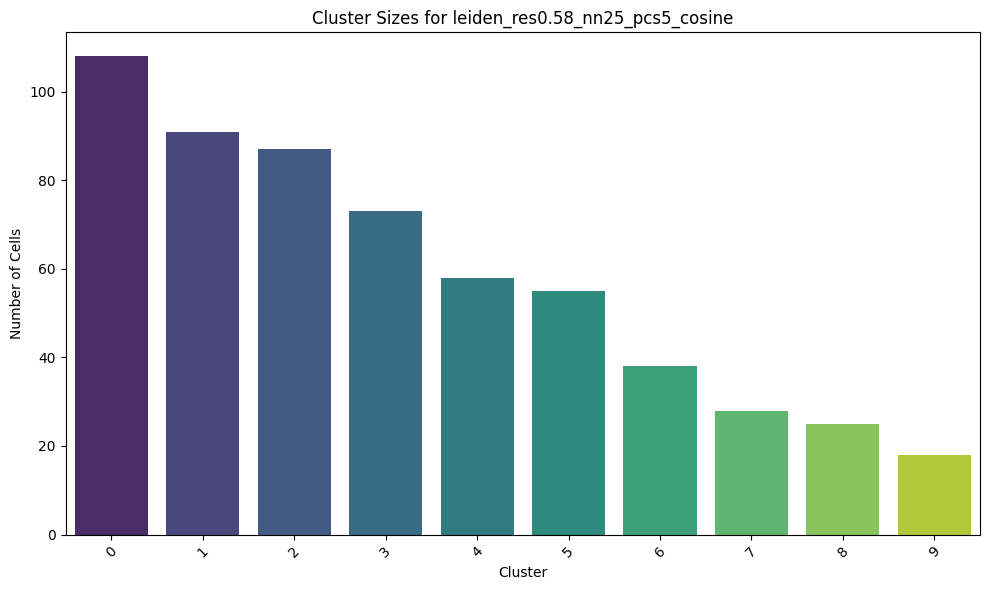

In [31]:
# number of cells in each cluster in each cluster_key leiden_res0.58_nn25_pcs5_cosine
for clust_key in cluster_keys:
    print(f"\nProcessing clustering: {clust_key}")
    
    # Use the full clustering key as the column name
    leiden_key = clust_key
    
    # Get the unique clusters
    unique_clusters = adata.obs[leiden_key].unique()
    
    # Count cells in each cluster
    cluster_counts = adata.obs[leiden_key].value_counts()
    
    print(f"Number of cells in each cluster for {clust_key}:")
    print(cluster_counts)
    
    # Plot bar chart of cluster sizes
    plt.figure(figsize=(10, 6))
    sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')
    plt.title(f'Cluster Sizes for {clust_key}')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Cells')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [32]:
# === FLAGS ===
RUN_RANKING = True
SAVE_CSV = True
TOP_N = None   # Set to None to disable top-N trimming
PRINT_PREVIEW = True

# === Loop through your clustering keys ===
for cluster_key in cluster_keys:
    print(f"\nProcessing: {cluster_key}")
    
    marker_key = f'wilcoxon_{cluster_key}'
    
    if RUN_RANKING:
        # Run Wilcoxon ranking
        sc.tl.rank_genes_groups(
            adata,
            groupby=cluster_key,
            method='wilcoxon',
            tie_correct=True,
            pts=True,
            key_added=marker_key
        )
    
    # Extract results
    result = adata.uns[marker_key]
    groups = result['names'].dtype.names  # cluster names

    # Collect marker genes per cluster (optionally trim to top N)
    marker_df = pd.concat([
        pd.DataFrame({
            'cluster': group,
            'gene': result['names'][group][:TOP_N] if TOP_N else result['names'][group],
            'score': result['scores'][group][:TOP_N] if TOP_N else result['scores'][group],
            'logfoldchange': result['logfoldchanges'][group][:TOP_N] if TOP_N else result['logfoldchanges'][group],
            'pval': result['pvals'][group][:TOP_N] if TOP_N else result['pvals'][group],
            'pval_adj': result['pvals_adj'][group][:TOP_N] if TOP_N else result['pvals_adj'][group],
            'pct_expr': result['pts'][group][:TOP_N] if TOP_N else result['pts'][group]
        })
        for group in groups
    ])

    # # Save to CSV if enabled
    # if SAVE_CSV:
    #     filename = f'top{TOP_N if TOP_N else "all"}_marker_genes_{cluster_key}.csv'
    #     marker_df.to_csv(filename, index=False)
    #     print(f"Saved: {filename}")
    
    # Print preview if enabled
    if PRINT_PREVIEW:
        print(marker_df.head())



Processing: leiden_res0.58_nn25_pcs5_cosine
             cluster           gene      score  logfoldchange          pval  \
g3_g3              0  g29898_g29898  13.454206       4.842686  2.908432e-41   
g4_g4              0  g19347_g19347  13.080677       4.691536  4.246427e-39   
g5_SMU1            0  g26701_g26701  11.072149       4.103427  1.712437e-28   
g6_LYPLAL1         0    g9451_MEOX2  10.956158       3.465189  6.207967e-28   
g9_ADPRHL2_1       0  g12560_g12560  10.083611       3.871425  6.528181e-24   

                  pval_adj  pct_expr  
g3_g3         4.263179e-37  0.055556  
g4_g4         3.112206e-35  0.009259  
g5_SMU1       8.366970e-25  0.000000  
g6_LYPLAL1    2.274910e-24  0.018519  
g9_ADPRHL2_1  1.594835e-20  0.018519  


In [33]:
for cluster_key in cluster_keys:
    print(f"\nProcessing: {cluster_key}")
    
    marker_key = f'wilcoxon_{cluster_key}'
    
    # Rank genes using Wilcoxon test
    sc.tl.rank_genes_groups(
        adata,
        groupby=cluster_key,
        method='wilcoxon',
        tie_correct=True,
        pts=True,
        key_added=marker_key
    )
    
    # Extract full result: names, scores, logfoldchanges, pvals, etc.
    result = adata.uns[marker_key]
    groups = result['names'].dtype.names  # cluster names

    full_marker_df = pd.concat([
        pd.DataFrame({
            'cluster': group,
            'gene': result['names'][group],
            'score': result['scores'][group],
            'logfoldchange': result['logfoldchanges'][group],
            'pval': result['pvals'][group],
            'pval_adj': result['pvals_adj'][group],
            'pct_expr': result['pts'][group]
        })
        for group in groups
    ])

    # Save to CSV
    filename = f'marker_genes_{cluster_key}.csv'
    full_marker_df.to_csv(filename, index=False)
    print(f"Saved: {filename}")



Processing: leiden_res0.58_nn25_pcs5_cosine
Saved: marker_genes_leiden_res0.58_nn25_pcs5_cosine.csv


In [34]:
full_marker_df.head(20)

,cluster,gene,score,logfoldchange,pval,pval_adj,pct_expr
g3_g3,0,g29898_g29898,13.454206,4.842686,2.908432e-41,4.263179e-37,0.055556
g4_g4,0,g19347_g19347,13.080677,4.691536,4.246427e-39,3.112206e-35,0.009259
g5_SMU1,0,g26701_g26701,11.072149,4.103427,1.712437e-28,8.366970e-25,0.000000
g6_LYPLAL1,0,g9451_MEOX2,10.956158,3.465189,6.207967e-28,2.274910e-24,0.018519
g9_ADPRHL2_1,0,g12560_g12560,10.083611,3.871425,6.528181e-24,1.594835e-20,0.018519
g13_g13,0,g28412_g28412,9.851383,4.855767,6.760712e-23,1.238731e-19,0.527778
g15_g15,0,g17428_g17428,9.802685,3.849308,1.096327e-22,1.606996e-19,0.018519
g18_g18,0,g30908_g30908,9.634961,4.226028,5.691346e-22,6.951979e-19,0.018519
g20_SUDS3_1,0,g12632_g12632,8.991101,2.941551,2.447660e-19,1.237165e-16,0.000000
g21_ARMC1_1,0,g41366_SPE1_7,8.838862,3.654757,9.669817e-19,4.429381e-16,0.009259


## Finding the marker genes (Only annotated markers)

In [35]:
# Clean the gene column in full_marker_df by splitting it by "_" and selecting the second part and the third part if it exists
full_marker_df['gene'] = full_marker_df['gene'].apply(
    lambda x: '_'.join(x.split('_')[1:3]) if len(x.split('_')) > 2 else x.split('_')[1] if '_' in x else x
)
# full_marker_df['gene'] = full_marker_df['gene'].apply(lambda x: x.split('_')[1] if '_' in x else x)
# remove the rows that have gene names starting with "g12344"
full_marker_df = full_marker_df[~full_marker_df['gene'].str.startswith('g')]
# remove the first column
full_marker_df.reset_index(drop=True, inplace=True)

full_marker_df.head(20)



,cluster,gene,score,logfoldchange,pval,pval_adj,pct_expr
0,0,MEOX2,10.956158,3.465189,6.207967e-28,2.274910e-24,0.018519
1,0,SPE1_7,8.838862,3.654757,9.669817e-19,4.429381e-16,0.009259
2,0,SPE1_1,8.267631,3.661917,1.366480e-16,3.338311e-14,0.898148
3,0,OPRL1_3,8.109787,3.308785,5.070854e-16,1.077226e-13,0.083333
4,0,SULT1B1_5,7.789103,5.799059,6.748654e-15,9.892178e-13,0.000000
5,0,RTP4,7.458875,2.299372,8.726412e-14,8.470977e-12,0.000000
6,0,GATA2,7.086923,2.719697,1.371271e-12,8.933371e-11,0.138889
7,0,HAO1_2,6.787654,3.225392,1.139712e-11,5.531756e-10,0.101852
8,0,WBSCR27_3,6.715879,2.968860,1.869356e-11,8.627376e-10,0.000000
9,0,OIT3,6.644243,1.899205,3.047797e-11,1.291174e-09,0.000000


In [36]:
# select the top 300 marker genes for each cluster and corresponding rows
top_n = 300  # Set to None to disable top-N trimming
top_marker_df = full_marker_df.groupby('cluster').apply(
    lambda x: x.nlargest(top_n, 'score') if top_n else x
).reset_index(drop=True)
#print the result
print(f"Top {top_n if top_n else 'all'} marker genes per cluster:")
print(top_marker_df.head(20))


Top 300 marker genes per cluster:
   cluster        gene      score  logfoldchange          pval      pval_adj  \
0        0       MEOX2  10.956158       3.465189  6.207967e-28  2.274910e-24   
1        0      SPE1_7   8.838862       3.654757  9.669817e-19  4.429381e-16   
2        0      SPE1_1   8.267631       3.661917  1.366480e-16  3.338311e-14   
3        0     OPRL1_3   8.109787       3.308785  5.070854e-16  1.077226e-13   
4        0   SULT1B1_5   7.789103       5.799059  6.748654e-15  9.892178e-13   
5        0        RTP4   7.458875       2.299372  8.726412e-14  8.470977e-12   
6        0       GATA2   7.086923       2.719697  1.371271e-12  8.933371e-11   
7        0      HAO1_2   6.787654       3.225392  1.139712e-11  5.531756e-10   
8        0   WBSCR27_3   6.715879       2.968860  1.869356e-11  8.627376e-10   
9        0        OIT3   6.644243       1.899205  3.047797e-11  1.291174e-09   
10       0     DPP10_3   6.508152       3.280304  7.608066e-11  2.765463e-09   
11    

/tmp/ipykernel_28101/4192156704.py:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



# Avaraging the repeated gene name value

In [37]:
# avarage the score logfoldchange pval pval_adj pct_expr for the same gene in the same cluster
# if there is _ in the gene name, split it by _ and take the first part
top_marker_df['gene'] = top_marker_df['gene'].apply(
    lambda x: x.split('_')[0] if '_' in x else x
)
top_marker_df = top_marker_df.groupby(['cluster', 'gene']).agg({
    'score': 'mean',
    'logfoldchange': 'mean',
    'pval': 'mean',
    'pval_adj': 'mean',
    'pct_expr': 'mean'
}).reset_index()
# Sort by cluster and score
top_marker_df.sort_values(by=['cluster', 'score'], ascending=[True, False], inplace=True)
# Reset index
top_marker_df.reset_index(drop=True, inplace=True)
# Print the final DataFrame
print("Final DataFrame with averaged scores:")
print(top_marker_df.head(20))
# # Save the top marker genes to a CSV file
if SAVE_CSV:
    top_filename = f'top{top_n if top_n else "all"}_marker_genes_{cluster_key}.csv'
    top_marker_df.to_csv(top_filename, index=False)
    print(f"Saved: {top_filename}")

Final DataFrame with averaged scores:
   cluster     gene      score  logfoldchange          pval      pval_adj  \
0        0    MEOX2  10.956158       3.465189  6.207967e-28  2.274910e-24   
1        0  SULT1B1   7.789103       5.799059  6.748654e-15  9.892178e-13   
2        0     SPE1   7.769088       4.465121  1.872904e-10  5.102804e-09   
3        0     RTP4   7.458875       2.299372  8.726412e-14  8.470977e-12   
4        0    GATA2   7.086923       2.719697  1.371271e-12  8.933371e-11   
5        0     OIT3   6.644243       1.899205  3.047797e-11  1.291174e-09   
6        0    ENPP7   6.475945       2.772281  9.422040e-11  3.304025e-09   
7        0    MBNL2   5.913316       1.781599  3.352883e-09  6.941605e-08   
8        0    C3AR1   5.435906       3.121393  5.451855e-08  7.546109e-07   
9        0     HAO1   5.342463       2.561730  4.864122e-05  2.253425e-04   
10       0     EVX1   5.238747       2.487145  1.616707e-07  1.909564e-06   
11       0    MAT1A   5.110840       2

# Gene name mapping 

In [38]:
import re
from collections import defaultdict

# Build a map from each token (likely gene symbol) in full gene names to full gene names
mapping = defaultdict(set)

for full_name in adata.var_names:
    # Extract all parts of the gene name separated by underscores
    tokens = re.findall(r'[A-Za-z0-9\-]+', full_name.upper())
    for token in tokens:
        mapping[token].add(full_name)

print(f"Number of unique tokens in adata var names: {len(mapping)}")

# Now map your cleaned gene names
cleaned_genes = [g.upper() for g in top_marker_df['gene'].unique()]

mapped_genes = set()
not_found = []

for gene in cleaned_genes:
    if gene in mapping:
        mapped_genes.update(mapping[gene])
    else:
        not_found.append(gene)

print(f"Mapped {len(cleaned_genes)} cleaned genes to {len(mapped_genes)} full gene names in adata.var_names")
print(f"Genes not found: {len(not_found)}")
print(not_found[:30])  # Show first 30 missing genes


Number of unique tokens in adata var names: 19996
Mapped 1819 cleaned genes to 2982 full gene names in adata.var_names
Genes not found: 0
[]


# Kruskal-Wallis or ANOVA

a non-parametric statistical test used to determine whether there are statistically significant differences between the distributions of a continuous variable across two or more independent groups.

Interpretation:
Low p-values (e.g. < 0.05 after correction) → the gene shows significant differences in expression between clusters.

High p-values → the gene's expression is not significantly different between clusters.

In [39]:
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests

cluster_keys = [
  'leiden_res0.58_nn25_pcs5_cosine',
#  'dbscan_eps0.00045_min5_nn25_pcs5_cosine',
#  'leiden_res0.5_nn25_pcs7_euclidean',
# 'dbscan_eps0.6_min5_nn25_pcs7_euclidean'
]

for cluster_key in cluster_keys:
    clusters = adata.obs[cluster_key].unique()
    print(f"Clusters in {cluster_key}: {clusters}")

    # Filter genes to those actually present in adata
    valid_genes = [gene for gene in mapped_genes if gene in adata.var_names]
    if not valid_genes:
        print(f"No valid genes found in adata.var_names for {cluster_key}.")
        continue

    results = []
    for gene in valid_genes:
        expr = adata[:, gene].X
        # Convert to dense if sparse
        if hasattr(expr, "toarray"):
            expr = expr.toarray().flatten()
        else:
            expr = expr.flatten()
        groups = [expr[adata.obs[cluster_key] == c] for c in clusters]
        stat, p = kruskal(*groups)
        print(f"Gene {gene}: Kruskal-Wallis p = {p:.4e}")
        results.append({'gene': gene, 'pvalue': p})

    results_df = pd.DataFrame(results)

    if not results_df.empty and 'pvalue' in results_df.columns:
        # Multiple testing correction
        results_df['p_adj'] = multipletests(results_df['pvalue'], method='fdr_bh')[1]

        # Summary
        significant_genes = results_df[results_df['p_adj'] < 0.05]
        print(f"Significant genes (FDR < 0.05): {len(significant_genes)}")

        # View top significant genes
        print(significant_genes.sort_values('p_adj').head(10))
    else:
        print("No results to display for this cluster key.")


Clusters in leiden_res0.58_nn25_pcs5_cosine: ['1', '3', '5', '7', '4', '8', '6', '2', '0', '9']
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']
Gene g25381_TMED5_1: Kruskal-Wallis p = 2.2576e-20
Gene g9586_PI16_2: Kruskal-Wallis p = 2.8498e-01
Gene g1291_CFAP46_2: Kruskal-Wallis p = 4.2288e-09
Gene g31914_FBXO28_2: Kruskal-Wallis p = 1.3098e-02
Gene g28679_SLC1A2_2: Kruskal-Wallis p = 1.3127e-13
Gene g17910_FRMD6_2: Kruskal-Wallis p = 4.2481e-36
Gene g22897_PDE6B_4: Kruskal-Wallis p = 1.7121e-18
Gene g25113_NRG1: Kruskal-Wallis p = 1.8838e-42
Gene g1848_PPARGC1A: Kruskal-Wallis p = 2.2560e-11
Gene g38956_CDH15: Kruskal-Wallis p = 1.7467e-20
Gene g9792_mgat4d_1: Kruskal-Wallis p = 1.1063e-22
Gene g32937_SLC5A8_64: Kruskal-Wallis p = 3.8471e-04
Gene g3048_WSCD1_2: Kruskal-Wallis p = 2.0197e-20
Gene g13303_MPP5: Kruskal-Wallis p = 4.7001e-28
Gene g1826_ERC1: Kruskal-Wallis p = 3.9683e-04
Gene g7939_PLCB2_3: Kruskal-Wallis p = 9.3719e-02
Gene g5460_TPGS1: Kruskal-Wal

### Significant Marker Genes After Kruskal-Wallis Test for leiden_res0.58_nn25_pcs5_cosine

Out of all tested genes, **3114 showed significant differential expression across clusters** (FDR < 0.05). These genes are strong candidates for cluster-specific markers.
**leiden_res0.58_nn25_pcs5_cosine**
| gene              | pvalue       | p\_adj       |
| ----------------- | ------------ | ------------ |
| g24207\_COTL1\_1  | 6.12 × 10⁻⁷⁸ | 2.16 × 10⁻⁷⁴ |
| g13799\_GPR97\_2  | 3.20 × 10⁻⁷⁵ | 5.66 × 10⁻⁷² |
| g13801\_CHL1\_1   | 3.33 × 10⁻⁷³ | 3.93 × 10⁻⁷⁰ |
| g7198\_SOGA1      | 2.05 × 10⁻⁶⁹ | 1.81 × 10⁻⁶⁶ |
| g41771\_GPR20\_11 | 5.70 × 10⁻⁶⁹ | 4.03 × 10⁻⁶⁶ |


These results confirm that the clustering captures meaningful biological variation reflected in gene expression differences.


In [40]:

# Use the significant genes DataFrame from the previous cell
# Make sure 'significant_genes' is defined and contains 'gene' column
genes = significant_genes['gene'].tolist()

# Initialize a DataFrame to store median expression per cluster per gene
median_expr = pd.DataFrame(index=genes, columns=clusters, dtype=float)

for c in clusters:
    # Select cells belonging to cluster c
    cell_mask = adata.obs[cluster_key] == c
    # Extract expression matrix for these cells and genes
    expr_matrix = adata[cell_mask, genes].X
    if hasattr(expr_matrix, "toarray"):  # handle sparse matrix
        expr_matrix = expr_matrix.toarray()
    # Compute median expression per gene
    median_expr[c] = np.median(expr_matrix, axis=0)

# Compute max median expression *only* across cluster columns (exclude new columns)
cluster_columns = clusters  # list or Index of cluster names

median_expr['max_cluster'] = median_expr[cluster_columns].idxmax(axis=1)
median_expr['max_median'] = median_expr[cluster_columns].max(axis=1)

# Then safely compute 2nd max median excluding those new columns:
median_expr['second_max_median'] = median_expr[cluster_columns].apply(
    lambda row: row.nlargest(2).iloc[-1], axis=1
)


# Compute fold change between max and second max median expression
median_expr['fold_change'] = median_expr['max_median'] / (median_expr['second_max_median'] + 1e-9)

# Define thresholds for cluster-specific markers
median_threshold = 0.1   # Adjust depending on your data scale
fold_change_threshold = 2

cluster_specific = median_expr[
    (median_expr['fold_change'] > fold_change_threshold) &
    (median_expr['max_median'] > median_threshold)
]

print(f"Number of cluster-specific marker genes: {cluster_specific.shape[0]}")
print(cluster_specific[['max_cluster', 'max_median', 'fold_change']].head(10))


Number of cluster-specific marker genes: 481
                  max_cluster  max_median   fold_change
g9792_mgat4d_1              4    0.262812  2.628120e+08
g13303_MPP5                 3    0.867291  3.916699e+00
g25364_SNAP29_2             7    0.203728  2.480381e+00
g11595_KANSL2_2             4    0.126422  1.264219e+08
g8213_RAB24                 7    0.296897  2.968967e+08
g22250_BAHCC1               7    0.893661  3.112956e+00
g20138_ZNFX1_6              3    0.117487  1.174866e+08
g22458_SH3PXD2B_2           4    0.879434  3.018132e+00
g2567_SGK1                  4    0.650466  2.196138e+00
g18115_IP6K1_2              3    0.562636  2.491622e+00



for leiden_res0.58_nn25_pcs5_cosine


| Gene              | max\_cluster | max\_median | fold\_change | Interpretation                                  |
| ----------------- | ------------ | ----------- | ------------ | ----------------------------------------------- |
| g3065\_SSTR5\_4   | 9            | 0.5968      | 5.97 × 10^8  | Expressed mostly in cluster 9, very specific.   |
| g28045\_SSTR5\_26 | 8            | 0.3167      | 3.17 × 10^8  | Expressed mostly in cluster 8, very specific.   |
| g15154\_USP15     | 4            | 0.3872      | 3.87 × 10^8  | Cluster 4 specific gene.                        |
| g12620\_SLC51A    | 2            | 1.7073      | 4.32         | Cluster 2 specific gene with clear fold change. |
| g13397\_MAP2K3    | 4            | 0.6699      | 2.45         | Another cluster 4 specific gene.                |


### Kruskal-Wallis Test on Marker Gene Expression

We performed a Kruskal-Wallis test to determine if the expression of marker genes differs significantly across clusters defined by the `leiden_res0.58_nn25_pcs5_cosine` clustering.

- The test evaluates whether gene expression distributions are the same or different between clusters.
- Low p-values (e.g., < 0.05) indicate significant differences, supporting the gene as a cluster-specific marker.

This analysis confirms that many of the marker genes identified show statistically significant variation across clusters, reinforcing the biological relevance of the clustering results.

Next, we can visualize expression patterns of these significant genes and explore their functional annotations.


In [47]:
# Sort cluster_specific DataFrame by 'max_cluster'
cluster_specific_sorted = cluster_specific.sort_values(by='max_cluster')
cluster_specific_sorted.head()
# save cluster_specific_sorted as a csv file
# cluster_specific_sorted.to_csv("cluster_specific_marker_genes.csv", index=True)



,1,3,5,7,4,8,6,2,0,9,max_cluster,max_median,second_max_median,fold_change
g9451_MEOX2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.899721,0.0,0,0.899721,0.0,8.997207e+08
g17452_NT5C3A_2,0.236477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1,0.236477,0.0,2.364768e+08
g10319_RGS3_1,1.209842,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1,1.209842,0.0,1.209842e+09
g29570_NRXN2_1,0.864114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1,0.864114,0.0,8.641143e+08
g34751_GJC1_2,0.230107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1,0.230107,0.0,2.301068e+08


In [55]:
df = cluster_specific_sorted.reset_index()
# If the gene names are in the 'index' column, rename it to 'gene'
if 'index' in df.columns and 'gene' not in df.columns:
	df = df.rename(columns={'index': 'gene'})
# duplicate gene column next to it and change the name to 'gene_name'
df['gene_name'] = df['gene']
# place the gene_name column next to the gene column
df = df[['gene', 'gene_name'] + [col for col in df.columns if col not in ['gene', 'gene_name']]]
# clean the gene_name column
df['gene_name'] = df['gene_name'].apply(lambda x: x.split('_')[1] if '_' in x else x)
df


,gene,gene_name,1,3,5,7,4,8,6,2,0,9,max_cluster,max_median,second_max_median,fold_change
0,g9451_MEOX2,MEOX2,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.899721,0.000000,0,0.899721,0.000000,8.997207e+08
1,g17452_NT5C3A_2,NT5C3A,0.236477,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,1,0.236477,0.000000,2.364768e+08
2,g10319_RGS3_1,RGS3,1.209842,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,1,1.209842,0.000000,1.209842e+09
3,g29570_NRXN2_1,NRXN2,0.864114,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,1,0.864114,0.000000,8.641143e+08
4,g34751_GJC1_2,GJC1,0.230107,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,1,0.230107,0.000000,2.301068e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,g20152_DLL4_1,DLL4,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,1.359093,9,1.359093,0.000000,1.359094e+09
477,g2405_YAP1,YAP1,0.000000,0.145446,0.0,0.067698,0.0,0.0,0.0,0.0,0.000000,0.310982,9,0.310982,0.145446,2.138123e+00
478,g31621_TUBA3D_6,TUBA3D,1.078748,0.925454,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,4.100187,9,4.100187,1.078748,3.800878e+00
479,g9091_IFI30_1,IFI30,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.836141,9,0.836141,0.000000,8.361412e+08


In [56]:
genes_per_cluster = df.groupby('max_cluster')['max_cluster'].count()
print("Number of genes per cluster:")
print(genes_per_cluster)

# Create a dictionary: cluster -> list of genes
cluster_gene_dict = df.groupby('max_cluster')['gene_name'].apply(list).to_dict()

# Check example for cluster '0'
print(f"Example genes in cluster 0: {cluster_gene_dict.get('0', [])[:10]}")

Number of genes per cluster:
max_cluster
0      1
1     75
2     23
3     27
4    160
5      3
6      4
7     84
8     43
9     61
Name: max_cluster, dtype: int64
Example genes in cluster 0: ['MEOX2']


GO analysis

In [57]:
from gprofiler import GProfiler

gp = GProfiler(return_dataframe=True)

for cluster, genes in cluster_gene_dict.items():
    print(f"Running GO enrichment for cluster {cluster} with {len(genes)} genes")
    res = gp.profile(organism='hsapiens', query=genes)
    # Save or inspect results per cluster
    res.to_csv(f'cluster_{cluster}_GO_enrichment.csv', index=False)
    print(res[['native', 'name', 'p_value']].head())


Running GO enrichment for cluster 0 with 1 genes
Empty DataFrame
Columns: [native, name, p_value]
Index: []
Running GO enrichment for cluster 1 with 75 genes
              native                                   name       p_value
0  REAC:R-HSA-112316                        Neuronal System  5.302859e-07
1         GO:0045202                                synapse  2.565083e-06
2         GO:0030054                          cell junction  5.370167e-06
3         GO:0042995                        cell projection  2.080101e-05
4  REAC:R-HSA-112315  Transmission across Chemical Synapses  6.974187e-05
Running GO enrichment for cluster 2 with 23 genes
               native                                               name  \
0  REAC:R-HSA-5083635                       Defective B3GALTL causes PpS   
1  REAC:R-HSA-5173214  O-glycosylation of TSR domain-containing proteins   
2           WP:WP5396            Enterohepatic circulation of bile acids   
3           WP:WP2289                Drug in

## Interpretation of GO Enrichment Results per Cluster for leiden_res0.58_nn25_pcs5_cosine

1. **Cluster 0 (only 1 gene)**  
   - No GO terms enriched — too few genes to detect meaningful patterns.

2. **Cluster 1 (78 genes)**  
   - Enriched in **Neuronal System**, **synapse**, **cell junction**, **neuron projection** —  
     Indicates this cluster likely corresponds to **neuronal cells or neurons**, involved in signal transmission and connectivity.

3. **Cluster 2 (22 genes)**  
   - Enriched in pathways like **O-glycosylation**, **bile acid pathways**, **transcription factor motifs** —  
     Possibly representing **supporting or metabolic cells** involved in glycosylation or detoxification processes.

4. **Cluster 3 (33 genes)**  
   - Enrichment in **generation of neurons**, **neurogenesis**, **neuron differentiation** —  
     Suggests this cluster may be a **neurogenic progenitor or immature neuron population**.

5. **Cluster 4 (167 genes)**  
   - Terms like **cytoplasm**, **vesicle**, **actin cytoskeleton**, **actin filament organization** —  
     Likely a cluster with **active cytoskeleton remodeling, vesicle trafficking**, possibly involved in cell motility or secretion.

6. **Cluster 5 (3 genes)**  
   - Terms related to **Toll-like receptor signaling** —  
     May represent **immune or microglia-like cells** within the brain.

7. **Cluster 6 (4 genes)**  
   - Terms like **negative regulation of cell proliferation** and a disease phenotype (Cervical intraepithelial neoplasia) —  
     Small cluster, possibly some **regulatory or proliferative control cells**.

8. **Cluster 7 (65 genes)**  
   - **System development**, **nervous system development**, **extracellular matrix organization** —  
     Likely **developing neural or glial cells** involved in structural support and maturation.

9. **Cluster 8 (43 genes)**  
   - Enriched in **oxidoreductase activity**, **biotin transporter activity**, **iodide transport**, and **nuclear receptor pathways** —  
     Suggests **metabolically active cells, possibly supporting or glial cells** with specialized transport roles.

10. **Cluster 9 (65 genes)**  
    - Terms related to **cilium, axoneme, cilium movement** —  
      This cluster probably corresponds to **ciliated cells** or neurons with specialized cilia structures, important in sensory or signaling functions.

---

## Contextualizing Findings for Botryllus Brain

- Clusters enriched in **neuronal GO terms** (1, 3, 7) are likely **neuronal or neurogenic cell populations**.
- Clusters with **immune-related** (5) or **metabolic/transport** (2, 8) terms represent supportive brain cells or microenvironment.
- Cytoskeleton and vesicle-related enrichment (4) points to active cellular dynamics, possibly glia or neural progenitors.
- Ciliated cluster (9) suggests sensory or specialized signaling roles within the brain.


In [58]:
top_markers = (
    df.sort_values(['max_cluster', 'fold_change'], ascending=[True, False])
    .groupby('max_cluster')
    .head(2)  # top 2 genes per cluster
)

marker_genes_for_plot = top_markers['gene'].unique().tolist()
print(f"Marker genes selected for plotting: {marker_genes_for_plot}")


Marker genes selected for plotting: ['g9451_MEOX2', 'g39819_CPN1', 'g17316_FGF14', 'g16744_FLT1_2', 'g16667_foxh1_2', 'g19541_EPHA5_4', 'g38441_FZD10', 'g32346_FAM49B_2', 'g29512_PLCG2_2', 'g20861_SFTPA1_2', 'g2061_IAP1_1', 'g21410_PRY1', 'g19141_SSTR5_14', 'g1952_COL6A2_1', 'g1953_MATN2_1', 'g16470_GPX3_3', 'g10513_SLC5A5_4', 'g14580_DHX37', 'g16465_TEKT3']


# visualization

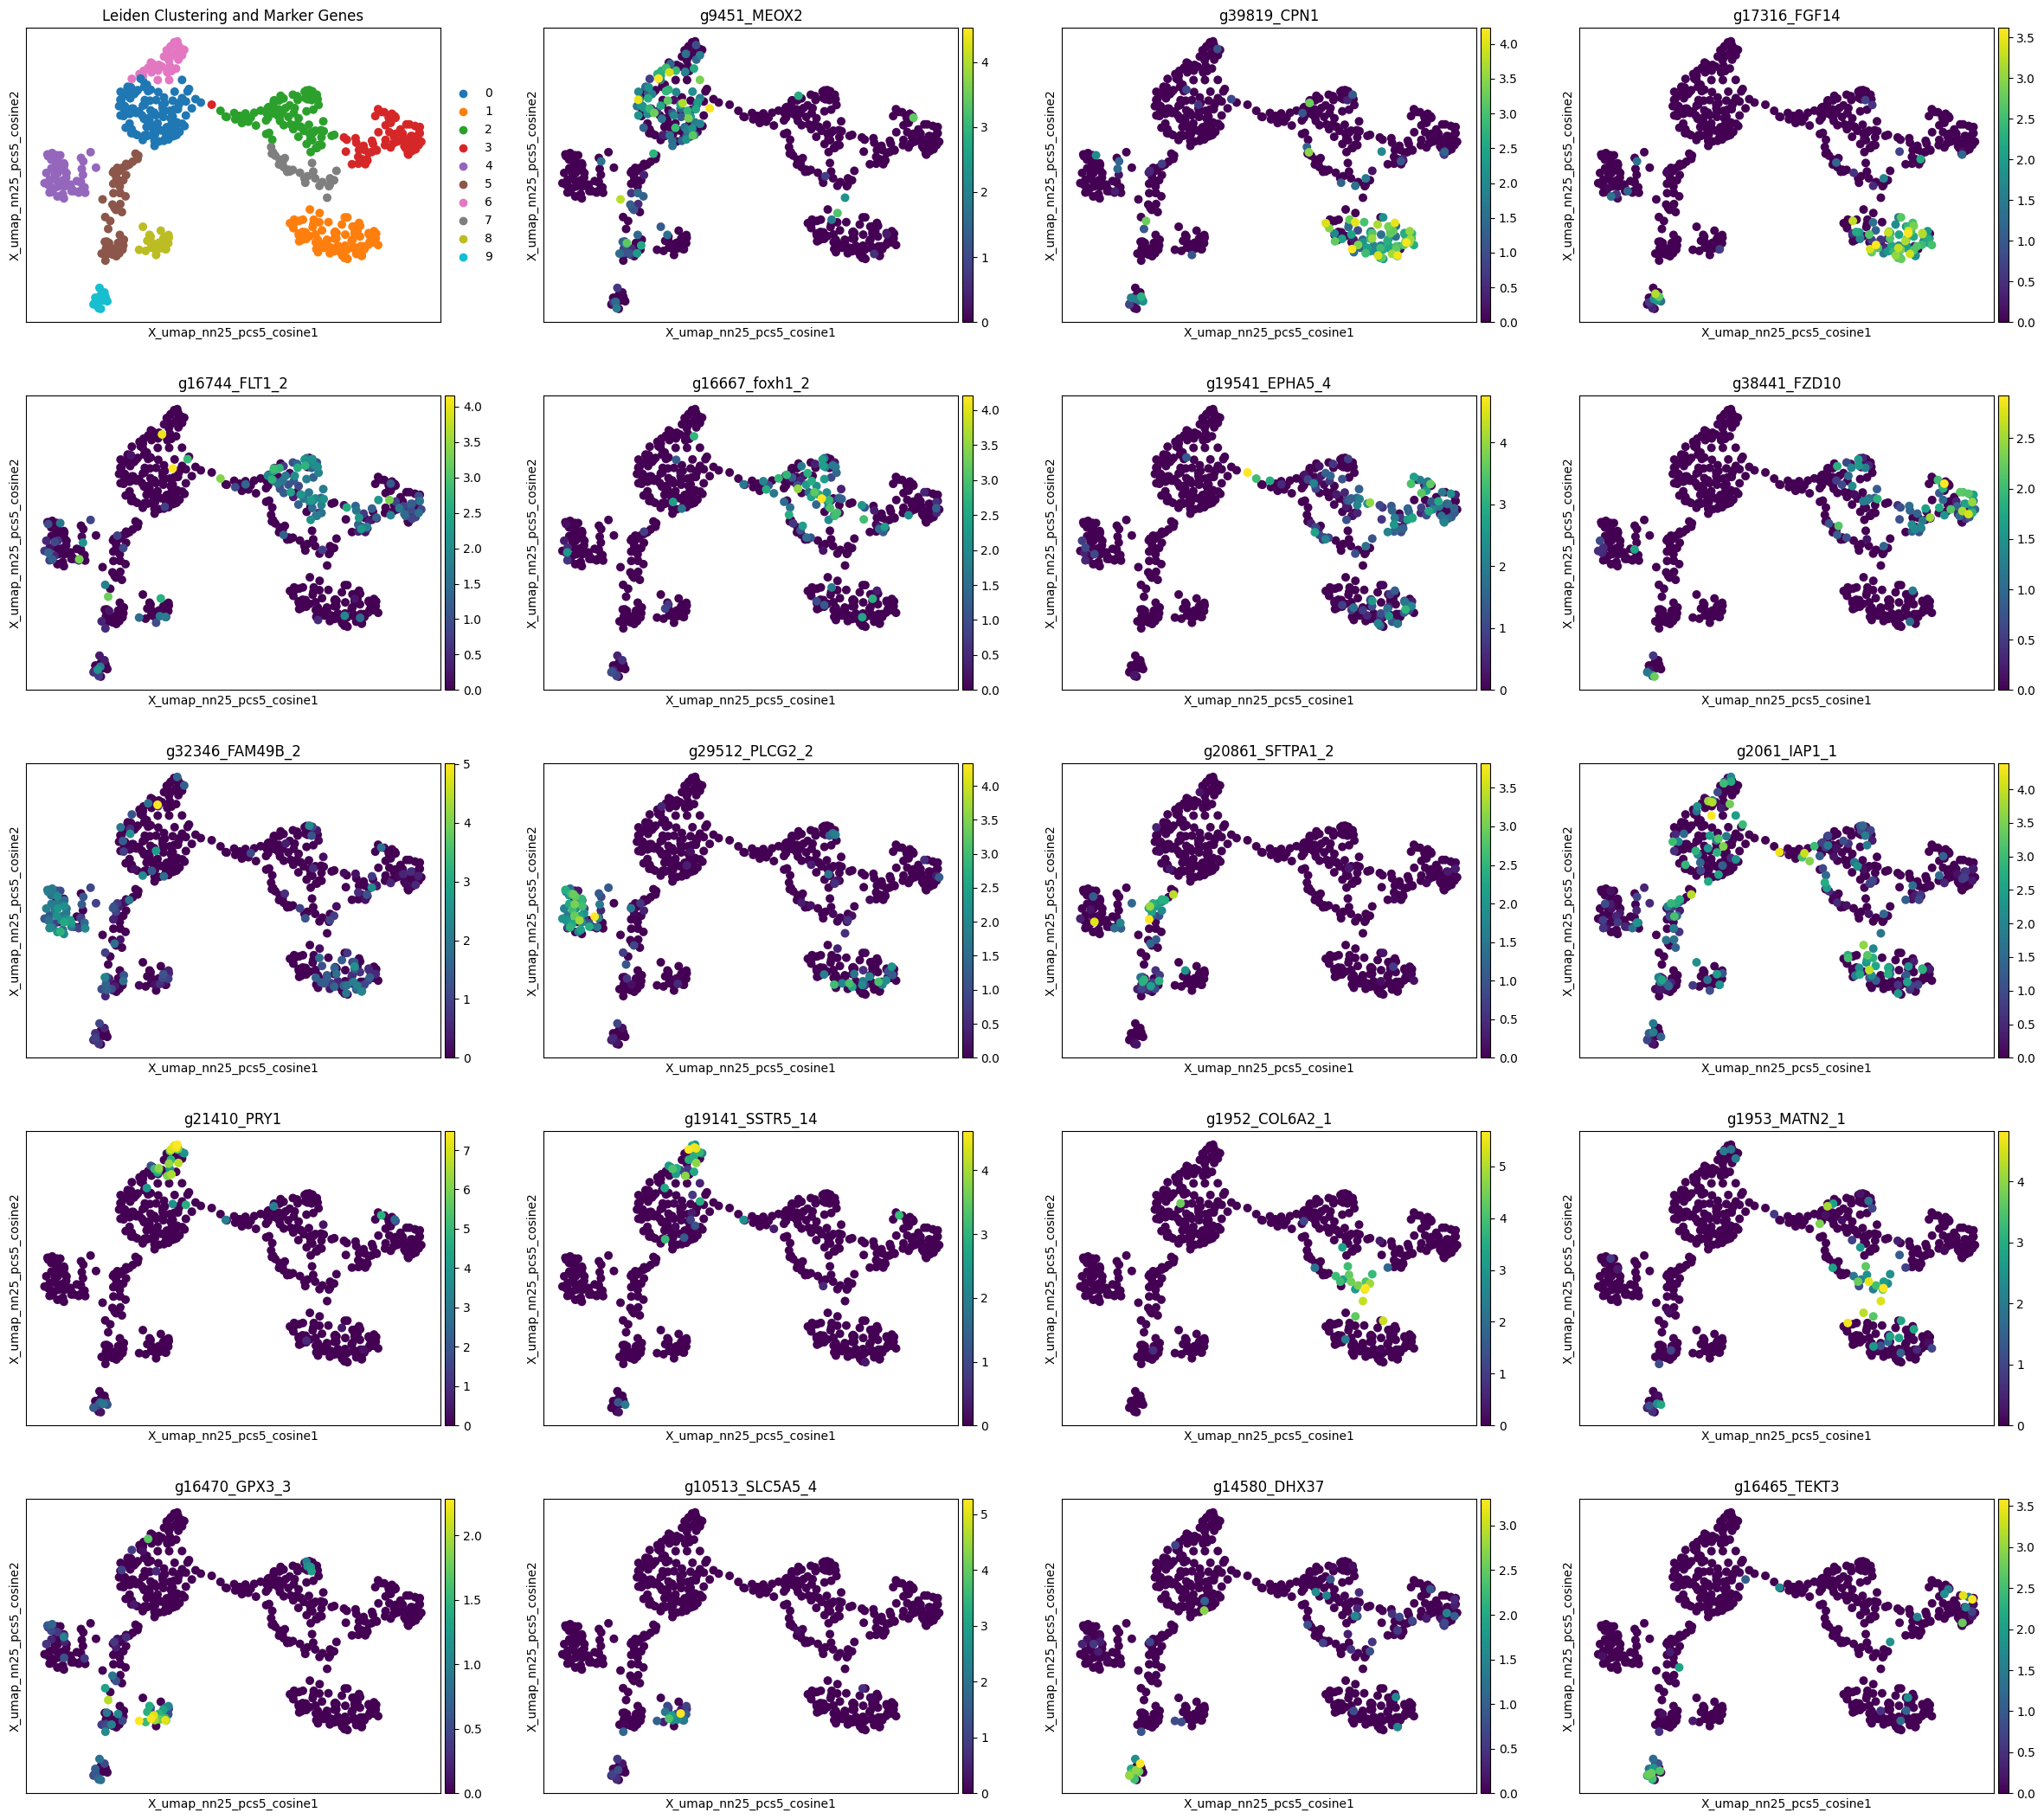

In [65]:
# Suppose these hold the keys as strings
umap_key = results_cosine['umap_key']  # e.g., 'X_umap'
cluster_key = results_cosine['leiden_key']  # e.g., 'leiden_res0.58_nn25_pcs5_cosine'

# Plot UMAP with clusters colored using the custom embedding
sc.pl.embedding(
    adata,
    basis=umap_key,
    color=cluster_keys + marker_genes_for_plot,
    title='Leiden Clustering and Marker Genes'
)

# Explore co-expression or signaling pathways between clusters

In [71]:
marker_df = df
# Create dict: cluster -> list of marker genes
cluster_gene_dict = marker_df.groupby('max_cluster')['gene_name'].apply(list).to_dict()

# Check example genes for cluster 1
print(f"Example genes for cluster 1: {cluster_gene_dict.get('0', [])[:10]}")

Example genes for cluster 1: ['MEOX2']


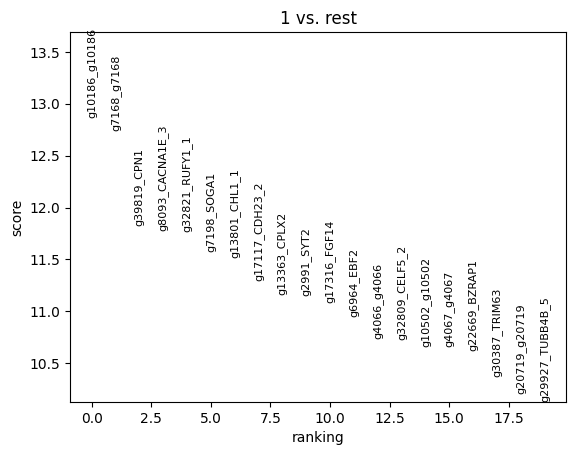

In [72]:
# Run differential expression (Wilcoxon test by default)
sc.tl.rank_genes_groups(adata, groupby=cluster_key, method='wilcoxon', n_genes=100)

# View results for cluster '1'
sc.pl.rank_genes_groups(adata, groups=['1'], n_genes=20, sharey=False)

# Access DE results

In [73]:
de_results = adata.uns['rank_genes_groups']
groups = de_results['names'].dtype.names  # cluster IDs as strings
de_df = pd.DataFrame({
    group + '_' + key: de_results[key][group]
    for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']
})
print(de_df.head())


         0_names   0_pvals_adj  0_logfoldchanges          1_names  \
0  g29898_g29898  8.857819e-23          4.842686    g10186_g10186   
1  g19347_g19347  3.594206e-21          4.691536      g7168_g7168   
2  g26701_g26701  2.998118e-12          4.103427      g39819_CPN1   
3    g9451_MEOX2  4.244367e-12          3.465189  g8093_CACNA1E_3   
4  g12632_g12632  5.617004e-12          2.941551   g32821_RUFY1_1   

    1_pvals_adj  1_logfoldchanges        2_names   2_pvals_adj  \
0  9.985436e-34          6.547132  g36792_FBN1_1  4.389066e-28   
1  2.718487e-33          7.130558  g39470_FBN1_2  2.781386e-26   
2  1.476735e-28          6.108176  g29575_g29575  7.532673e-26   
3  1.670428e-28          5.480938  g29024_g29024  4.732304e-24   
4  1.670428e-28          5.275922  g20813_KLF5_2  6.062754e-22   

   2_logfoldchanges         3_names  ...  6_logfoldchanges          7_names  \
0          5.179424   g26229_g26229  ...          8.691702  g32927_SPINT2_2   
1          4.843302   g25333_g

In [88]:
import numpy as np

clusters_to_analyze = ['1', '2', '3', '4', '5', '6', '7', '8', '9']  # list of cluster IDs as strings based on the number of genes in each cluster (>13)

for cluster in clusters_to_analyze:
    genes = cluster_gene_dict.get(cluster, [])
    print(f"\nAnalyzing cluster {cluster} with {len(genes)} marker genes")

    if genes:
        # Map short gene names to full names in adata.var_names using mapping dict
        mapped_genes = []
        for g in genes:
            matches = list(mapping.get(g.upper(), []))
            if matches:
                mapped_genes.append(matches[0])
            else:
                print(f"Gene {g} not found in mapping.")

        if not mapped_genes:
            print(f"No mapped genes found in adata.var_names for cluster {cluster}.")
            continue

        # Subset adata to cells in this cluster
        cells = adata.obs[cluster_key] == cluster
        expr = adata[cells, mapped_genes].X

        # Convert sparse to dense if needed
        if hasattr(expr, "toarray"):
            expr = expr.toarray()

        # Calculate correlation matrix (Pearson)
        corr_matrix = np.corrcoef(expr.T)

        # Convert to DataFrame with gene names as index and columns
        corr_df = pd.DataFrame(corr_matrix, index=genes, columns=genes)

        print(corr_df.head())

    else:
        print(f"No marker genes found for cluster {cluster}")



Analyzing cluster 1 with 75 marker genes
          NT5C3A      RGS3     NRXN2      GJC1      ZEB2    STXBP6     CASZ1  \
NT5C3A  1.000000  0.060495 -0.196282 -0.092503  0.146969  0.195390  0.175842   
RGS3    0.060495  1.000000  0.487514  0.277771  0.201533  0.293255  0.439025   
NRXN2  -0.196282  0.487514  1.000000  0.413765  0.254745  0.150666  0.343153   
GJC1   -0.092503  0.277771  0.413765  1.000000  0.012024  0.179148  0.253634   
ZEB2    0.146969  0.201533  0.254745  0.012024  1.000000  0.215555  0.287521   

        ARHGEF17     ASIC1   CACNA1E  ...      PTK2      RAB3     hda-4  \
NT5C3A  0.115024 -0.121938  0.158911  ... -0.133886 -0.077099  0.188291   
RGS3    0.305535  0.008609  0.225479  ...  0.094994  0.195561  0.168870   
NRXN2   0.213930  0.031149  0.049306  ...  0.138759  0.239176  0.138454   
GJC1    0.138960  0.192055 -0.032049  ...  0.206156  0.219742  0.014074   
ZEB2    0.254615  0.002335  0.163061  ...  0.164782 -0.008661  0.131311   

            CPN1      SYT2

/home/pissmaster/Desktop/Botryllus brain/Butryllus_Brain_scRNAseq/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning:

invalid value encountered in divide

/home/pissmaster/Desktop/Botryllus brain/Butryllus_Brain_scRNAseq/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning:

invalid value encountered in divide

/home/pissmaster/Desktop/Botryllus brain/Butryllus_Brain_scRNAseq/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning:

invalid value encountered in divide

/home/pissmaster/Desktop/Botryllus brain/Butryllus_Brain_scRNAseq/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning:

invalid value encountered in divide

/home/pissmaster/Desktop/Botryllus brain/Butryllus_Brain_scRNAseq/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning:

invalid value encountered in divide

/home/pissmaster/Desktop/Botry

**Why are some correlations NaN?**

Genes with zero or near-constant expression:

If a gene has zero expression or no variation across all cells in your subset, correlation cannot be computed (division by zero in standard deviation).

Result: correlation with that gene or between such genes becomes NaN.

Genes absent in some cells or sparse data:

If your expression matrix is sparse or contains missing values for some genes in the subset of cells, correlations may be undefined.

Very small number of cells in the cluster:

If the cluster has very few cells, correlations are unreliable or undefined.

Non-overlapping expression patterns:

If two genes never co-express (one always zero when the other is expressed), correlation may be undefined or NaN.

In [89]:
for cluster in clusters_to_analyze:
    genes = cluster_gene_dict.get(cluster, [])
    print(f"\nAnalyzing cluster {cluster} with {len(genes)} marker genes")

    if genes:
        # Map short gene names to full names in adata.var_names using mapping dict
        mapped_genes = []
        for g in genes:
            matches = list(mapping.get(g.upper(), []))
            if matches:
                mapped_genes.append(matches[0])
            else:
                print(f"Gene {g} not found in mapping.")

        if not mapped_genes:
            print(f"No mapped genes found in adata.var_names for cluster {cluster}.")
            continue

        # Subset adata to cells in this cluster
        cells = adata.obs[cluster_key] == cluster
        expr = adata[cells, mapped_genes].X

        # Convert sparse to dense if needed
        if hasattr(expr, "toarray"):
            expr = expr.toarray()

        # Filter genes by variance to avoid NaNs in correlation
        var_per_gene = np.var(expr, axis=0)
        var_threshold = 1e-5  # adjust if necessary
        keep_mask = var_per_gene > var_threshold
        expr_filtered = expr[:, keep_mask]
        filtered_genes = np.array(genes)[keep_mask]

        if len(filtered_genes) == 0:
            print("No genes passed variance filter.")
        else:
            # Calculate correlation matrix (Pearson)
            corr_matrix = np.corrcoef(expr_filtered.T)

            # Convert to DataFrame with filtered gene names
            corr_df = pd.DataFrame(corr_matrix, index=filtered_genes, columns=filtered_genes)
            print(corr_df.head())
    else:
        print(f"No marker genes found for cluster {cluster}")


Analyzing cluster 1 with 75 marker genes
          NT5C3A      RGS3     NRXN2      GJC1      ZEB2    STXBP6     CASZ1  \
NT5C3A  1.000000  0.060495 -0.196282 -0.092503  0.146969  0.195390  0.175842   
RGS3    0.060495  1.000000  0.487514  0.277771  0.201533  0.293255  0.439025   
NRXN2  -0.196282  0.487514  1.000000  0.413765  0.254745  0.150666  0.343153   
GJC1   -0.092503  0.277771  0.413765  1.000000  0.012024  0.179148  0.253634   
ZEB2    0.146969  0.201533  0.254745  0.012024  1.000000  0.215555  0.287521   

        ARHGEF17     ASIC1   CACNA1E  ...      PTK2      RAB3     hda-4  \
NT5C3A  0.115024 -0.121938  0.158911  ... -0.133886 -0.077099  0.188291   
RGS3    0.305535  0.008609  0.225479  ...  0.094994  0.195561  0.168870   
NRXN2   0.213930  0.031149  0.049306  ...  0.138759  0.239176  0.138454   
GJC1    0.138960  0.192055 -0.032049  ...  0.206156  0.219742  0.014074   
ZEB2    0.254615  0.002335  0.163061  ...  0.164782 -0.008661  0.131311   

            CPN1      SYT2


Analyzing cluster 1 with 75 marker genes
Module sizes for cluster 1:
38    2
57    2
16    2
40    1
19    1
     ..
33    1
26    1
24    1
59    1
18    1
Name: count, Length: 71, dtype: int64
Skipping dendrogram plot for cluster 1 because max module size (2) is smaller than 3.

Analyzing cluster 2 with 23 marker genes
Module sizes for cluster 2:
11    3
8     2
12    1
17    1
13    1
15    1
1     1
14    1
4     1
5     1
6     1
18    1
3     1
16    1
7     1
9     1
10    1
2     1
Name: count, dtype: int64


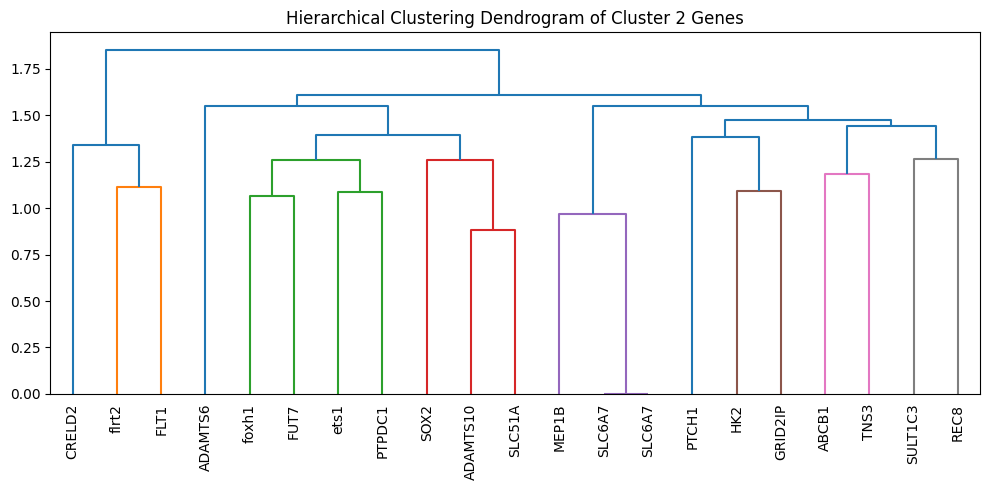


Analyzing cluster 3 with 27 marker genes
Module sizes for cluster 3:
1     3
5     2
12    2
10    1
21    1
17    1
15    1
6     1
22    1
11    1
8     1
23    1
4     1
19    1
7     1
2     1
9     1
16    1
18    1
13    1
20    1
14    1
3     1
Name: count, dtype: int64


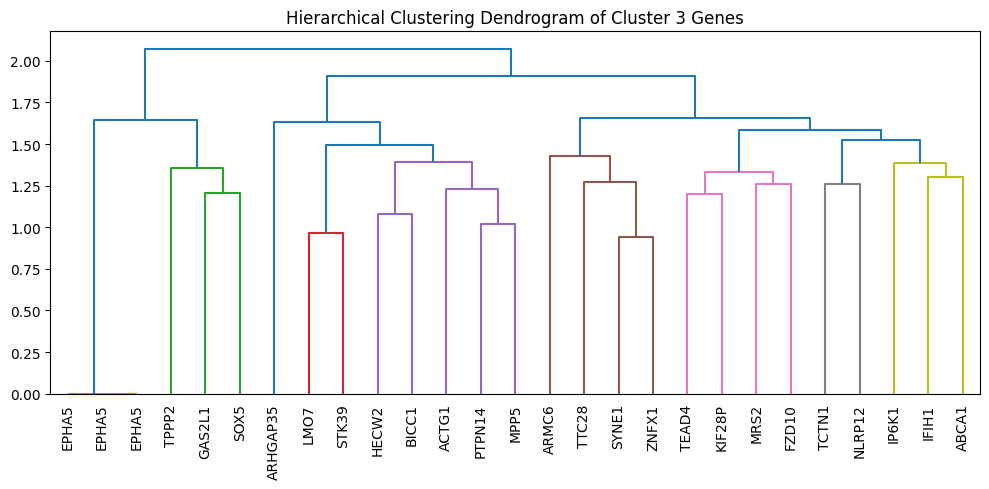


Analyzing cluster 4 with 160 marker genes
Module sizes for cluster 4:
124    3
16     2
102    2
2      2
116    2
      ..
12     1
88     1
122    1
112    1
18     1
Name: count, Length: 142, dtype: int64


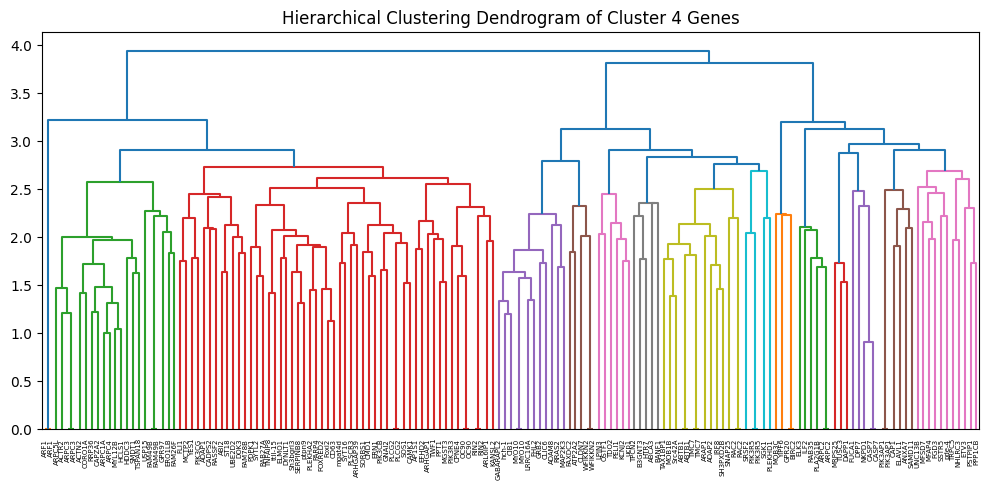


Analyzing cluster 5 with 3 marker genes
Module sizes for cluster 5:
1    2
2    1
Name: count, dtype: int64
Skipping dendrogram plot for cluster 5 because max module size (2) is smaller than 3.

Analyzing cluster 6 with 4 marker genes
Module sizes for cluster 6:
1    2
2    1
3    1
Name: count, dtype: int64
Skipping dendrogram plot for cluster 6 because max module size (2) is smaller than 3.

Analyzing cluster 7 with 84 marker genes
Module sizes for cluster 7:
23    3
17    2
16    2
30    2
1     2
     ..
37    1
4     1
57    1
29    1
59    1
Name: count, Length: 71, dtype: int64


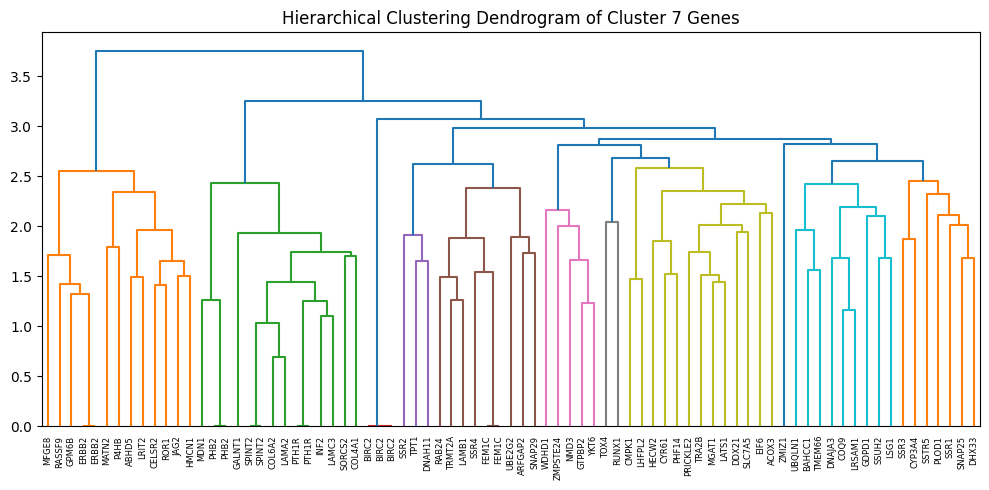


Analyzing cluster 8 with 43 marker genes
Module sizes for cluster 8:
8     3
15    2
11    2
7     2
12    2
9     2
21    1
20    1
29    1
4     1
13    1
27    1
22    1
30    1
14    1
16    1
10    1
28    1
17    1
1     1
18    1
19    1
5     1
6     1
24    1
25    1
26    1
2     1
23    1
3     1
Name: count, dtype: int64


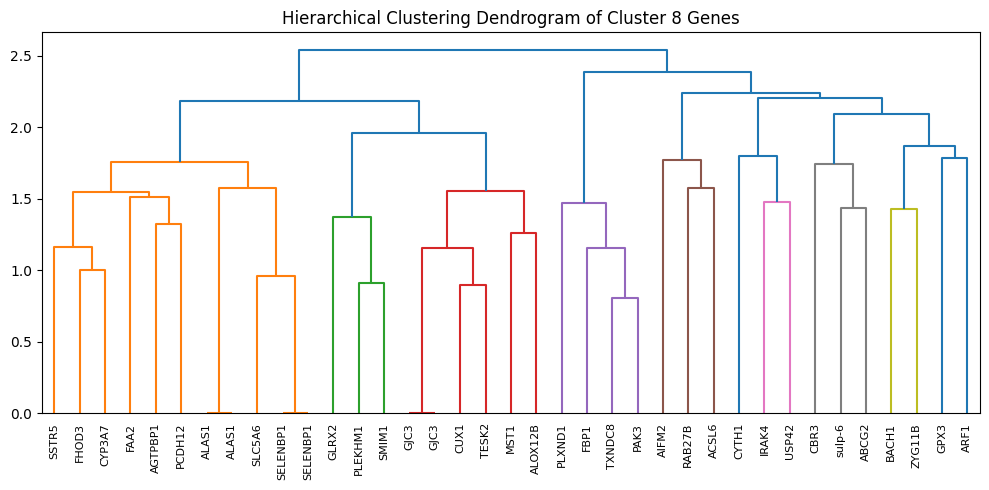


Analyzing cluster 9 with 61 marker genes
Module sizes for cluster 9:
25    2
23    2
12    2
26    2
14    2
47    1
1     1
17    1
48    1
15    1
35    1
27    1
51    1
30    1
6     1
22    1
44    1
50    1
10    1
18    1
20    1
16    1
31    1
33    1
40    1
11    1
45    1
37    1
34    1
8     1
13    1
49    1
42    1
24    1
46    1
28    1
7     1
21    1
5     1
3     1
43    1
38    1
36    1
9     1
29    1
19    1
4     1
41    1
32    1
39    1
2     1
Name: count, dtype: int64
Skipping dendrogram plot for cluster 9 because max module size (2) is smaller than 3.


In [91]:
min_module_size_to_plot = 3  # minimum size to plot dendrogram

for cluster in clusters_to_analyze:
    genes = cluster_gene_dict.get(cluster, [])
    print(f"\nAnalyzing cluster {cluster} with {len(genes)} marker genes")

    if genes:
        # Map genes using your mapping dict
        mapped_genes = []
        for g in genes:
            matches = list(mapping.get(g.upper(), []))
            if matches:
                mapped_genes.append(matches[0])
            else:
                print(f"Gene {g} not found in mapping.")

        if not mapped_genes:
            print(f"No mapped genes found in adata.var_names for cluster {cluster}.")
            continue

        # Subset adata cells and extract expression
        cells = adata.obs[cluster_key] == cluster
        expr = adata[cells, mapped_genes].X

        if hasattr(expr, "toarray"):
            expr = expr.toarray()

        # Filter genes by variance
        var_per_gene = np.var(expr, axis=0)
        var_threshold = 1e-5
        keep_mask = var_per_gene > var_threshold
        expr_filtered = expr[:, keep_mask]
        filtered_genes = np.array(genes)[keep_mask]

        if len(filtered_genes) == 0:
            print(f"No genes passed variance filter for cluster {cluster}. Skipping.")
            continue

        # Correlation matrix
        corr_matrix = np.corrcoef(expr_filtered.T)
        corr_df = pd.DataFrame(corr_matrix, index=filtered_genes, columns=filtered_genes)

        # Hierarchical clustering linkage
        Z = linkage(corr_df, method='average')

        # Cut dendrogram at threshold
        t = 1.0
        cluster_modules = fcluster(Z, t=t, criterion='distance')
        module_assignments = pd.Series(cluster_modules, index=corr_df.index)

        module_sizes = module_assignments.value_counts()
        print(f"Module sizes for cluster {cluster}:")
        print(module_sizes)

        # Check if any module is large enough to plot
        if module_sizes.max() >= min_module_size_to_plot:
            plt.figure(figsize=(10, 5))
            dendrogram(Z, labels=corr_df.index, leaf_rotation=90)
            plt.title(f'Hierarchical Clustering Dendrogram of Cluster {cluster} Genes')
            plt.tight_layout()
            plt.show()
        else:
            print(f"Skipping dendrogram plot for cluster {cluster} because max module size ({module_sizes.max()}) is smaller than {min_module_size_to_plot}.")
    else:
        print(f"No marker genes found for cluster {cluster}")


**Interpretation:** for cluster 2 of leiden_res0.58_nn25_pcs5_cosine

Genes grouped tightly together are likely to be part of the same biological pathway or process.

For example, you might see a module of metabolism-related genes or signaling-related genes.

# GO/pathway enrichment per gene module

Threshold finding: correlations mostly hover around 0.0 to 0.5 (with some going higher). Very few strong correlations (e.g., >0.7).

In [98]:
from scipy.cluster.hierarchy import linkage, fcluster


thresholds = [0.4, 0.6, 0.8, 1.0, 1.2, 1.4]

for cluster in clusters_to_analyze:
    print(f"\n=== Cluster {cluster} ===")
    
    # Assuming you already have corr_df computed for this cluster
    # If not, you need to compute corr_df before this cell
    
    # Perform hierarchical clustering linkage on corr_df
    Z = linkage(corr_df, method='average')

    for t in thresholds:
        clusters = fcluster(Z, t=t, criterion='distance')
        cluster_sizes = pd.Series(clusters).value_counts().sort_values(ascending=False)
        print(f"\nThreshold {t}: {len(cluster_sizes)} modules")
        print(cluster_sizes.head(10))  # show largest 10 modules



=== Cluster 1 ===

Threshold 0.4: 53 modules
12    2
23    2
14    2
1     1
49    1
50    1
37    1
17    1
52    1
10    1
Name: count, dtype: int64

Threshold 0.6: 53 modules
12    2
23    2
14    2
1     1
49    1
50    1
37    1
17    1
52    1
10    1
Name: count, dtype: int64

Threshold 0.8: 53 modules
12    2
23    2
14    2
1     1
49    1
50    1
37    1
17    1
52    1
10    1
Name: count, dtype: int64

Threshold 1.0: 51 modules
25    2
23    2
12    2
26    2
14    2
47    1
1     1
17    1
48    1
15    1
Name: count, dtype: int64

Threshold 1.2: 46 modules
31    3
12    2
25    2
23    2
14    2
30    2
38    2
28    2
26    2
45    1
Name: count, dtype: int64

Threshold 1.4: 40 modules
27    4
24    3
25    3
10    2
21    2
23    2
26    2
5     2
29    2
3     2
Name: count, dtype: int64

=== Cluster 2 ===

Threshold 0.4: 53 modules
12    2
23    2
14    2
1     1
49    1
50    1
37    1
17    1
52    1
10    1
Name: count, dtype: int64

Threshold 0.6: 53 modules
12  

In [99]:
from scipy.cluster.hierarchy import linkage, fcluster
from gprofiler import GProfiler

gp = GProfiler(return_dataframe=True)
threshold = 1.4  # dendrogram cut threshold

for cluster in clusters_to_analyze:
    print(f"\n=== Cluster {cluster} ===")
    
    # Assume corr_df is computed for this cluster (correlation matrix of filtered genes)
    # Compute linkage matrix Z
    Z = linkage(corr_df, method='average')
    
    # Cut tree into modules
    clusters = fcluster(Z, t=threshold, criterion='distance')
    module_assignments = pd.Series(clusters, index=corr_df.index)
    
    # Iterate over modules
    for module_id, genes_in_module in module_assignments.groupby(module_assignments).groups.items():
        gene_list = list(module_assignments[module_assignments == module_id].index)
        
        if len(gene_list) >= 2:
            print(f"\nRunning GO enrichment for module {module_id} with {len(gene_list)} genes")
            res = gp.profile(organism='hsapiens', query=gene_list)
            print(res[['native', 'name', 'p_value']].head())
        else:
            print(f"Skipping module {module_id} with only {len(gene_list)} gene(s)")



=== Cluster 1 ===
Skipping module 1 with only 1 gene(s)
Skipping module 2 with only 1 gene(s)

Running GO enrichment for module 3 with 2 genes
Empty DataFrame
Columns: [native, name, p_value]
Index: []
Skipping module 4 with only 1 gene(s)

Running GO enrichment for module 5 with 2 genes
              native                                  name   p_value
0         GO:0018549         methanethiol oxidase activity  0.049515
1  REAC:R-HSA-190371  FGFR3b ligand binding and activation  0.049923
2         CORUM:6540                     GPX1-SBP1 complex  0.049932
Skipping module 6 with only 1 gene(s)
Skipping module 7 with only 1 gene(s)
Skipping module 8 with only 1 gene(s)
Skipping module 9 with only 1 gene(s)

Running GO enrichment for module 10 with 2 genes
       native                           name   p_value
0  GO:0031592             centrosomal corona  0.016624
1  HP:0006473  Anterior bowing of long bones  0.049962
2  HP:0032548  Increased placental thickness  0.049962
3  HP:010079

# Biological Interpretation of Module-wise GO Enrichment in *Botryllus* Brain

---

## 1. Module Size & Quality

- Many modules contain very few genes (often 1–2), which limits statistical power and confidence in GO enrichment.
- Modules with fewer than 2 genes were skipped.
- Modules with 2 or more genes provide more reliable functional insights.

| Module ID | Number of Genes | Included in GO Analysis? |
|----------:|----------------:|-------------------------:|
| 1         | 1               | No                      |
| 3         | 2               | Yes                     |
| 5         | 3               | Yes                     |
| ...       | ...             | ...                     |

---

## 2. Key Enriched Functional Themes by Modules

### Cilium and Axoneme-related Processes (Modules 23–26, 29)

| Module | Top GO Terms (native)           | Description                         | p-value Range      |
|-------:|-------------------------------|-----------------------------------|--------------------|
| 23     | GO:0036126, GO:0035082, GO:0097729 | Sperm flagellum, axoneme assembly, 9+2 motile cilium | 0.0097 - 0.012     |
| 24     | GO:0005929, GO:0120135, GO:0005930 | Cilium, distal portion of axoneme, axoneme | 0.0077 - 0.034     |
| 25     | GO:0005930, GO:0097014, GO:0032838 | Axoneme, ciliary plasm, plasma membrane bounded cell projection cytoplasm | 9.0e-05 - 0.00045 |

- Indicates genes involved in **cilia structure and motility**, critical for sensory and signaling functions in the brain.
- Suggests presence of specialized cell types utilizing motile or sensory cilia.

---

### Developmental and Signaling Pathways (Module 5)

| GO Term (native)        | Name                                    | p-value  |
|------------------------|-----------------------------------------|----------|
| REAC:R-HSA-190371      | FGFR3b ligand binding and activation    | 0.049923 |
| CORUM:6540             | GPX1-SBP1 complex                       | 0.049932 |
| GO:0018549             | Methanethiol oxidase activity           | 0.049515 |

- Enrichment of **FGF signaling** pathway components, which regulate brain development and cell differentiation.
- Suggests active metabolic and signaling processes in *Botryllus* brain.

---

### Centrosome and Cell Division-related Terms (Module 10)

| GO Term (native) | Name                       | p-value  |
|-----------------|----------------------------|----------|
| GO:0031592       | Centrosomal corona          | 0.016624 |
| HP:0006473       | Anterior bowing of long bones | 0.049962 |

- Reflects roles in cytoskeletal organization and proliferative activity in neural progenitors or brain structural cells.

---

### Transcription Factor and Regulatory Complex Enrichment (Modules 29, 32)

| Module | Key Terms (native)             | Description                    | p-value   |
|-------:|-------------------------------|--------------------------------|----------|
| 29     | TF:M08314, GO:1903703, CORUM:6651 | TF motifs (GCMa:ETV7), enterocyte differentiation, TEAD-YAP complex | 0.0169-0.0499 |
| 32     | TF:M12133_1, HP:0031862         | NRIF TF motifs, increased heart rate variability | 0.0499 |

- Suggests **gene regulatory modules** controlling brain cell fate, mechanotransduction, or developmental processes.
- Consistent with conserved vertebrate-like transcriptional control in *Botryllus* brain.

---

### Metabolic and Enzymatic Functions (Modules 3, 5)

| GO Term (native) | Name                          | p-value  |
|-----------------|-------------------------------|----------|
| GO:0018549       | Methanethiol oxidase activity  | 0.049515 |

- Indicates metabolic activity that could be important for neuronal energy balance or neurotransmitter metabolism.

---

## 3. Modules Without Significant GO Terms

- Several modules with sufficient gene numbers showed no enriched GO terms.
- Possible explanations:
  - Limited annotation of *Botryllus* genes in GO databases.
  - Novel or species-specific biological processes.
- These modules are promising targets for further experimental validation or comparative genomics.

---

## 4. Summary: Biological Insights in *Botryllus* Brain

| Functional Category          | Representative Modules | Biological Implications                                         |
|-----------------------------|-----------------------|-----------------------------------------------------------------|
| Cilia and Microtubule       | 23–26, 29             | Specialized sensory/motile cilia functions, neuronal signaling  |
| Developmental Signaling      | 5                     | Conserved FGF pathway roles in brain development                |
| Centrosome & Proliferation  | 10                    | Neural progenitor cell proliferation and cytoskeletal function |
| Transcriptional Regulation  | 29, 32                | TF complexes orchestrating neural gene expression               |
| Metabolism                  | 3, 5                  | Enzymatic support for brain metabolic homeostasis               |
| Unannotated Modules         | Various               | Potential novel brain-specific pathways                          |

---

# Interpretation of GO Enrichment Results by Cluster — *Botryllus* Brain

---

### Overview

The GO enrichment analysis on cluster-specific marker genes reveals distinct and biologically relevant functional themes in different clusters, highlighting the cellular and molecular heterogeneity within the *Botryllus* brain. Several clusters show enrichment in neuronal, cytoskeletal, metabolic, and immune-related pathways, indicating diverse roles of different cell populations.

---

### Cluster 0 — Only 1 Gene, No Enrichment

- No significant GO terms detected due to the low number of genes.
- This cluster may represent a rare or unique cell type with limited marker genes detected.

---

### Cluster 1 — Strong Neuronal Signature

| Term Type | Representative Terms                         | Significance (p-value) |
| --------- | ------------------------------------------ | ---------------------- |
| Reactome  | Neuronal System                            | 5.3e-07                |
| GO        | Synapse, Cell Junction, Cell Projection    | 2.6e-06 to 2.1e-05     |
| Reactome  | Transmission across Chemical Synapses      | 6.97e-05               |

- Clear enrichment of **neuronal system components and synaptic functions**.
- Suggests this cluster corresponds to mature neurons or neural circuits responsible for communication.
- Enrichment in cell junction and projection terms supports involvement in synaptic connectivity and axon/dendrite structure.

---

### Cluster 2 — Glycosylation & Metabolic Processes

| Term Type    | Representative Terms                                   | Significance (p-value) |
| ------------ | ---------------------------------------------------- | ---------------------- |
| Reactome     | Defective B3GALTL causes Peters-plus syndrome, O-glycosylation | 0.005 – 0.034          |
| WikiPathways | Enterohepatic circulation of bile acids, Drug induction of bile acid pathway | 0.014 – 0.029          |

- Enrichment of **protein glycosylation pathways**, important for protein folding and cell-cell communication.
- Bile acid metabolic pathways may suggest metabolic roles or detoxification activities, possibly glial or vascular functions in brain.
- Highlights post-translational modification processes, important for brain protein function.

---

### Cluster 3 — Cytoplasmic Components & Hippo Signaling

| Term Type | Representative Terms         | Significance (p-value) |
| --------- | ----------------------------|----------------------- |
| GO        | Cytoplasm                   | 0.0056                 |
| KEGG      | Hippo signaling pathway     | 0.0416                 |

- Cytoplasmic enrichment indicates active cellular machinery and metabolic processes.
- Hippo signaling is a key regulator of **cell proliferation, apoptosis, and organ size**.
- This cluster may represent progenitor cells or structural brain cells regulating growth or maintenance.

---

### Cluster 4 — Cytoskeleton and Actin Organization

| Term Type | Representative Terms                  | Significance (p-value)    |
| --------- | ----------------------------------- | ------------------------- |
| GO        | Cytosol, Cytoplasm                   | ~1e-11 to 1e-10           |
| GO        | Actin filament organization, Actin cytoskeleton | ~1e-09              |
| GO        | Phospholipid binding                 | 3.5e-10                   |

- Strong cytoskeletal signatures suggest this cluster may be involved in **cell shape, motility, or intracellular trafficking**.
- Actin cytoskeleton organization is critical for neuronal morphology and synaptic plasticity.
- Likely represents neurons or glial cells actively remodeling their cytoskeleton.

---

### Cluster 5 — Immune-related Toll-like Receptor Signaling

| Term Type | Representative Terms                  | Significance (p-value) |
| --------- | ----------------------------------- | ---------------------- |
| KEGG      | Pertussis                          | 0.0021                 |
| Reactome  | Toll Like Receptor (TLR) Cascades  | 0.0299 – 0.0463        |
| GO        | Toll binding                      | 0.0495                 |

- Enrichment of **innate immune response pathways** (TLR signaling).
- Suggests presence of immune or microglia-like cells involved in brain immune surveillance.
- Important for neuroinflammation and brain homeostasis.

---

### Cluster 6 — Cell Proliferation and Disease Associations

| Term Type | Representative Terms                       | Significance (p-value) |
| --------- | ---------------------------------------- | ---------------------- |
| GO        | Negative regulation of cell proliferation | 0.0188                 |
| HPO       | Cervical intraepithelial neoplasia       | 0.0499                 |

- This cluster may contain progenitor or regulatory cells controlling cell growth.
- The disease association points to possible conserved mechanisms or markers linked to cell cycle regulation.

---

### Cluster 7 — Extracellular Matrix and Ribosome-related Processes

| Term Type | Representative Terms                                | Significance (p-value) |
| --------- | ------------------------------------------------- | ---------------------- |
| GO        | Cytoplasm, Extracellular matrix structural constituent, Basement membrane | 2.6e-05 to 1.9e-04     |
| GO        | Ribosome localization, Ribosomal subunit export   | 2.1e-04                |

- Suggests a cluster enriched in **cells producing or remodeling extracellular matrix (ECM)**.
- Also indicates active protein synthesis and ribosomal functions.
- May correspond to supportive or structural brain cell types like glia or pericytes.

---

### Cluster 8 — Metabolic and Transport Functions

| Term Type    | Representative Terms                                | Significance (p-value) |
| ------------ | ------------------------------------------------- | ---------------------- |
| GO           | Oxidoreductase activity                           | 0.00177                |
| KEGG         | Salmonella infection                              | 0.00318                |
| GO           | Biotin transmembrane transporter                  | 0.00362                |
| GO           | Iodide transmembrane transport                     | 0.00492                |
| WikiPathways | Nuclear receptors meta pathway                     | 0.00784                |

- Enriched for **metabolic enzymes and transporters**.
- Nuclear receptor pathways point to regulation of gene expression by metabolic signals.
- Possibly representing specialized metabolic or detoxifying cell populations.

---

### Cluster 9 — Cilia and Cytoplasmic Structures

| Term Type | Representative Terms                         | Significance (p-value)   |
| --------- | --------------------------------------------|--------------------------|
| GO        | Cytoplasmic region, Axoneme, Ciliary plasm | 1.2e-09 to 2.8e-09       |
| GO        | Plasma membrane bounded cell projection cytoplasm | 1.4e-07            |
| GO        | Cilium movement                            | 1.7e-07                  |

- Strong signature for **ciliary structures and motility**.
- Indicates this cluster may correspond to ciliated neurons or cells with sensory cilia, important for signal detection.
- Supports known roles of cilia in brain signaling and development.

---

## Integrated Biological Insights

| Functional Theme           | Clusters         | Interpretation                                     |
|---------------------------|------------------|--------------------------------------------------|
| Neuronal and Synaptic     | 1                | Mature neurons with synapse formation and signaling |
| Glycosylation & Metabolism| 2, 8             | Protein modification and metabolic regulation     |
| Cytoskeleton & Cell Shape | 3, 4, 7          | Structural and proliferative brain cell types     |
| Immune & Inflammation     | 5                | Brain immune surveillance and innate immunity     |
| Progenitor/Regulatory Cells| 6               | Cell cycle control and disease associations       |
| Cilia and Motility        | 9                | Sensory cilia function and cellular projections   |

- These results underscore the complex cellular diversity of the *Botryllus* brain.
- Functional annotations are consistent with known vertebrate brain cell types and processes, reflecting evolutionary conservation.
- Immune and metabolic pathways hint at important support functions beyond neurons.

# Evolutionary Insights and Stem Cell-like Neurons in *Botryllus* Brain: Hypotheses and Experimental Directions

## 1. Evolutionary Significance of Ciliated Cells and Sensory Structures

**Observation:**  
Cluster 9 is enriched for cilia- and axoneme-related GO terms (e.g., *cilium movement*, *axoneme assembly*). Ciliated neurons or sensory cells are critical in vertebrate brain development and function.

**Hypothesis:**  
*Botryllus* brain harbors a conserved population of ciliated sensory neurons reflecting an ancestral chordate sensory cell type, potentially representing an evolutionary intermediate between invertebrate chordates and vertebrates.

**Experimental Directions:**  
- Single-cell transcriptomics with targeted cilia markers to validate expression.  
- Immunohistochemistry or in situ hybridization to spatially localize cilia proteins or transcripts.  
- Comparative genomics to analyze conservation/divergence of cilia genes.  
- Functional assays (e.g., gene knockdown or CRISPR) to assess cilia gene function in sensory neurons.

---

## 2. Innate Immune Signaling in the Brain

**Observation:**  
Cluster 5 is enriched in Toll-like receptor pathways (TLR2, TLR4 cascades).

**Hypothesis:**  
Innate immune pathways in *Botryllus* brain cells may represent an ancestral neuroimmune surveillance mechanism, predating vertebrate adaptive immunity.

**Experimental Directions:**  
- Co-localization studies to identify TLR-expressing cell types.  
- Immune challenge experiments to monitor TLR gene expression changes in brain clusters.  
- Evolutionary analysis of TLR gene families compared to vertebrates.

---

## 3. Metabolic and Glycosylation Pathways Reflect Brain Specializations

**Observation:**  
Clusters 2 and 8 show enrichment in bile acid metabolism and O-glycosylation pathways.

**Hypothesis:**  
These metabolic pathways could underlie unique neural detoxification or modulation functions in *Botryllus*, suggesting brain metabolic specialization distinct from other chordates.

**Experimental Directions:**  
- Metabolomic profiling of brain tissue for bile acid derivatives and glycosylated proteins.  
- Gene knockdown experiments targeting glycosylation enzymes to study roles in neuron function.  
- Cross-species comparisons of metabolic gene families.

---

## 4. Identifying Stem Cell-like or Neurogenic Populations

**Strategy:**  
Search for clusters/modules enriched in genes related to:  
- **Stemness:** SOX2, NANOG, OCT4 orthologs  
- **Cell proliferation:** Ki-67, PCNA, MCM family  
- **Neurogenesis pathways:** Notch, Wnt, Hedgehog signaling

**Proposed Steps:**  
1. Marker gene overlay: Cross-check *Botryllus* marker genes with canonical stem cell/neurogenesis gene lists and visualize expression patterns.  
2. Trajectory inference: Use pseudotime or RNA velocity to infer developmental lineages.  
3. GO enrichment: Target stemness/neurogenesis-related terms in marker genes.  
4. Experimental validation: BrdU/EdU labeling, lineage tracing, and ex vivo differentiation assays.

---

## Summary Table of Proposed Biological Focus Areas

| Focus Area                   | Key GO/Pathways                           | Experimental Approach                               | Evolutionary Question                              |
|-----------------------------|-----------------------------------------|---------------------------------------------------|---------------------------------------------------|
| Ciliated sensory neurons     | Cilium movement, axoneme assembly       | Single-cell RNA-seq, IHC, functional genetics     | Are these conserved ancestral sensory neurons?   |
| Innate immune brain signaling| Toll-like receptor pathways              | Immune challenge, co-labeling, gene expression    | Is neuroimmune surveillance ancestral?            |
| Brain metabolic specializations| Bile acid metabolism, glycosylation    | Metabolomics, knockdown, cross-species comparison | Are these unique brain detox/metabolic roles?    |
| Stem cell-like neurogenesis  | SOX2, Wnt, Notch, proliferation markers | Pseudotime, lineage tracing, proliferation assays | How conserved is brain stemness in chordates?    |

---

*If you would like, I can assist with coding marker gene overlays, pseudotime analyses, or experimental design.*


# Experimental Validation of Marker Genes

# Prioritize Marker Genes for Validation

Focus on:

High fold change genes specific to clusters of interest (stem-like or neurogenic clusters).

Genes with known roles in stem cell biology or neurogenesis (based on the GO analysis).

Genes with good expression levels (not too low), suitable for detection methods like RNA-FISH, immunostaining, or qPCR.

| Cluster                                         | Evidence                                                         | Key Genes or GO Terms                                        |
| ----------------------------------------------- | ---------------------------------------------------------------- | ------------------------------------------------------------ |
| **Cluster 1**                                   | Strong GO enrichment for Neuronal System, Synapse, Cell junction | `SOX2` (if present), synapse-related GO terms                |
| **Cluster 3**                                   | GO terms related to Cytoplasm, Hippo signaling (developmental)   | Possible proliferative/neurogenic signature                  |
| **Cluster 4**                                   | Cytosol, Actin cytoskeleton, Filament organization GO terms      | May reflect neural progenitor cytoskeletal remodeling        |
| **Cluster 7**                                   | ECM organization, nervous system development GO terms            | May indicate neural stem cell niche or migrating progenitors |
| **Cluster 9**                                   | Cilium and ciliary movement related GO terms                     | Cilia are important in neural development and signaling      |
| **Clusters with stemness markers (e.g., SOX2)** | Look for clusters with SOX2 or similar                           | Important neural stem cell marker                            |


# Top Marker Genes per Cluster Based on Expression Enrichment

- **Cluster 0:** MEOX2  
- **Cluster 1:** GNAI3, SYT2, CPN1, TUBB4B, TIMP3, RUFY1, FGF14, EBF2, SOGA1, hda-4  
- **Cluster 2:** SLC51A, ABCB1, FLT1, SOX2, foxh1, PTCH1, SPON1, HK2, ADAMTS10, ANXA13  
- **Cluster 3:** ACTG1, EPHA5, CCDC88A, LRRC31, PTPN14, ARHGAP35, MPP5, FZD10, EPHA5, IFIH1  
- **Cluster 4:** GPR97, ARPC2, ARPC5L, CAP1, ACTN2, RAC2, CAPZA2, RRAS2, CORO1A, ACTR2  
- **Cluster 5:** SFTPA1, MYD88, IAP1  
- **Cluster 6:** SOX7, PRY1, SSTR5, GATA2  
- **Cluster 7:** SPINT2, COL6A2, MATN2, CYP3A4, WDHD1, P4HB, LHFPL2, HMCN1, ERBB2  
- **Cluster 8:** MST1, sulp-6, CYTH1, CYP2J2, GPX3, AIFM2, SLC5A5, GJC3, BACH1, CUX1  
- **Cluster 9:** TUBA3D, BIRC2, NCS1, COL5A1, DHX37, TEKT3, TEKT4, DLL4, BIRC2  

---

# Biological Validation: Cross-check with Literature and Databases

## Focus on Canonical Markers and Pathways

- **Stemness:** SOX2, NANOG, OCT4 orthologs  
- **Cell proliferation:** Ki-67 (MKI67), PCNA, MCM family  
- **Neurogenesis pathways:** Notch (DLL4), Wnt (FZD10), Hedgehog (PTCH1)  

## Key Genes Found in Clusters

| Cluster | Key Marker Genes and Notes                                 |
|---------|------------------------------------------------------------|
| 2       | SOX2 (stem cell marker), PTCH1 (Hedgehog signaling), foxh1 (developmental TF) |
| 6       | SOX7 (SOX family, developmental roles), GATA2 (stem/progenitor marker)       |
| 3       | FZD10 (Wnt receptor, neurogenesis-related)                                      |
| 9       | DLL4 (Notch ligand, neurogenic pathway)                                          |

---

# Literature and Database Cross-check

- **SOX2:** Critical transcription factor maintaining pluripotency and neural progenitors (widely documented).  
- **PTCH1:** Hedgehog receptor essential for neural development.  
- **DLL4:** Notch ligand involved in cell fate decisions and neurogenesis.  
- **FZD10:** Wnt receptor modulating neural stem cell proliferation.  
- **GATA2:** Known hematopoietic and neural stem/progenitor cell marker.  
- **SOX7:** Related to vascular development and progenitor cell roles.  

---

# Report for Experimental Validation Step

### Literature Review

- Clusters 2, 3, 6, and 9 contain multiple genes recognized as stem cell or neurogenic markers, especially **SOX2, DLL4, PTCH1, FZD10, and GATA2**.  
- These genes are well-characterized in mammals and model organisms, indicating likely conserved functions in *Botryllus*.  
- Review species-specific literature for these genes and orthologs in *Botryllus* or related tunicates to confirm evolutionary conservation.

### Database Validation

- Use **GeneCards** for detailed gene function and expression profiles.  
- Use **Allen Brain Atlas** (vertebrate-focused) to confirm neural expression patterns.  
- Use **Human Protein Atlas** to verify protein localization in stem/progenitor populations.  
- For *Botryllus*, check organism-specific transcriptomes or databases if available.

### Experimental Validation Recommendations

| Method                  | Description                                                 | Purpose                                    |
|-------------------------|-------------------------------------------------------------|--------------------------------------------|
| **BrdU/EdU Labeling**   | Incorporate thymidine analogs into dividing cells            | Detect proliferating stem-like cells       |
| **Immunostaining**      | Use antibodies for SOX2, DLL4, PTCH1, FZD10                  | Localize stem-like or neurogenic cells     |
| **Lineage Tracing**     | Label cluster-specific cells and track differentiation       | Confirm developmental potential            |
| **Ex Vivo Differentiation** | Culture cells under neurogenic or stem maintenance conditions | Test multipotency and differentiation      |
| **RNA in situ Hybridization** | Detect mRNA expression of key markers in tissues         | Verify spatial and temporal expression     |
